In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [5]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [6]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [7]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [8]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Get CSP Weights

In [9]:
from cspnn.csp import CSP as CSP_base

In [10]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

csp = CSP_base(list(range(1, 5)), num_bands=1, num_windows=1)

In [11]:
signale = []
label = []
for sig, lbl in csp_dataloader:
    signale.append(sig)
    label.append(lbl["label"])
signale = torch.vstack(signale)
label = torch.stack(label)

In [12]:
signale.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [13]:
weights = csp.calculate_weights(
    signals=signale.cpu().detach().numpy(), labels=label.cpu().detach().numpy()
)

In [ ]:
weights

## Model

In [14]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [15]:
import torch.optim as optim

In [16]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [17]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [18]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [19]:
net.conv1.load_csp_weights(weights=weights, csp_template=csp.template)

## Train Loop

In [20]:
net = net.cuda()

In [21]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [22]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


81it [00:02, 36.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4043341551297976


Train -  [0.25, 0.0, 0.5747297795051568, 0.25, tensor(1.4018)]
Validation -  [0.25, 0.0, 0.5640042128677031, 0.25, tensor(1.4017)]

Epoch  1


81it [00:02, 39.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3964113423853746


Train -  [0.25, 0.0, 0.606555109421836, 0.25, tensor(1.4091)]
Validation -  [0.25, 0.0, 0.5949009575204491, 0.25, tensor(1.4091)]

Epoch  2


81it [00:01, 42.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4022087432720043


Train -  [0.25, 0.0, 0.5692124469720063, 0.25, tensor(1.4007)]
Validation -  [0.25, 0.0, 0.5611401653711324, 0.25, tensor(1.4004)]

Epoch  3


81it [00:02, 39.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3886504982724601


Train -  [0.25, 0.0, 0.5917327730465376, 0.25, tensor(1.3963)]
Validation -  [0.25, 0.0, 0.5691210570352588, 0.25, tensor(1.3970)]

Epoch  4


81it [00:02, 40.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.383716834916009


Train -  [0.2523148148148148, 0.0030864197530864335, 0.5702629847139664, 0.2523148148148148, tensor(1.4155)]
Validation -  [0.25655864197530864, 0.008744855967078191, 0.5622602626632118, 0.25655864197530864, tensor(1.4142)]

Epoch  5


81it [00:01, 45.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3863456072630707


Train -  [0.2986111111111111, 0.06481481481481477, 0.5974399307143219, 0.2986111111111111, tensor(1.3802)]
Validation -  [0.2951388888888889, 0.06018518518518523, 0.5814461956383681, 0.2951388888888889, tensor(1.3831)]

Epoch  6


81it [00:01, 43.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3996956745783489


Train -  [0.27353395061728397, 0.03137860082304522, 0.5727897527371336, 0.27353395061728397, tensor(1.3835)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.5540507473136718, 0.2569444444444444, tensor(1.3861)]

Epoch  7


81it [00:02, 39.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.380881428718567


Train -  [0.3275462962962963, 0.10339506172839508, 0.6068542849476706, 0.3275462962962963, tensor(1.3747)]
Validation -  [0.31905864197530864, 0.09207818930041156, 0.5864212415218717, 0.31905864197530864, tensor(1.3807)]

Epoch  8


81it [00:02, 39.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.384642724637632


Train -  [0.27546296296296297, 0.03395061728395066, 0.6011828497307321, 0.27546296296296297, tensor(1.3745)]
Validation -  [0.26967592592592593, 0.026234567901234573, 0.5860275999593558, 0.26967592592592593, tensor(1.3765)]

Epoch  9


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3911470969518025


Train -  [0.25, 0.0, 0.5931427183356196, 0.25, tensor(1.4203)]
Validation -  [0.25, 0.0, 0.588819706409084, 0.25, tensor(1.4190)]

Epoch  10


81it [00:02, 39.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.389500865229854


Train -  [0.28973765432098764, 0.052983539094650256, 0.5976722258738505, 0.28973765432098764, tensor(1.3768)]
Validation -  [0.29050925925925924, 0.054012345679012363, 0.5839175938627242, 0.29050925925925924, tensor(1.3780)]

Epoch  11


81it [00:02, 39.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.384306029037193


Train -  [0.3159722222222222, 0.08796296296296291, 0.5871609939414724, 0.3159722222222222, tensor(1.3732)]
Validation -  [0.30478395061728397, 0.07304526748971196, 0.5689409563455774, 0.30478395061728397, tensor(1.3836)]

Epoch  12


81it [00:01, 41.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.378986801630185


Train -  [0.28896604938271603, 0.05195473251028804, 0.5756913088070923, 0.28896604938271603, tensor(1.3818)]
Validation -  [0.2835648148148148, 0.04475308641975306, 0.5584066040491795, 0.2835648148148148, tensor(1.3904)]

Epoch  13


81it [00:01, 42.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.397296537587672


Train -  [0.2665895061728395, 0.022119341563786032, 0.5746276728331555, 0.2665895061728395, tensor(1.3908)]
Validation -  [0.26427469135802467, 0.0190329218106996, 0.5651069450795103, 0.26427469135802467, tensor(1.3902)]

Epoch  14


81it [00:02, 39.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3806792630089655


Train -  [0.2611882716049383, 0.014917695473251058, 0.5940482824645633, 0.2611882716049383, tensor(1.4148)]
Validation -  [0.26350308641975306, 0.01800411522633749, 0.5833353179139359, 0.26350308641975306, tensor(1.4144)]

Epoch  15


81it [00:01, 40.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3931893389901997


Train -  [0.2623456790123457, 0.016460905349794275, 0.6048911378156276, 0.2623456790123457, tensor(1.3970)]
Validation -  [0.26427469135802467, 0.0190329218106996, 0.5907634046512219, 0.26427469135802467, tensor(1.3967)]

Epoch  16


81it [00:01, 41.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3858446236009951


Train -  [0.2881944444444444, 0.05092592592592593, 0.5963766916565056, 0.2881944444444444, tensor(1.3790)]
Validation -  [0.283179012345679, 0.044238683127572065, 0.5838846498247219, 0.283179012345679, tensor(1.3825)]

Epoch  17


81it [00:01, 43.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3788335338050937


Train -  [0.33796296296296297, 0.11728395061728392, 0.606411028870091, 0.33796296296296297, tensor(1.3642)]
Validation -  [0.32330246913580246, 0.09773662551440332, 0.5835789251828989, 0.32330246913580246, tensor(1.3711)]

Epoch  18


81it [00:01, 41.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.374962235674446


Train -  [0.3248456790123457, 0.09979423868312753, 0.5933339326766753, 0.3248456790123457, tensor(1.3595)]
Validation -  [0.3121141975308642, 0.08281893004115226, 0.5761203751333638, 0.3121141975308642, tensor(1.3705)]

Epoch  19


81it [00:02, 38.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3734918979950894


Train -  [0.3097993827160494, 0.07973251028806583, 0.6016156867601483, 0.3097993827160494, tensor(1.3639)]
Validation -  [0.3136574074074074, 0.08487654320987659, 0.5936315205380277, 0.3136574074074074, tensor(1.3652)]

Epoch  20


81it [00:01, 44.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3685330976674586


Train -  [0.2978395061728395, 0.06378600823045266, 0.5911946540161561, 0.2978395061728395, tensor(1.3744)]
Validation -  [0.3136574074074074, 0.08487654320987659, 0.5796612638444343, 0.3136574074074074, tensor(1.3732)]

Epoch  21


81it [00:01, 41.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3711249887207408


Train -  [0.2908950617283951, 0.05452674897119336, 0.5784421359802876, 0.2908950617283951, tensor(1.3736)]
Validation -  [0.26774691358024694, 0.02366255144032925, 0.5594336245109993, 0.26774691358024694, tensor(1.3857)]

Epoch  22


81it [00:01, 40.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3636291041786288


Train -  [0.28973765432098764, 0.052983539094650256, 0.5835597739800844, 0.28973765432098764, tensor(1.3688)]
Validation -  [0.2839506172839506, 0.04526748971193417, 0.5647003045140477, 0.2839506172839506, tensor(1.3813)]

Epoch  23


81it [00:01, 41.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3604844867447277


Train -  [0.31867283950617287, 0.09156378600823045, 0.5981027806355739, 0.31867283950617287, tensor(1.3612)]
Validation -  [0.3140432098765432, 0.08539094650205759, 0.5793609967992684, 0.3140432098765432, tensor(1.3705)]

Epoch  24


81it [00:01, 40.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.364784386422899


Train -  [0.3097993827160494, 0.07973251028806583, 0.6202342281410355, 0.3097993827160494, tensor(1.3718)]
Validation -  [0.31828703703703703, 0.09104938271604934, 0.6090111271465224, 0.31828703703703703, tensor(1.3735)]

Epoch  25


81it [00:01, 41.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3648313019010756


Train -  [0.3487654320987654, 0.13168724279835387, 0.6173627384672051, 0.3487654320987654, tensor(1.3592)]
Validation -  [0.3175154320987654, 0.09002057613168724, 0.5964174747878881, 0.3175154320987654, tensor(1.3625)]

Epoch  26


81it [00:02, 39.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3673310265128995


Train -  [0.279320987654321, 0.039094650205761305, 0.6178443961794442, 0.279320987654321, tensor(1.3723)]
Validation -  [0.27816358024691357, 0.03755144032921809, 0.5992334954338769, 0.27816358024691357, tensor(1.3721)]

Epoch  27


81it [00:02, 39.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3516362375683255


Train -  [0.36419753086419754, 0.15226337448559668, 0.6298546810699588, 0.36419753086419754, tensor(1.3515)]
Validation -  [0.34992283950617287, 0.13323045267489708, 0.6128577404994157, 0.34992283950617287, tensor(1.3552)]

Epoch  28


81it [00:01, 41.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3633156455593345


Train -  [0.3645833333333333, 0.1527777777777778, 0.6327717168686176, 0.36458333333333326, tensor(1.3489)]
Validation -  [0.34066358024691357, 0.12088477366255146, 0.6105227821914851, 0.34066358024691357, tensor(1.3545)]

Epoch  29


81it [00:01, 41.79it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3547848227583332
Train -  [0.31712962962962965, 0.08950617283950613, 0.6210645766651425, 0.31712962962962965, tensor(1.3583)]
Validation -  [0.3001543209876543, 0.0668724279835391, 0.603388711070467, 0.3001543209876543, tensor(1.3688)]

Epoch  30


81it [00:02, 39.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3732612162460516


Train -  [0.3175154320987654, 0.09002057613168724, 0.5991962845475791, 0.3175154320987654, tensor(1.3688)]
Validation -  [0.3121141975308642, 0.08281893004115226, 0.5788698131001371, 0.3121141975308642, tensor(1.3869)]

Epoch  31


81it [00:02, 39.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3497708447185564


Train -  [0.2951388888888889, 0.06018518518518523, 0.5898871130861657, 0.2951388888888889, tensor(1.3918)]
Validation -  [0.2932098765432099, 0.057613168724279795, 0.570826804063151, 0.2932098765432099, tensor(1.4086)]

Epoch  32


81it [00:02, 39.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3780167662067178


Train -  [0.3271604938271605, 0.10288065843621397, 0.6176565556254129, 0.3271604938271605, tensor(1.3527)]
Validation -  [0.3283179012345679, 0.10442386831275718, 0.5916030807041609, 0.3283179012345679, tensor(1.3637)]

Epoch  33


81it [00:02, 38.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3544919696854956


Train -  [0.36728395061728397, 0.15637860082304522, 0.6322083936645837, 0.36728395061728397, tensor(1.3453)]
Validation -  [0.3445216049382716, 0.1260288065843621, 0.6061746653203273, 0.3445216049382716, tensor(1.3549)]

Epoch  34


81it [00:02, 40.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3535142209794786


Train -  [0.3541666666666667, 0.13888888888888884, 0.6423234040796627, 0.3541666666666667, tensor(1.3480)]
Validation -  [0.35185185185185186, 0.13580246913580252, 0.6185163751714677, 0.35185185185185186, tensor(1.3520)]

Epoch  35


81it [00:02, 39.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3644109728895588


Train -  [0.3722993827160494, 0.1630658436213992, 0.6391186040936341, 0.3722993827160494, tensor(1.3365)]
Validation -  [0.35146604938271603, 0.1352880658436214, 0.6141201322206981, 0.35146604938271603, tensor(1.3499)]

Epoch  36


81it [00:02, 38.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.355390155756915


Train -  [0.3472222222222222, 0.12962962962962965, 0.64057836235584, 0.3472222222222222, tensor(1.3447)]
Validation -  [0.33719135802469136, 0.11625514403292181, 0.6178517391276737, 0.33719135802469136, tensor(1.3534)]

Epoch  37


81it [00:02, 39.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3574395812587974


Train -  [0.30092592592592593, 0.0679012345679012, 0.6061652385624651, 0.30092592592592593, tensor(1.3710)]
Validation -  [0.2762345679012346, 0.034979423868312765, 0.5844891530762588, 0.2762345679012346, tensor(1.3876)]

Epoch  38


81it [00:02, 40.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3648537044171933


Train -  [0.33641975308641975, 0.1152263374485597, 0.6194542879642331, 0.33641975308641975, tensor(1.3680)]
Validation -  [0.3279320987654321, 0.10390946502057619, 0.599753356322715, 0.3279320987654321, tensor(1.3833)]

Epoch  39


81it [00:02, 39.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3497045157868186


Train -  [0.32523148148148145, 0.10030864197530864, 0.6137184531067419, 0.32523148148148145, tensor(1.3542)]
Validation -  [0.32600308641975306, 0.10133744855967075, 0.5916269949004217, 0.32600308641975306, tensor(1.3674)]

Epoch  40


81it [00:02, 40.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.35338701583721


Train -  [0.3001543209876543, 0.0668724279835391, 0.6041767880277397, 0.3001543209876543, tensor(1.3752)]
Validation -  [0.283179012345679, 0.044238683127572065, 0.5843075639511254, 0.283179012345679, tensor(1.3945)]

Epoch  41


81it [00:02, 38.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3594954470057545


Train -  [0.3819444444444444, 0.17592592592592593, 0.6429031993026978, 0.3819444444444445, tensor(1.3303)]
Validation -  [0.36766975308641975, 0.15689300411522633, 0.6125504281931109, 0.3676697530864197, tensor(1.3454)]

Epoch  42


81it [00:01, 40.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3429274058636325


Train -  [0.3923611111111111, 0.18981481481481477, 0.6488998080513642, 0.3923611111111111, tensor(1.3314)]
Validation -  [0.36574074074074076, 0.154320987654321, 0.6220143969415232, 0.3657407407407408, tensor(1.3457)]

Epoch  43


81it [00:01, 40.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3379694650202623


Train -  [0.33024691358024694, 0.10699588477366251, 0.6206803618604887, 0.33024691358024694, tensor(1.3594)]
Validation -  [0.3256172839506173, 0.10082304526748975, 0.5996314038446883, 0.3256172839506173, tensor(1.3795)]

Epoch  44


81it [00:02, 38.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3553556189124967


Train -  [0.3472222222222222, 0.12962962962962965, 0.6541818685540821, 0.3472222222222222, tensor(1.3442)]
Validation -  [0.34066358024691357, 0.12088477366255146, 0.6271427516765736, 0.34066358024691357, tensor(1.3500)]

Epoch  45


81it [00:02, 39.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3494834738013186


Train -  [0.37114197530864196, 0.16152263374485598, 0.6368410001651172, 0.3711419753086419, tensor(1.3376)]
Validation -  [0.33989197530864196, 0.11985596707818935, 0.6096760608774069, 0.33989197530864196, tensor(1.3530)]

Epoch  46


81it [00:02, 40.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3536072336597207


Train -  [0.38271604938271603, 0.17695473251028804, 0.6510251946476655, 0.38271604938271603, tensor(1.3395)]
Validation -  [0.35532407407407407, 0.14043209876543206, 0.625978894382208, 0.355324074074074, tensor(1.3523)]

Epoch  47


81it [00:01, 41.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3383131159676447


Train -  [0.39737654320987653, 0.19650205761316875, 0.6495458882665244, 0.39737654320987653, tensor(1.3197)]
Validation -  [0.37885802469135804, 0.1718106995884774, 0.6198402888914291, 0.378858024691358, tensor(1.3382)]

Epoch  48


81it [00:01, 41.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.362931301564346


Train -  [0.4047067901234568, 0.20627572016460904, 0.6561019502870498, 0.4047067901234568, tensor(1.3251)]
Validation -  [0.36419753086419754, 0.15226337448559668, 0.6350811733158055, 0.36419753086419754, tensor(1.3335)]

Epoch  49


81it [00:02, 38.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3563568179990038


Train -  [0.3445216049382716, 0.1260288065843621, 0.626085565589595, 0.3445216049382716, tensor(1.3608)]
Validation -  [0.3290895061728395, 0.10545267489711929, 0.6029636139054007, 0.3290895061728395, tensor(1.3788)]

Epoch  50


81it [00:01, 41.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3564768735273385


Train -  [0.375, 0.16666666666666663, 0.6453239907216888, 0.375, tensor(1.3260)]
Validation -  [0.3441358024691358, 0.1255144032921811, 0.620163080926434, 0.3441358024691358, tensor(1.3466)]

Epoch  51


81it [00:02, 39.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3316446248395943


Train -  [0.3487654320987654, 0.13168724279835387, 0.6337028820873343, 0.3487654320987654, tensor(1.3400)]
Validation -  [0.33796296296296297, 0.11728395061728392, 0.6098399872351775, 0.33796296296296297, tensor(1.3529)]

Epoch  52


81it [00:01, 42.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3394426387033345


Train -  [0.36959876543209874, 0.15946502057613166, 0.653039444730224, 0.36959876543209874, tensor(1.3366)]
Validation -  [0.35725308641975306, 0.1430041152263375, 0.6303188744728954, 0.35725308641975306, tensor(1.3506)]

Epoch  53


81it [00:01, 41.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3638254816149489


Train -  [0.3931327160493827, 0.190843621399177, 0.6454465385738963, 0.3931327160493827, tensor(1.3219)]
Validation -  [0.36959876543209874, 0.15946502057613166, 0.6182438922547375, 0.36959876543209874, tensor(1.3433)]

Epoch  54


81it [00:01, 42.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3358166526865076


Train -  [0.404320987654321, 0.20576131687242794, 0.6522615883630545, 0.40432098765432095, tensor(1.3130)]
Validation -  [0.375, 0.16666666666666663, 0.6239346771325509, 0.375, tensor(1.3346)]

Epoch  55


81it [00:01, 42.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3360901099664193


Train -  [0.34953703703703703, 0.13271604938271608, 0.6315082336280038, 0.34953703703703703, tensor(1.3563)]
Validation -  [0.32947530864197533, 0.1059670781893004, 0.6127952262104355, 0.32947530864197533, tensor(1.3720)]

Epoch  56


81it [00:01, 43.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3768184346917234


Train -  [0.3479938271604938, 0.13065843621399176, 0.6478447057740182, 0.3479938271604938, tensor(1.3570)]
Validation -  [0.3275462962962963, 0.10339506172839508, 0.6274571092440177, 0.3275462962962963, tensor(1.3689)]

Epoch  57


81it [00:02, 39.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3492217461268108


Train -  [0.31828703703703703, 0.09104938271604934, 0.6503010211857948, 0.31828703703703703, tensor(1.3775)]
Validation -  [0.32175925925925924, 0.095679012345679, 0.6383488845069349, 0.32175925925925924, tensor(1.3753)]

Epoch  58


81it [00:02, 38.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3368228835824094


Train -  [0.40625, 0.20833333333333337, 0.6646598587613677, 0.40625, tensor(1.3171)]
Validation -  [0.3792438271604938, 0.1723251028806584, 0.64467910125489, 0.3792438271604938, tensor(1.3245)]

Epoch  59


81it [00:01, 40.61it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3221647209591336
Train -  [0.3942901234567901, 0.1923868312757202, 0.6656949167746278, 0.3942901234567901, tensor(1.3119)]
Validation -  [0.38233024691358025, 0.17644032921810704, 0.637171631293502, 0.3823302469135802, tensor(1.3264)]

Epoch  60


81it [00:02, 38.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.333465615908305


Train -  [0.36882716049382713, 0.15843621399176955, 0.6450214414088299, 0.3688271604938272, tensor(1.3296)]
Validation -  [0.3449074074074074, 0.12654320987654322, 0.6188634783188538, 0.3449074074074074, tensor(1.3456)]

Epoch  61


81it [00:01, 41.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3455111391750383


Train -  [0.35223765432098764, 0.13631687242798352, 0.6442466611415942, 0.35223765432098764, tensor(1.3527)]
Validation -  [0.3244598765432099, 0.09927983539094654, 0.6209129547071076, 0.3244598765432099, tensor(1.3711)]

Epoch  62


81it [00:02, 37.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3367739739241424


Train -  [0.36959876543209874, 0.15946502057613166, 0.6565568161611542, 0.36959876543209874, tensor(1.3400)]
Validation -  [0.35455246913580246, 0.13940329218106995, 0.6374313136653457, 0.35455246913580246, tensor(1.3464)]

Epoch  63


81it [00:01, 42.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3323058949576483


Train -  [0.3001543209876543, 0.0668724279835391, 0.6506883120903826, 0.3001543209876543, tensor(1.3817)]
Validation -  [0.3275462962962963, 0.10339506172839508, 0.6397730195473251, 0.3275462962962963, tensor(1.3712)]

Epoch  64


81it [00:02, 38.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3412199329446863


Train -  [0.3931327160493827, 0.190843621399177, 0.6677416147500381, 0.3931327160493827, tensor(1.3121)]
Validation -  [0.3784722222222222, 0.17129629629629628, 0.6415646989153077, 0.3784722222222222, tensor(1.3277)]

Epoch  65


81it [00:01, 41.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3417349671140129


Train -  [0.3773148148148148, 0.16975308641975306, 0.6705445371640503, 0.3773148148148149, tensor(1.3207)]
Validation -  [0.376929012345679, 0.16923868312757206, 0.6466827338312249, 0.376929012345679, tensor(1.3280)]

Epoch  66


81it [00:01, 42.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3264714096799308


Train -  [0.40007716049382713, 0.20010288065843618, 0.652550741756846, 0.40007716049382713, tensor(1.3231)]
Validation -  [0.3726851851851852, 0.1635802469135802, 0.626638767432556, 0.37268518518518523, tensor(1.3436)]

Epoch  67


81it [00:01, 42.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3210595139750727


Train -  [0.3584104938271605, 0.1445473251028807, 0.6678336000609663, 0.3584104938271605, tensor(1.3305)]
Validation -  [0.35532407407407407, 0.14043209876543206, 0.6435675376594014, 0.355324074074074, tensor(1.3370)]

Epoch  68


81it [00:01, 42.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.342623405986362


Train -  [0.4027777777777778, 0.20370370370370372, 0.6722774729461972, 0.4027777777777778, tensor(1.3064)]
Validation -  [0.3869598765432099, 0.1826131687242798, 0.6449894896611288, 0.3869598765432099, tensor(1.3204)]

Epoch  69


81it [00:02, 39.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3244339418999942


Train -  [0.3854166666666667, 0.18055555555555558, 0.6641071530635574, 0.38541666666666663, tensor(1.3281)]
Validation -  [0.3707561728395062, 0.16100823045267487, 0.6426530429177462, 0.3707561728395062, tensor(1.3383)]

Epoch  70


81it [00:01, 42.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3241950979939214


Train -  [0.3742283950617284, 0.16563786008230452, 0.656642153127064, 0.37422839506172845, tensor(1.3223)]
Validation -  [0.3699845679012346, 0.15997942386831276, 0.6307521084184321, 0.3699845679012346, tensor(1.3339)]

Epoch  71


81it [00:02, 39.17it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3139327308278026
Train -  [0.4363425925925926, 0.24845679012345678, 0.6738899446857693, 0.4363425925925926, tensor(1.2941)]
Validation -  [0.3966049382716049, 0.19547325102880664, 0.643743768416908, 0.3966049382716049, tensor(1.3158)]

Epoch  72


81it [00:02, 39.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3218872399977695


Train -  [0.3773148148148148, 0.16975308641975306, 0.6622793543286085, 0.3773148148148149, tensor(1.3256)]
Validation -  [0.36342592592592593, 0.15123456790123457, 0.6383287410138192, 0.36342592592592593, tensor(1.3443)]

Epoch  73


81it [00:02, 39.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3420303250536507


Train -  [0.3402777777777778, 0.12037037037037035, 0.6389910947899202, 0.3402777777777778, tensor(1.3650)]
Validation -  [0.3263888888888889, 0.10185185185185186, 0.6172600364210232, 0.3263888888888889, tensor(1.3861)]

Epoch  74


81it [00:02, 37.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3702334342179474


Train -  [0.33796296296296297, 0.11728395061728392, 0.6438066796220089, 0.33796296296296297, tensor(1.3908)]
Validation -  [0.33294753086419754, 0.11059670781893005, 0.6268646127051263, 0.33294753086419754, tensor(1.3962)]

Epoch  75


81it [00:01, 41.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3818199855309945


Train -  [0.3452932098765432, 0.12705761316872433, 0.6402368160341411, 0.3452932098765432, tensor(1.3773)]
Validation -  [0.33024691358024694, 0.10699588477366251, 0.6169383359053497, 0.33024691358024694, tensor(1.3917)]

Epoch  76


81it [00:02, 39.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3670212103996748


Train -  [0.3645833333333333, 0.1527777777777778, 0.6601673636513743, 0.36458333333333326, tensor(1.3556)]
Validation -  [0.3460648148148148, 0.12808641975308643, 0.6399201761990043, 0.3460648148148148, tensor(1.3635)]

Epoch  77


81it [00:02, 39.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.366469297880008


Train -  [0.3090277777777778, 0.07870370370370372, 0.6548943329903978, 0.3090277777777778, tensor(1.3826)]
Validation -  [0.31905864197530864, 0.09207818930041156, 0.6329789070835239, 0.31905864197530864, tensor(1.3779)]

Epoch  78


81it [00:01, 41.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3278959621617823


Train -  [0.3587962962962963, 0.1450617283950617, 0.6616671112127217, 0.3587962962962962, tensor(1.3336)]
Validation -  [0.35146604938271603, 0.1352880658436214, 0.6344930428542397, 0.35146604938271603, tensor(1.3418)]

Epoch  79


81it [00:02, 40.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3235360089643502


Train -  [0.3784722222222222, 0.17129629629629628, 0.6751297121881827, 0.3784722222222222, tensor(1.3162)]
Validation -  [0.3742283950617284, 0.16563786008230452, 0.65091207355332, 0.37422839506172845, tensor(1.3229)]

Epoch  80


81it [00:02, 39.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3325895733303494


Train -  [0.4074074074074074, 0.2098765432098766, 0.6670526675938627, 0.4074074074074074, tensor(1.3152)]
Validation -  [0.3800154320987654, 0.1733539094650206, 0.6424580578735457, 0.3800154320987654, tensor(1.3346)]

Epoch  81


81it [00:01, 41.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3265111402229026


Train -  [0.3587962962962963, 0.1450617283950617, 0.6539510618300056, 0.3587962962962962, tensor(1.3456)]
Validation -  [0.34760802469135804, 0.13014403292181065, 0.6312557949753594, 0.34760802469135804, tensor(1.3642)]

Epoch  82


81it [00:01, 42.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3318017912499698


Train -  [0.38117283950617287, 0.17489711934156382, 0.664091276418737, 0.3811728395061729, tensor(1.3283)]
Validation -  [0.3792438271604938, 0.1723251028806584, 0.6352281315094244, 0.3792438271604938, tensor(1.3370)]

Epoch  83


81it [00:01, 40.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3165089127458172


Train -  [0.4097222222222222, 0.2129629629629629, 0.6728730455850226, 0.4097222222222222, tensor(1.3048)]
Validation -  [0.3912037037037037, 0.18827160493827155, 0.645906365899507, 0.3912037037037037, tensor(1.3230)]

Epoch  84


81it [00:02, 39.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3234400072215515


Train -  [0.3395061728395062, 0.11934156378600824, 0.6493549716125591, 0.3395061728395062, tensor(1.3529)]
Validation -  [0.31867283950617287, 0.09156378600823045, 0.6268095405934055, 0.31867283950617287, tensor(1.3745)]

Epoch  85


81it [00:01, 42.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3307736067124356


Train -  [0.43016975308641975, 0.2402263374485597, 0.6763190713432912, 0.43016975308641975, tensor(1.3023)]
Validation -  [0.39814814814814814, 0.19753086419753085, 0.6478817182022558, 0.39814814814814814, tensor(1.3185)]

Epoch  86


81it [00:02, 40.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3259010874194863


Train -  [0.27353395061728397, 0.03137860082304522, 0.6288278590661992, 0.27353395061728397, tensor(1.4216)]
Validation -  [0.2638888888888889, 0.01851851851851849, 0.6088047307638571, 0.2638888888888889, tensor(1.4329)]

Epoch  87


81it [00:01, 40.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.338558080755634


Train -  [0.4131944444444444, 0.21759259259259256, 0.6768732654765534, 0.4131944444444444, tensor(1.2958)]
Validation -  [0.40046296296296297, 0.2006172839506173, 0.6484980297083778, 0.40046296296296297, tensor(1.3120)]

Epoch  88


81it [00:02, 39.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3097452690571914


Train -  [0.41165123456790126, 0.21553497942386834, 0.674215614362648, 0.41165123456790126, tensor(1.2994)]
Validation -  [0.38348765432098764, 0.17798353909465026, 0.6454209374841234, 0.38348765432098764, tensor(1.3170)]

Epoch  89


81it [00:02, 39.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.327161259121365


Train -  [0.3861882716049383, 0.1815843621399177, 0.6690232569031651, 0.3861882716049383, tensor(1.3247)]
Validation -  [0.36728395061728397, 0.15637860082304522, 0.6399359536147944, 0.36728395061728397, tensor(1.3366)]

Epoch  90


81it [00:01, 41.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.315907585768052


Train -  [0.4074074074074074, 0.2098765432098766, 0.6774702273218005, 0.4074074074074074, tensor(1.2987)]
Validation -  [0.3942901234567901, 0.1923868312757202, 0.6507352474216328, 0.3942901234567901, tensor(1.3134)]

Epoch  91


81it [00:02, 39.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3360551713425437


Train -  [0.3152006172839506, 0.0869341563786008, 0.6724181797109181, 0.3152006172839506, tensor(1.3787)]
Validation -  [0.3263888888888889, 0.10185185185185186, 0.65012598117665, 0.3263888888888889, tensor(1.3745)]

Epoch  92


81it [00:02, 39.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3181415192874861


Train -  [0.408179012345679, 0.2109053497942387, 0.6777940116471066, 0.40817901234567894, tensor(1.3025)]
Validation -  [0.3923611111111111, 0.18981481481481477, 0.6534942113752985, 0.3923611111111111, tensor(1.3192)]

Epoch  93


81it [00:01, 43.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3375658135355255


Train -  [0.3757716049382716, 0.16769547325102885, 0.6791381680892141, 0.37577160493827166, tensor(1.3243)]
Validation -  [0.3757716049382716, 0.16769547325102885, 0.6556067974267135, 0.37577160493827166, tensor(1.3284)]

Epoch  94


81it [00:02, 40.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3435045966395625


Train -  [0.3167438271604938, 0.08899176954732513, 0.6402003989800843, 0.3167438271604938, tensor(1.3708)]
Validation -  [0.30092592592592593, 0.0679012345679012, 0.6185338394807702, 0.30092592592592593, tensor(1.3927)]

Epoch  95


81it [00:02, 38.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.356205470768022


Train -  [0.3746141975308642, 0.16615226337448563, 0.6654878257887517, 0.3746141975308642, tensor(1.3278)]
Validation -  [0.3618827160493827, 0.14917695473251025, 0.641878659566631, 0.3618827160493827, tensor(1.3376)]

Epoch  96


81it [00:01, 43.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3118043843610787


Train -  [0.3452932098765432, 0.12705761316872433, 0.6762737236765228, 0.3452932098765432, tensor(1.3497)]
Validation -  [0.35108024691358025, 0.1347736625514403, 0.6546627324340801, 0.35108024691358025, tensor(1.3498)]

Epoch  97


81it [00:01, 40.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3688015717047233


Train -  [0.30246913580246915, 0.06995884773662553, 0.6402109172572779, 0.30246913580246915, tensor(1.4173)]
Validation -  [0.3090277777777778, 0.07870370370370372, 0.6288457202916222, 0.3090277777777778, tensor(1.4091)]

Epoch  98


81it [00:02, 40.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3596542161188008


Train -  [0.4185956790123457, 0.22479423868312753, 0.6674085028959, 0.4185956790123457, tensor(1.2986)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.6386568914164508, 0.3993055555555556, tensor(1.3199)]

Epoch  99


81it [00:01, 41.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3076765758019906


Train -  [0.4220679012345679, 0.22942386831275718, 0.671806531969212, 0.4220679012345679, tensor(1.2938)]
Validation -  [0.39969135802469136, 0.19958847736625518, 0.6426655457755424, 0.3996913580246914, tensor(1.3174)]

Epoch  100


81it [00:02, 38.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3256979739224468


Train -  [0.37191358024691357, 0.1625514403292181, 0.6621364645252249, 0.37191358024691357, tensor(1.3364)]
Validation -  [0.36574074074074076, 0.154320987654321, 0.6353845164609053, 0.3657407407407408, tensor(1.3501)]

Epoch  101


81it [00:02, 40.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2990769574671617


Train -  [0.4409722222222222, 0.25462962962962965, 0.683262920413555, 0.4409722222222222, tensor(1.2879)]
Validation -  [0.4085648148148148, 0.2114197530864198, 0.6532794797541025, 0.40856481481481477, tensor(1.3096)]

Epoch  102


81it [00:02, 39.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3200522352147985


Train -  [0.3777006172839506, 0.17026748971193417, 0.6625970856830767, 0.3777006172839506, tensor(1.3307)]
Validation -  [0.35725308641975306, 0.1430041152263375, 0.6383241764784332, 0.35725308641975306, tensor(1.3528)]

Epoch  103


81it [00:01, 42.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3617157465145913


Train -  [0.3734567901234568, 0.16460905349794241, 0.6749223235152162, 0.37345679012345673, tensor(1.3418)]
Validation -  [0.36419753086419754, 0.15226337448559668, 0.6483577198597774, 0.36419753086419754, tensor(1.3500)]

Epoch  104


81it [00:01, 41.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3555148781081776


Train -  [0.39621913580246915, 0.19495884773662553, 0.6759412071965656, 0.39621913580246915, tensor(1.3089)]
Validation -  [0.3942901234567901, 0.1923868312757202, 0.6463492250609663, 0.3942901234567901, tensor(1.3226)]

Epoch  105


81it [00:02, 40.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3053814525957461


Train -  [0.3942901234567901, 0.1923868312757202, 0.6711964718919882, 0.3942901234567901, tensor(1.3153)]
Validation -  [0.3753858024691358, 0.16718106995884774, 0.6458160674820911, 0.3753858024691358, tensor(1.3357)]

Epoch  106


81it [00:02, 39.98it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3221822771025293
Train -  [0.35262345679012347, 0.13683127572016462, 0.6614547610882486, 0.35262345679012347, tensor(1.3528)]
Validation -  [0.32098765432098764, 0.09465020576131689, 0.6369924236650917, 0.32098765432098764, tensor(1.3701)]

Epoch  107


81it [00:02, 40.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.365406212983308


Train -  [0.41396604938271603, 0.21862139917695478, 0.6813096961845247, 0.413966049382716, tensor(1.2939)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.6518388726947112, 0.3993055555555556, tensor(1.3147)]

Epoch  108


81it [00:01, 41.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.30675208568573


Train -  [0.41705246913580246, 0.22273662551440332, 0.6817864916742875, 0.41705246913580246, tensor(1.2979)]
Validation -  [0.39699074074074076, 0.19598765432098764, 0.654479754102525, 0.39699074074074076, tensor(1.3153)]

Epoch  109


81it [00:02, 38.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.345313079563188


Train -  [0.35262345679012347, 0.13683127572016462, 0.6560502519623532, 0.35262345679012347, tensor(1.3696)]
Validation -  [0.33757716049382713, 0.11676954732510292, 0.6369536251143119, 0.33757716049382713, tensor(1.3807)]

Epoch  110


81it [00:02, 40.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3860926348486065


Train -  [0.2862654320987654, 0.048353909465020606, 0.6520746408702942, 0.2862654320987654, tensor(1.4312)]
Validation -  [0.30169753086419754, 0.06893004115226342, 0.6408749579268911, 0.30169753086419754, tensor(1.4139)]

Epoch  111


81it [00:02, 38.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3161907137176136


Train -  [0.36226851851851855, 0.14969135802469136, 0.6715888234771124, 0.36226851851851855, tensor(1.3449)]
Validation -  [0.3653549382716049, 0.1538065843621399, 0.6529020125234974, 0.3653549382716049, tensor(1.3456)]

Epoch  112


81it [00:01, 42.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3123847834857894


Train -  [0.373070987654321, 0.1640946502057613, 0.6586769436188589, 0.373070987654321, tensor(1.3390)]
Validation -  [0.3726851851851852, 0.1635802469135802, 0.6377245354493726, 0.37268518518518523, tensor(1.3430)]

Epoch  113


81it [00:02, 40.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3221811203309048


Train -  [0.41898148148148145, 0.22530864197530864, 0.6847985888838083, 0.41898148148148145, tensor(1.2913)]
Validation -  [0.40162037037037035, 0.2021604938271605, 0.6557634800652847, 0.4016203703703704, tensor(1.3099)]

Epoch  114


81it [00:01, 40.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3106747115099873


Train -  [0.36959876543209874, 0.15946502057613166, 0.6825861784280851, 0.36959876543209874, tensor(1.3229)]
Validation -  [0.3479938271604938, 0.13065843621399176, 0.6524178740855053, 0.3479938271604938, tensor(1.3379)]

Epoch  115


81it [00:02, 39.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3272655142678156


Train -  [0.3873456790123457, 0.1831275720164609, 0.670573908956968, 0.3873456790123457, tensor(1.3259)]
Validation -  [0.38850308641975306, 0.18467078189300412, 0.647741110666565, 0.3885030864197531, tensor(1.3305)]

Epoch  116


81it [00:01, 42.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3544467820061579


Train -  [0.3846450617283951, 0.17952674897119336, 0.6747907458212671, 0.3846450617283951, tensor(1.3302)]
Validation -  [0.3819444444444444, 0.17592592592592593, 0.6526598936899863, 0.3819444444444445, tensor(1.3357)]

Epoch  117


81it [00:02, 40.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3105825288796131


Train -  [0.4193672839506173, 0.22582304526748975, 0.6777416187191992, 0.4193672839506173, tensor(1.3042)]
Validation -  [0.40007716049382713, 0.20010288065843618, 0.6526623744157395, 0.40007716049382713, tensor(1.3221)]

Epoch  118


81it [00:01, 40.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3140151309378354


Train -  [0.35802469135802467, 0.1440329218106996, 0.6748117823756541, 0.35802469135802467, tensor(1.3509)]
Validation -  [0.36149691358024694, 0.14866255144032925, 0.6513401475892903, 0.361496913580247, tensor(1.3482)]

Epoch  119


81it [00:02, 40.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3531259695688884


Train -  [0.3722993827160494, 0.1630658436213992, 0.6649996189605244, 0.3722993827160494, tensor(1.3424)]
Validation -  [0.34915123456790126, 0.13220164609053497, 0.6419471275974191, 0.34915123456790126, tensor(1.3628)]

Epoch  120


81it [00:02, 40.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3312288920084636


Train -  [0.4166666666666667, 0.2222222222222222, 0.6806482354696948, 0.4166666666666667, tensor(1.2947)]
Validation -  [0.39814814814814814, 0.19753086419753085, 0.6516670080145303, 0.39814814814814814, tensor(1.3131)]

Epoch  121


81it [00:02, 40.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.301244538507344


Train -  [0.404320987654321, 0.20576131687242794, 0.6827772935401107, 0.40432098765432095, tensor(1.3074)]
Validation -  [0.3896604938271605, 0.18621399176954734, 0.6616698896255653, 0.3896604938271605, tensor(1.3174)]

Epoch  122


81it [00:01, 40.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3200717045937056


Train -  [0.38657407407407407, 0.1820987654320988, 0.6810518991642533, 0.38657407407407407, tensor(1.3096)]
Validation -  [0.375, 0.16666666666666663, 0.6524344453335366, 0.375, tensor(1.3219)]

Epoch  123


81it [00:02, 40.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3022949739738747


Train -  [0.4375, 0.25, 0.6906497278743078, 0.4375, tensor(1.2848)]
Validation -  [0.40007716049382713, 0.20010288065843618, 0.6600923465045978, 0.40007716049382713, tensor(1.3076)]

Epoch  124


81it [00:01, 40.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3307331182338573


Train -  [0.36728395061728397, 0.15637860082304522, 0.6757882952611389, 0.36728395061728397, tensor(1.3503)]
Validation -  [0.34375, 0.125, 0.6539165301275212, 0.34375, tensor(1.3609)]

Epoch  125


81it [00:02, 40.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3414745772326435


Train -  [0.41705246913580246, 0.22273662551440332, 0.6790073842275061, 0.41705246913580246, tensor(1.3105)]
Validation -  [0.3950617283950617, 0.1934156378600823, 0.6562162621297566, 0.3950617283950617, tensor(1.3264)]

Epoch  126


81it [00:02, 39.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3225367687366627


Train -  [0.36959876543209874, 0.15946502057613166, 0.6785192766283087, 0.36959876543209874, tensor(1.3428)]
Validation -  [0.3699845679012346, 0.15997942386831276, 0.6591117652288777, 0.3699845679012346, tensor(1.3407)]

Epoch  127


81it [00:01, 40.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3648173544141982


Train -  [0.4347993827160494, 0.24639917695473246, 0.6842071838642483, 0.4347993827160494, tensor(1.2823)]
Validation -  [0.4077932098765432, 0.21039094650205759, 0.6529804034572981, 0.4077932098765432, tensor(1.3079)]

Epoch  128


81it [00:01, 41.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.329780007586067


Train -  [0.38078703703703703, 0.1743827160493827, 0.6797278862152619, 0.380787037037037, tensor(1.3260)]
Validation -  [0.3773148148148148, 0.16975308641975306, 0.6503498418686176, 0.3773148148148149, tensor(1.3349)]

Epoch  129


81it [00:01, 41.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3370662618566442


Train -  [0.35030864197530864, 0.1337448559670782, 0.6581653187395214, 0.35030864197530864, tensor(1.3759)]
Validation -  [0.345679012345679, 0.12757201646090532, 0.6437611334971803, 0.345679012345679, tensor(1.3798)]

Epoch  130


81it [00:02, 38.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3021634772971824


Train -  [0.4058641975308642, 0.20781893004115226, 0.6788253981862521, 0.4058641975308642, tensor(1.3034)]
Validation -  [0.39621913580246915, 0.19495884773662553, 0.6523692518607428, 0.39621913580246915, tensor(1.3173)]

Epoch  131


81it [00:02, 39.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3172288176454143


Train -  [0.44058641975308643, 0.25411522633744854, 0.6838513485622111, 0.44058641975308643, tensor(1.2802)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.6527888914291521, 0.4097222222222222, tensor(1.3082)]

Epoch  132


81it [00:01, 40.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.315519157751107


Train -  [0.30516975308641975, 0.07355967078189296, 0.6367306574836153, 0.30516975308641975, tensor(1.4053)]
Validation -  [0.3117283950617284, 0.08230452674897115, 0.618045831110603, 0.3117283950617284, tensor(1.4060)]

Epoch  133


81it [00:02, 38.72it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3552724358476238
Train -  [0.30092592592592593, 0.0679012345679012, 0.6497770919067215, 0.30092592592592593, tensor(1.3912)]
Validation -  [0.28780864197530864, 0.05041152263374482, 0.6282354617563379, 0.28780864197530864, tensor(1.4068)]

Epoch  134


81it [00:01, 40.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3453472882141302


Train -  [0.3472222222222222, 0.12962962962962965, 0.6719074478928517, 0.3472222222222222, tensor(1.3549)]
Validation -  [0.3611111111111111, 0.14814814814814814, 0.6603418082863385, 0.3611111111111111, tensor(1.3500)]

Epoch  135


81it [00:01, 42.16it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4100068557409593
Train -  [0.25617283950617287, 0.008230452674897082, 0.6399184893054921, 0.25617283950617287, tensor(1.4293)]
Validation -  [0.251929012345679, 0.002572016460905324, 0.616803880569527, 0.251929012345679, tensor(1.4362)]

Epoch  136


81it [00:01, 42.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4320381158663902


Train -  [0.25308641975308643, 0.004115226337448541, 0.6498604442920286, 0.25308641975308643, tensor(1.4699)]
Validation -  [0.2542438271604938, 0.005658436213991758, 0.625946148802266, 0.2542438271604938, tensor(1.4693)]

Epoch  137


81it [00:02, 40.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4251007268458238


Train -  [0.25540123456790126, 0.007201646090534974, 0.6453764828786261, 0.25540123456790126, tensor(1.4215)]
Validation -  [0.25385802469135804, 0.005144032921810648, 0.6208825906238886, 0.25385802469135804, tensor(1.4301)]

Epoch  138


81it [00:01, 42.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4143562110853785


Train -  [0.2966820987654321, 0.062242798353909445, 0.6520889298506325, 0.2966820987654321, tensor(1.4045)]
Validation -  [0.2770061728395062, 0.03600823045267487, 0.6261341878143576, 0.2770061728395062, tensor(1.4147)]

Epoch  139


81it [00:01, 41.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4149313738316665


Train -  [0.27816358024691357, 0.03755144032921809, 0.6564982710333791, 0.27816358024691357, tensor(1.4213)]
Validation -  [0.27662037037037035, 0.035493827160493874, 0.6271449347152365, 0.27662037037037035, tensor(1.4259)]

Epoch  140


81it [00:01, 40.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4126069943110149


Train -  [0.3020833333333333, 0.06944444444444442, 0.656636794759437, 0.3020833333333333, tensor(1.4041)]
Validation -  [0.2862654320987654, 0.048353909465020606, 0.6290156003912005, 0.2862654320987654, tensor(1.4107)]

Epoch  141


81it [00:02, 38.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.414141905160598


Train -  [0.30709876543209874, 0.0761316872427984, 0.6570741963242392, 0.30709876543209874, tensor(1.4083)]
Validation -  [0.28973765432098764, 0.052983539094650256, 0.629054895087131, 0.28973765432098764, tensor(1.4165)]

Epoch  142


81it [00:02, 37.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4196975422494205


Train -  [0.29822530864197533, 0.06430041152263377, 0.6552979966849566, 0.29822530864197533, tensor(1.4130)]
Validation -  [0.28665123456790126, 0.048868312757201604, 0.6251133195524056, 0.28665123456790126, tensor(1.4205)]

Epoch  143


81it [00:02, 39.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4112924808337364


Train -  [0.28433641975308643, 0.04578189300411528, 0.6501678558273636, 0.28433641975308643, tensor(1.4062)]
Validation -  [0.2681327160493827, 0.024176954732510247, 0.622677246862775, 0.2681327160493827, tensor(1.4177)]

Epoch  144


81it [00:02, 39.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.408152088706876


Train -  [0.283179012345679, 0.044238683127572065, 0.6573189943415638, 0.283179012345679, tensor(1.4147)]
Validation -  [0.279320987654321, 0.039094650205761305, 0.6270199061372758, 0.279320987654321, tensor(1.4193)]

Epoch  145


81it [00:01, 40.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3889223881709722


Train -  [0.3441358024691358, 0.1255144032921811, 0.6531776707691918, 0.3441358024691358, tensor(1.3591)]
Validation -  [0.3460648148148148, 0.12808641975308643, 0.6252907410582736, 0.3460648148148148, tensor(1.3640)]

Epoch  146


81it [00:02, 37.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3539894407178148


Train -  [0.3132716049382716, 0.08436213991769548, 0.6560783337778793, 0.3132716049382716, tensor(1.3692)]
Validation -  [0.3028549382716049, 0.07047325102880664, 0.6288915641035411, 0.3028549382716049, tensor(1.3865)]

Epoch  147


81it [00:02, 39.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3584948675132091


Train -  [0.373070987654321, 0.1640946502057613, 0.6750421921836103, 0.373070987654321, tensor(1.3275)]
Validation -  [0.37191358024691357, 0.1625514403292181, 0.6549633963953666, 0.37191358024691357, tensor(1.3305)]

Epoch  148


81it [00:01, 40.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.315473703690517


Train -  [0.41203703703703703, 0.21604938271604934, 0.6817982999288726, 0.41203703703703703, tensor(1.2968)]
Validation -  [0.4027777777777778, 0.20370370370370372, 0.6545835476680384, 0.4027777777777778, tensor(1.3139)]

Epoch  149


81it [00:02, 39.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3574845996903784


Train -  [0.36496913580246915, 0.1532921810699589, 0.6686758560686887, 0.36496913580246915, tensor(1.3382)]
Validation -  [0.35725308641975306, 0.1430041152263375, 0.6504974946654474, 0.35725308641975306, tensor(1.3475)]

Epoch  150


81it [00:01, 41.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3615059484670191


Train -  [0.3533950617283951, 0.13786008230452673, 0.6743445128727836, 0.3533950617283951, tensor(1.3476)]
Validation -  [0.35030864197530864, 0.1337448559670782, 0.6582510526215516, 0.35030864197530864, tensor(1.3539)]

Epoch  151


81it [00:02, 40.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.326569284921811


Train -  [0.40162037037037035, 0.2021604938271605, 0.6745015924274754, 0.4016203703703704, tensor(1.3120)]
Validation -  [0.37808641975308643, 0.17078189300411528, 0.6471890995719657, 0.37808641975308643, tensor(1.3335)]

Epoch  152


81it [00:02, 39.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2930329228624886


Train -  [0.39197530864197533, 0.18930041152263377, 0.6858545842224255, 0.39197530864197533, tensor(1.3162)]
Validation -  [0.39699074074074076, 0.19598765432098764, 0.6678883744855967, 0.39699074074074076, tensor(1.3178)]

Epoch  153


81it [00:02, 39.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.346614556548036


Train -  [0.3888888888888889, 0.18518518518518523, 0.6786698070670122, 0.3888888888888889, tensor(1.3338)]
Validation -  [0.3618827160493827, 0.14917695473251025, 0.651984937827059, 0.3618827160493827, tensor(1.3476)]

Epoch  154


81it [00:01, 41.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3414421478907268


Train -  [0.4193672839506173, 0.22582304526748975, 0.6857432492506224, 0.4193672839506173, tensor(1.3014)]
Validation -  [0.38580246913580246, 0.18106995884773658, 0.659312009411675, 0.38580246913580246, tensor(1.3165)]

Epoch  155


81it [00:01, 41.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3107878425974904


Train -  [0.3722993827160494, 0.1630658436213992, 0.6870050455977239, 0.3722993827160494, tensor(1.3257)]
Validation -  [0.3753858024691358, 0.16718106995884774, 0.6621665309213535, 0.3753858024691358, tensor(1.3285)]

Epoch  156


81it [00:02, 39.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.329822306279783


Train -  [0.42669753086419754, 0.23559670781893005, 0.6825281294454606, 0.4266975308641976, tensor(1.3002)]
Validation -  [0.4074074074074074, 0.2098765432098766, 0.6564134302126201, 0.4074074074074074, tensor(1.3188)]

Epoch  157


81it [00:01, 42.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3419702288545208


Train -  [0.33603395061728397, 0.11471193415637859, 0.6445574464639536, 0.33603395061728397, tensor(1.3919)]
Validation -  [0.33912037037037035, 0.11882716049382713, 0.6289298665091704, 0.33912037037037035, tensor(1.3922)]

Epoch  158


81it [00:01, 41.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3635590944761111


Train -  [0.3557098765432099, 0.14094650205761317, 0.6814200388660265, 0.3557098765432099, tensor(1.3442)]
Validation -  [0.35378086419753085, 0.13837448559670784, 0.6644542562109435, 0.35378086419753085, tensor(1.3461)]

Epoch  159


81it [00:02, 39.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3245383074254165


Train -  [0.4035493827160494, 0.20473251028806583, 0.6836796823400905, 0.4035493827160494, tensor(1.3091)]
Validation -  [0.3942901234567901, 0.1923868312757202, 0.6641625228623685, 0.3942901234567901, tensor(1.3174)]

Epoch  160


81it [00:02, 39.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3090490029181963


Train -  [0.375, 0.16666666666666663, 0.6818093143512167, 0.375, tensor(1.3253)]
Validation -  [0.3557098765432099, 0.14094650205761317, 0.6526757703348067, 0.3557098765432099, tensor(1.3381)]

Epoch  161


81it [00:02, 39.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3110183462684537


Train -  [0.375, 0.16666666666666663, 0.6805055441243713, 0.375, tensor(1.3343)]
Validation -  [0.3792438271604938, 0.1723251028806584, 0.6592271685909159, 0.3792438271604938, tensor(1.3361)]

Epoch  162


81it [00:01, 41.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.325979761135431


Train -  [0.35648148148148145, 0.14197530864197527, 0.6668296999631662, 0.35648148148148145, tensor(1.3585)]
Validation -  [0.34992283950617287, 0.13323045267489708, 0.6457579192704364, 0.34992283950617287, tensor(1.3666)]

Epoch  163


81it [00:02, 38.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.334067836219882


Train -  [0.3777006172839506, 0.17026748971193417, 0.6807124366521873, 0.3777006172839506, tensor(1.3395)]
Validation -  [0.3777006172839506, 0.17026748971193417, 0.6599309008725804, 0.3777006172839506, tensor(1.3412)]

Epoch  164


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3093491910416404


Train -  [0.42862654320987653, 0.23816872427983538, 0.6912482773840369, 0.42862654320987653, tensor(1.2871)]
Validation -  [0.41203703703703703, 0.21604938271604934, 0.6670625904968757, 0.41203703703703703, tensor(1.3031)]

Epoch  165


81it [00:01, 41.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2949653172198636


Train -  [0.4486882716049383, 0.26491769547325106, 0.6983326347609613, 0.4486882716049383, tensor(1.2723)]
Validation -  [0.41628086419753085, 0.2217078189300411, 0.6675890997307321, 0.41628086419753085, tensor(1.2958)]

Epoch  166


81it [00:02, 39.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3757592321913918


Train -  [0.33757716049382713, 0.11676954732510292, 0.6548566259589492, 0.33757716049382713, tensor(1.3878)]
Validation -  [0.32947530864197533, 0.1059670781893004, 0.62990231100442, 0.32947530864197533, tensor(1.4019)]

Epoch  167


81it [00:02, 39.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.381628292578238


Train -  [0.3422067901234568, 0.12294238683127567, 0.6601123907686837, 0.3422067901234568, tensor(1.3694)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6375415571178173, 0.3333333333333333, tensor(1.3837)]

Epoch  168


81it [00:02, 39.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.328114800983005


Train -  [0.37885802469135804, 0.1718106995884774, 0.6756359786998933, 0.378858024691358, tensor(1.3316)]
Validation -  [0.38117283950617287, 0.17489711934156382, 0.6602477391657776, 0.3811728395061729, tensor(1.3345)]

Epoch  169


81it [00:01, 41.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3182700416188182


Train -  [0.39621913580246915, 0.19495884773662553, 0.6791399542117564, 0.39621913580246915, tensor(1.3068)]
Validation -  [0.3680555555555556, 0.15740740740740744, 0.6510801675303561, 0.36805555555555564, tensor(1.3274)]

Epoch  170


81it [00:02, 39.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.305148039335086


Train -  [0.4020061728395062, 0.2026748971193416, 0.6900934499314129, 0.4020061728395062, tensor(1.3068)]
Validation -  [0.39737654320987653, 0.19650205761316875, 0.6651369519382209, 0.39737654320987653, tensor(1.3183)]

Epoch  171


81it [00:02, 39.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3440016228475689


Train -  [0.3765432098765432, 0.16872427983539096, 0.6679437442844078, 0.37654320987654316, tensor(1.3286)]
Validation -  [0.3591820987654321, 0.14557613168724282, 0.6426458984275771, 0.35918209876543217, tensor(1.3510)]

Epoch  172


81it [00:01, 41.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3491031093361936


Train -  [0.36844135802469136, 0.15792181069958844, 0.6717422315576893, 0.36844135802469136, tensor(1.3462)]
Validation -  [0.35108024691358025, 0.1347736625514403, 0.6445582402961947, 0.35108024691358025, tensor(1.3643)]

Epoch  173


81it [00:01, 41.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3681896027223563


Train -  [0.38425925925925924, 0.17901234567901236, 0.6797601356500533, 0.3842592592592593, tensor(1.3178)]
Validation -  [0.35802469135802467, 0.1440329218106996, 0.6509489867525275, 0.35802469135802467, tensor(1.3422)]

Epoch  174


81it [00:02, 40.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3224692359382724


Train -  [0.43287037037037035, 0.24382716049382713, 0.688992404613118, 0.43287037037037035, tensor(1.2867)]
Validation -  [0.4050925925925926, 0.20679012345679015, 0.6592996057829091, 0.4050925925925926, tensor(1.3085)]

Epoch  175


81it [00:01, 42.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3014902818350145


Train -  [0.4158950617283951, 0.2211934156378601, 0.6933753508738505, 0.41589506172839513, tensor(1.2929)]
Validation -  [0.40239197530864196, 0.2031893004115226, 0.6654961610272825, 0.40239197530864196, tensor(1.3084)]

Epoch  176


81it [00:02, 38.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3215834240854523


Train -  [0.375, 0.16666666666666663, 0.6762609231316364, 0.375, tensor(1.3262)]
Validation -  [0.345679012345679, 0.12757201646090532, 0.6488616048747651, 0.345679012345679, tensor(1.3526)]

Epoch  177


81it [00:02, 37.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2979545696282093


Train -  [0.42901234567901236, 0.23868312757201648, 0.6986090868388966, 0.42901234567901236, tensor(1.2861)]
Validation -  [0.4050925925925926, 0.20679012345679015, 0.6702065630874359, 0.4050925925925926, tensor(1.3021)]

Epoch  178


81it [00:01, 42.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2881576750013564


Train -  [0.4386574074074074, 0.2515432098765432, 0.6972000346110858, 0.4386574074074074, tensor(1.2815)]
Validation -  [0.41975308641975306, 0.22633744855967075, 0.6708561163186506, 0.41975308641975306, tensor(1.2985)]

Epoch  179


81it [00:01, 41.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3011540792606495


Train -  [0.3784722222222222, 0.17129629629629628, 0.6753801662602246, 0.3784722222222222, tensor(1.3244)]
Validation -  [0.38155864197530864, 0.17541152263374482, 0.6533645190329218, 0.38155864197530864, tensor(1.3312)]

Epoch  180


81it [00:01, 41.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3163840976762182


Train -  [0.3792438271604938, 0.1723251028806584, 0.6730613822842046, 0.3792438271604938, tensor(1.3202)]
Validation -  [0.36496913580246915, 0.1532921810699589, 0.6458140829014887, 0.36496913580246915, tensor(1.3392)]

Epoch  181


81it [00:01, 41.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3366051220599515


Train -  [0.43132716049382713, 0.24176954732510292, 0.6830417389054007, 0.43132716049382713, tensor(1.2952)]
Validation -  [0.4089506172839506, 0.2119341563786008, 0.6552878753238836, 0.4089506172839506, tensor(1.3153)]

Epoch  182


81it [00:02, 38.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.304860351998129


Train -  [0.4097222222222222, 0.2129629629629629, 0.6800521666857187, 0.4097222222222222, tensor(1.3012)]
Validation -  [0.39699074074074076, 0.19598765432098764, 0.6522421394731495, 0.39699074074074076, tensor(1.3213)]

Epoch  183


81it [00:02, 38.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3049635195437772


Train -  [0.41165123456790126, 0.21553497942386834, 0.6901670778717676, 0.41165123456790126, tensor(1.3029)]
Validation -  [0.4020061728395062, 0.2026748971193416, 0.6682672309226236, 0.4020061728395062, tensor(1.3120)]

Epoch  184


81it [00:02, 39.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2969718097168723


Train -  [0.3896604938271605, 0.18621399176954734, 0.6738799225537266, 0.3896604938271605, tensor(1.3139)]
Validation -  [0.3846450617283951, 0.17952674897119336, 0.6497280727658385, 0.3846450617283951, tensor(1.3306)]

Epoch  185


81it [00:02, 40.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.302236486364294


Train -  [0.41010802469135804, 0.21347736625514402, 0.6925138444342833, 0.41010802469135804, tensor(1.3027)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.6706193558527664, 0.4097222222222222, tensor(1.3093)]

Epoch  186


81it [00:02, 38.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.309215838526502


Train -  [0.39776234567901236, 0.19701646090534974, 0.6902682914824976, 0.39776234567901236, tensor(1.3119)]
Validation -  [0.3742283950617284, 0.16563786008230452, 0.6597522886183509, 0.37422839506172845, tensor(1.3258)]

Epoch  187


81it [00:02, 40.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2934394324267353


Train -  [0.4471450617283951, 0.26286008230452673, 0.6932975553142305, 0.4471450617283951, tensor(1.2762)]
Validation -  [0.4070216049382716, 0.20936213991769548, 0.6615393042219174, 0.4070216049382716, tensor(1.3059)]

Epoch  188


81it [00:01, 43.34it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3019299021473638
Train -  [0.3869598765432099, 0.1826131687242798, 0.6911367439541737, 0.3869598765432099, tensor(1.3164)]
Validation -  [0.3653549382716049, 0.1538065843621399, 0.6638703925976731, 0.3653549382716049, tensor(1.3331)]

Epoch  189


81it [00:01, 41.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3091321226991253


Train -  [0.40933641975308643, 0.2124485596707819, 0.6929800224178224, 0.40933641975308643, tensor(1.3063)]
Validation -  [0.39969135802469136, 0.19958847736625518, 0.6714413691383427, 0.3996913580246914, tensor(1.3159)]

Epoch  190


81it [00:01, 41.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3120388440143915


Train -  [0.4351851851851852, 0.24691358024691357, 0.6922973266905451, 0.4351851851851852, tensor(1.2866)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.6651450887186913, 0.4131944444444444, tensor(1.3076)]

Epoch  191


81it [00:01, 42.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3115187765639504


Train -  [0.39699074074074076, 0.19598765432098764, 0.691339369633694, 0.39699074074074076, tensor(1.3081)]
Validation -  [0.3819444444444444, 0.17592592592592593, 0.6649009853045775, 0.3819444444444445, tensor(1.3189)]

Epoch  192


81it [00:02, 40.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2924157233885776


Train -  [0.439429012345679, 0.2525720164609053, 0.6941902196692578, 0.439429012345679, tensor(1.2865)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.6686103649088045, 0.4166666666666667, tensor(1.3060)]

Epoch  193


81it [00:01, 40.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3129173340620819


Train -  [0.40162037037037035, 0.2021604938271605, 0.69012222635015, 0.4016203703703704, tensor(1.3147)]
Validation -  [0.39544753086419754, 0.19393004115226342, 0.666940141873698, 0.39544753086419754, tensor(1.3218)]

Epoch  194


81it [00:01, 41.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3303326353614713


Train -  [0.3715277777777778, 0.1620370370370371, 0.6818558527663465, 0.3715277777777778, tensor(1.3379)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.6556738762510795, 0.3541666666666667, tensor(1.3509)]

Epoch  195


81it [00:01, 41.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3374493401727559


Train -  [0.4548611111111111, 0.27314814814814814, 0.7010554793476604, 0.4548611111111111, tensor(1.2693)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6709452239877052, 0.4243827160493827, tensor(1.2918)]

Epoch  196


81it [00:02, 40.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3150824470284543


Train -  [0.3630401234567901, 0.15072016460905346, 0.6830539440761063, 0.3630401234567901, tensor(1.3453)]
Validation -  [0.36496913580246915, 0.1532921810699589, 0.6599097650891632, 0.36496913580246915, tensor(1.3511)]

Epoch  197


81it [00:01, 40.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3407359049643999


Train -  [0.3132716049382716, 0.08436213991769548, 0.6615952693949093, 0.3132716049382716, tensor(1.3976)]
Validation -  [0.2935956790123457, 0.058127572016460904, 0.6390770271300107, 0.2935956790123457, tensor(1.4128)]

Epoch  198


81it [00:01, 41.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.316827952125926


Train -  [0.4525462962962963, 0.2700617283950617, 0.7009953465554031, 0.4525462962962963, tensor(1.2695)]
Validation -  [0.42399691358024694, 0.2319958847736625, 0.6713607951658792, 0.42399691358024694, tensor(1.2931)]

Epoch  199


81it [00:02, 40.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.309038609634211


Train -  [0.4324845679012346, 0.24331275720164613, 0.6918111044429203, 0.4324845679012346, tensor(1.2815)]
Validation -  [0.41165123456790126, 0.21553497942386834, 0.6606936744271706, 0.41165123456790126, tensor(1.3061)]

Epoch  200


81it [00:02, 39.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2723742885354123


Train -  [0.4506172839506173, 0.2674897119341564, 0.6998323823223085, 0.4506172839506173, tensor(1.2721)]
Validation -  [0.42322530864197533, 0.2309670781893004, 0.6715740383516232, 0.42322530864197533, tensor(1.2945)]

Epoch  201


81it [00:02, 39.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.269330104192098


Train -  [0.4479166666666667, 0.26388888888888884, 0.7025357780191028, 0.4479166666666667, tensor(1.2721)]
Validation -  [0.4263117283950617, 0.23508230452674894, 0.6739540466392319, 0.4263117283950617, tensor(1.2931)]

Epoch  202


81it [00:01, 43.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2706829324180697


Train -  [0.45023148148148145, 0.2669753086419753, 0.7030146573184983, 0.45023148148148145, tensor(1.2684)]
Validation -  [0.42476851851851855, 0.23302469135802473, 0.6746153088960016, 0.42476851851851855, tensor(1.2906)]

Epoch  203


81it [00:01, 41.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2676506439844768


Train -  [0.4494598765432099, 0.26594650205761317, 0.7038094818498196, 0.44945987654320996, tensor(1.2676)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6744216138291927, 0.42939814814814814, tensor(1.2907)]

Epoch  204


81it [00:02, 38.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.26754907619806


Train -  [0.44328703703703703, 0.2577160493827161, 0.7037739578570341, 0.44328703703703703, tensor(1.2703)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6752614883401921, 0.42978395061728397, tensor(1.2918)]

Epoch  205


81it [00:01, 40.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2690586631680711


Train -  [0.4533179012345679, 0.2710905349794238, 0.703721763387187, 0.4533179012345679, tensor(1.2655)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6739334070009653, 0.42901234567901236, tensor(1.2903)]

Epoch  206


81it [00:01, 40.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2677039997077282


Train -  [0.4494598765432099, 0.26594650205761317, 0.7045600502337042, 0.44945987654320996, tensor(1.2662)]
Validation -  [0.43171296296296297, 0.24228395061728392, 0.6755421080373927, 0.43171296296296297, tensor(1.2892)]

Epoch  207


81it [00:02, 40.12it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2684400508433213
Train -  [0.4567901234567901, 0.27572016460905346, 0.704390963966367, 0.4567901234567901, tensor(1.2650)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6747284299903469, 0.42901234567901236, tensor(1.2894)]

Epoch  208


81it [00:02, 38.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2679358588324652


Train -  [0.45601851851851855, 0.27469135802469136, 0.7047608897906823, 0.45601851851851855, tensor(1.2660)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.676215476235838, 0.42862654320987653, tensor(1.2887)]

Epoch  209


81it [00:02, 38.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.270169171286218


Train -  [0.45447530864197533, 0.27263374485596703, 0.7043294419676879, 0.45447530864197533, tensor(1.2646)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6744992109307525, 0.42901234567901236, tensor(1.2895)]

Epoch  210


81it [00:01, 41.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2692206700642903


Train -  [0.4537037037037037, 0.2716049382716049, 0.7043167406518316, 0.4537037037037037, tensor(1.2645)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6747540310801199, 0.42978395061728397, tensor(1.2893)]

Epoch  211


81it [00:01, 41.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2690380340741005


Train -  [0.4498456790123457, 0.2664609053497943, 0.7018233135827873, 0.4498456790123457, tensor(1.2676)]
Validation -  [0.41975308641975306, 0.22633744855967075, 0.6724310794848347, 0.41975308641975306, tensor(1.2922)]

Epoch  212


81it [00:01, 40.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2675626439812742


Train -  [0.45871913580246915, 0.2782921810699589, 0.7041621418228929, 0.45871913580246915, tensor(1.2643)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6741740373990245, 0.4243827160493827, tensor(1.2896)]

Epoch  213


81it [00:01, 41.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2682380808724298


Train -  [0.44367283950617287, 0.2582304526748971, 0.7045877351331098, 0.44367283950617287, tensor(1.2687)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6763992483996342, 0.42901234567901236, tensor(1.2905)]

Epoch  214


81it [00:02, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2674103048112657


Train -  [0.4537037037037037, 0.2716049382716049, 0.7033579897627393, 0.4537037037037037, tensor(1.2647)]
Validation -  [0.42669753086419754, 0.23559670781893005, 0.6734966008103439, 0.4266975308641976, tensor(1.2908)]

Epoch  215


81it [00:02, 38.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2662270952154089


Train -  [0.4567901234567901, 0.27572016460905346, 0.7044161681400193, 0.4567901234567901, tensor(1.2638)]
Validation -  [0.4251543209876543, 0.23353909465020573, 0.6743243693796677, 0.4251543209876543, tensor(1.2897)]

Epoch  216


81it [00:01, 42.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2668741279178195


Train -  [0.4529320987654321, 0.2705761316872428, 0.7018653866915613, 0.4529320987654321, tensor(1.2678)]
Validation -  [0.4209104938271605, 0.22788065843621397, 0.6724483453360768, 0.4209104938271605, tensor(1.2938)]

Epoch  217


81it [00:02, 40.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2668205043415965


Train -  [0.4533179012345679, 0.2710905349794238, 0.7045199617055327, 0.4533179012345679, tensor(1.2638)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6744347120611696, 0.42939814814814814, tensor(1.2896)]

Epoch  218


81it [00:02, 39.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2652255090666407


Train -  [0.4583333333333333, 0.2777777777777778, 0.7042448988340192, 0.4583333333333333, tensor(1.2645)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6740024704059341, 0.4201388888888889, tensor(1.2902)]

Epoch  219


81it [00:02, 40.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2657880518171523


Train -  [0.4529320987654321, 0.2705761316872428, 0.7038605848003354, 0.4529320987654321, tensor(1.2644)]
Validation -  [0.41898148148148145, 0.22530864197530864, 0.6732208433356195, 0.41898148148148145, tensor(1.2910)]

Epoch  220


81it [00:01, 40.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2664104111400651


Train -  [0.45023148148148145, 0.2669753086419753, 0.7035191377076665, 0.45023148148148145, tensor(1.2664)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.6734092792638317, 0.4216820987654321, tensor(1.2928)]

Epoch  221


81it [00:02, 40.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2671923195874248


Train -  [0.4564043209876543, 0.27520576131687247, 0.7049081456713916, 0.4564043209876543, tensor(1.2630)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6746790139333435, 0.42746913580246915, tensor(1.2890)]

Epoch  222


81it [00:01, 40.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.266832947731018


Train -  [0.45023148148148145, 0.2669753086419753, 0.7049335483031042, 0.45023148148148145, tensor(1.2672)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6776546940888076, 0.42978395061728397, tensor(1.2882)]

Epoch  223


81it [00:01, 42.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.265377946841864


Train -  [0.4513888888888889, 0.2685185185185185, 0.7017642723098613, 0.4513888888888889, tensor(1.2679)]
Validation -  [0.41705246913580246, 0.22273662551440332, 0.671089899913631, 0.41705246913580246, tensor(1.2944)]

Epoch  224


81it [00:02, 39.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2659491565492418


Train -  [0.4540895061728395, 0.27211934156378603, 0.7052189309937509, 0.4540895061728395, tensor(1.2634)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6752158429863334, 0.42862654320987653, tensor(1.2892)]

Epoch  225


81it [00:01, 41.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2656133984342033


Train -  [0.45524691358024694, 0.27366255144032925, 0.7056216023980084, 0.45524691358024694, tensor(1.2630)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6762561601381903, 0.43132716049382713, tensor(1.2876)]

Epoch  226


81it [00:01, 41.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2647252082824707


Train -  [0.44328703703703703, 0.2577160493827161, 0.7011048954046639, 0.44328703703703703, tensor(1.2693)]
Validation -  [0.41512345679012347, 0.220164609053498, 0.6708723898795915, 0.4151234567901235, tensor(1.2949)]

Epoch  227


81it [00:01, 42.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2647063334782918


Train -  [0.45524691358024694, 0.27366255144032925, 0.7060068094929635, 0.45524691358024694, tensor(1.2630)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6769237730528883, 0.4305555555555556, tensor(1.2871)]

Epoch  228


81it [00:02, 38.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2672896988597917


Train -  [0.4548611111111111, 0.27314814814814814, 0.706483505753696, 0.4548611111111111, tensor(1.2631)]
Validation -  [0.43209876543209874, 0.24279835390946503, 0.6777521369963928, 0.43209876543209874, tensor(1.2865)]

Epoch  229


81it [00:01, 43.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2663681963343678


Train -  [0.45447530864197533, 0.27263374485596703, 0.7039831326525428, 0.45447530864197533, tensor(1.2634)]
Validation -  [0.4278549382716049, 0.23713991769547327, 0.6740147748056697, 0.4278549382716049, tensor(1.2896)]

Epoch  230


81it [00:01, 43.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2636944084991644


Train -  [0.4564043209876543, 0.27520576131687247, 0.7062225334044607, 0.4564043209876543, tensor(1.2636)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6773474810115327, 0.42978395061728397, tensor(1.2873)]

Epoch  231


81it [00:01, 43.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.264828347865446


Train -  [0.45871913580246915, 0.2782921810699589, 0.7040783925214653, 0.45871913580246915, tensor(1.2643)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6744115916971498, 0.42862654320987653, tensor(1.2904)]

Epoch  232


81it [00:02, 40.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2651366554660561


Train -  [0.4371141975308642, 0.2494855967078189, 0.7006647154270182, 0.4371141975308642, tensor(1.2759)]
Validation -  [0.41242283950617287, 0.21656378600823045, 0.6722754883655947, 0.41242283950617287, tensor(1.2969)]

Epoch  233


81it [00:02, 39.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2683532385178555


Train -  [0.45987654320987653, 0.279835390946502, 0.7068915355255805, 0.45987654320987653, tensor(1.2643)]
Validation -  [0.42824074074074076, 0.23765432098765427, 0.6777979808083118, 0.42824074074074076, tensor(1.2875)]

Epoch  234


81it [00:02, 39.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2648959498346588


Train -  [0.44405864197530864, 0.2587448559670782, 0.7062892153127065, 0.44405864197530864, tensor(1.2673)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6781601667682773, 0.4332561728395062, tensor(1.2889)]

Epoch  235


81it [00:01, 41.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.26743060718348


Train -  [0.4486882716049383, 0.26491769547325106, 0.7063997564522685, 0.4486882716049383, tensor(1.2645)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.676586592808515, 0.4236111111111111, tensor(1.2891)]

Epoch  236


81it [00:01, 42.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.266613018365554


Train -  [0.45100308641975306, 0.2680041152263375, 0.7043052300843368, 0.45100308641975306, tensor(1.2688)]
Validation -  [0.42669753086419754, 0.23559670781893005, 0.6760130490143779, 0.4266975308641976, tensor(1.2921)]

Epoch  237


81it [00:01, 42.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2663623359468248


Train -  [0.4564043209876543, 0.27520576131687247, 0.705200275936087, 0.4564043209876543, tensor(1.2624)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6749613205240563, 0.42746913580246915, tensor(1.2896)]

Epoch  238


81it [00:01, 41.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.263770698029318


Train -  [0.4479166666666667, 0.26388888888888884, 0.7069077098574913, 0.4479166666666667, tensor(1.2661)]
Validation -  [0.4324845679012346, 0.24331275720164613, 0.6789063690748361, 0.4324845679012346, tensor(1.2878)]

Epoch  239


81it [00:02, 39.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2630874433635193


Train -  [0.46026234567901236, 0.2803497942386831, 0.7033437007824009, 0.46026234567901236, tensor(1.2641)]
Validation -  [0.42399691358024694, 0.2319958847736625, 0.6736940665802977, 0.42399691358024694, tensor(1.2908)]

Epoch  240


81it [00:02, 39.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2655965207535544


Train -  [0.45447530864197533, 0.27263374485596703, 0.7056678431260479, 0.45447530864197533, tensor(1.2670)]
Validation -  [0.41782407407407407, 0.22376543209876543, 0.6747530387898186, 0.41782407407407407, tensor(1.2937)]

Epoch  241


81it [00:01, 43.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2662345112105946


Train -  [0.4567901234567901, 0.27572016460905346, 0.7055950090179343, 0.4567901234567901, tensor(1.2634)]
Validation -  [0.42669753086419754, 0.23559670781893005, 0.6753660757379465, 0.4266975308641976, tensor(1.2903)]

Epoch  242


81it [00:02, 38.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2635414791695865


Train -  [0.46064814814814814, 0.2808641975308642, 0.7057295635827872, 0.46064814814814814, tensor(1.2618)]
Validation -  [0.42476851851851855, 0.23302469135802473, 0.6756484815576893, 0.42476851851851855, tensor(1.2882)]

Epoch  243


81it [00:02, 38.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2646319704291262


Train -  [0.45871913580246915, 0.2782921810699589, 0.7055172134583143, 0.45871913580246915, tensor(1.2625)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.6756200028260427, 0.4216820987654321, tensor(1.2886)]

Epoch  244


81it [00:02, 38.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.264910889260563


Train -  [0.4390432098765432, 0.2520576131687243, 0.7060984971168013, 0.4390432098765432, tensor(1.2721)]
Validation -  [0.42399691358024694, 0.2319958847736625, 0.6783858135827873, 0.42399691358024694, tensor(1.2920)]

Epoch  245


81it [00:01, 44.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2652637870223433


Train -  [0.4583333333333333, 0.2777777777777778, 0.7072314941827973, 0.4583333333333333, tensor(1.2619)]
Validation -  [0.4263117283950617, 0.23508230452674894, 0.6769873788612001, 0.4263117283950617, tensor(1.2879)]

Epoch  246


81it [00:01, 43.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2630841158054493


Train -  [0.45601851851851855, 0.27469135802469136, 0.7046826973149418, 0.45601851851851855, tensor(1.2624)]
Validation -  [0.4251543209876543, 0.23353909465020573, 0.6747042181069959, 0.4251543209876543, tensor(1.2895)]

Epoch  247


81it [00:01, 40.81it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2638773447201577
Train -  [0.45871913580246915, 0.2782921810699589, 0.7070521873253569, 0.45871913580246915, tensor(1.2606)]
Validation -  [0.4278549382716049, 0.23713991769547327, 0.6769086902403089, 0.4278549382716049, tensor(1.2870)]

Epoch  248


81it [00:02, 39.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2640887749047927


Train -  [0.4564043209876543, 0.27520576131687247, 0.7065811471193415, 0.4564043209876543, tensor(1.2626)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6774022554361632, 0.42862654320987653, tensor(1.2872)]

Epoch  249


81it [00:02, 39.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2639721587852195


Train -  [0.45601851851851855, 0.27469135802469136, 0.7030087035766905, 0.45601851851851855, tensor(1.2654)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.673828125, 0.4236111111111111, tensor(1.2924)]

Epoch  250


81it [00:02, 39.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2646851863390134


Train -  [0.43016975308641975, 0.2402263374485597, 0.7024267253149927, 0.43016975308641975, tensor(1.2807)]
Validation -  [0.408179012345679, 0.2109053497942387, 0.6741654044734033, 0.40817901234567894, tensor(1.2993)]

Epoch  251


81it [00:02, 40.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.265763655120944


Train -  [0.46141975308641975, 0.28189300411522633, 0.7059674155680029, 0.46141975308641975, tensor(1.2612)]
Validation -  [0.42592592592592593, 0.23456790123456794, 0.6753232087969313, 0.42592592592592593, tensor(1.2891)]

Epoch  252


81it [00:02, 38.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2649686778033222


Train -  [0.4583333333333333, 0.2777777777777778, 0.7063866582202916, 0.4583333333333333, tensor(1.2618)]
Validation -  [0.4255401234567901, 0.23405349794238683, 0.6759755404409897, 0.4255401234567901, tensor(1.2886)]

Epoch  253


81it [00:02, 40.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2640299635168948


Train -  [0.4618055555555556, 0.28240740740740744, 0.7076355547934767, 0.4618055555555556, tensor(1.2629)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6770603121983438, 0.4243827160493827, tensor(1.2893)]

Epoch  254


81it [00:01, 41.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2650050734296256


Train -  [0.4548611111111111, 0.27314814814814814, 0.7060576147563887, 0.4548611111111111, tensor(1.2642)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6776070641543464, 0.42862654320987653, tensor(1.2884)]

Epoch  255


81it [00:01, 41.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.265763125301879


Train -  [0.45717592592592593, 0.2762345679012346, 0.7081874666590459, 0.45717592592592593, tensor(1.2621)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.6797719439046385, 0.43287037037037035, tensor(1.2854)]

Epoch  256


81it [00:01, 41.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2634332680407865


Train -  [0.45987654320987653, 0.279835390946502, 0.7055229687420617, 0.45987654320987653, tensor(1.2629)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6767407947213332, 0.4305555555555556, tensor(1.2885)]

Epoch  257


81it [00:01, 41.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2639149294959173


Train -  [0.4533179012345679, 0.2710905349794238, 0.7062687741325001, 0.4533179012345679, tensor(1.2626)]
Validation -  [0.4255401234567901, 0.23405349794238683, 0.6769892642127724, 0.4255401234567901, tensor(1.2890)]

Epoch  258


81it [00:01, 43.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2623822703773593


Train -  [0.46064814814814814, 0.2808641975308642, 0.7058035884392623, 0.46064814814814814, tensor(1.2613)]
Validation -  [0.42824074074074076, 0.23765432098765427, 0.6759793111441346, 0.42824074074074076, tensor(1.2880)]

Epoch  259


81it [00:02, 40.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.264244058985769


Train -  [0.4583333333333333, 0.2777777777777778, 0.7063475619824213, 0.4583333333333333, tensor(1.2609)]
Validation -  [0.4278549382716049, 0.23713991769547327, 0.6757018667758979, 0.4278549382716049, tensor(1.2889)]

Epoch  260


81it [00:01, 41.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2638259419688471


Train -  [0.46103395061728397, 0.2813786008230452, 0.7071470502781589, 0.46103395061728397, tensor(1.2606)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6772571825941167, 0.42746913580246915, tensor(1.2871)]

Epoch  261


81it [00:02, 39.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2633123206503598


Train -  [0.46026234567901236, 0.2803497942386831, 0.7048297547375908, 0.46026234567901236, tensor(1.2627)]
Validation -  [0.4255401234567901, 0.23405349794238683, 0.6758318568053651, 0.4255401234567901, tensor(1.2891)]

Epoch  262


81it [00:02, 39.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2633426233574196


Train -  [0.46064814814814814, 0.2808641975308642, 0.7079129991617131, 0.46064814814814814, tensor(1.2597)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.6787074148694304, 0.43287037037037035, tensor(1.2854)]

Epoch  263


81it [00:01, 43.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2623472449220257


Train -  [0.4575617283950617, 0.2767489711934157, 0.7088509119544785, 0.4575617283950617, tensor(1.2632)]
Validation -  [0.4255401234567901, 0.23405349794238683, 0.6807819962023065, 0.4255401234567901, tensor(1.2860)]

Epoch  264


81it [00:01, 40.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.263374497861038


Train -  [0.45524691358024694, 0.27366255144032925, 0.7085960918051111, 0.45524691358024694, tensor(1.2622)]
Validation -  [0.42824074074074076, 0.23765432098765427, 0.679976256477671, 0.42824074074074076, tensor(1.2858)]

Epoch  265


81it [00:01, 41.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2644017022333027


Train -  [0.46219135802469136, 0.28292181069958844, 0.7078508817888534, 0.46219135802469136, tensor(1.2628)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6794729668368643, 0.4305555555555556, tensor(1.2867)]

Epoch  266


81it [00:01, 46.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2639056856249586


Train -  [0.45949074074074076, 0.279320987654321, 0.7085133347939847, 0.4594907407407407, tensor(1.2599)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6789960721180714, 0.43094135802469136, tensor(1.2857)]

Epoch  267


81it [00:01, 40.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.263670688793983


Train -  [0.4583333333333333, 0.2777777777777778, 0.7090049154092364, 0.4583333333333333, tensor(1.2608)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6803479684245288, 0.4347993827160494, tensor(1.2847)]

Epoch  268


81it [00:01, 40.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2617409317581743


Train -  [0.4548611111111111, 0.27314814814814814, 0.7078197238733933, 0.4548611111111111, tensor(1.2640)]
Validation -  [0.41898148148148145, 0.22530864197530864, 0.6783588232865925, 0.41898148148148145, tensor(1.2887)]

Epoch  269


81it [00:02, 39.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2632310920291476


Train -  [0.4525462962962963, 0.2700617283950617, 0.7080535074683737, 0.4525462962962963, tensor(1.2617)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6789559835899, 0.4243827160493827, tensor(1.2866)]

Epoch  270


81it [00:02, 37.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2640992682657124


Train -  [0.4529320987654321, 0.2705761316872428, 0.7044160689109891, 0.4529320987654321, tensor(1.2649)]
Validation -  [0.41512345679012347, 0.220164609053498, 0.6744256822194279, 0.4151234567901235, tensor(1.2921)]

Epoch  271


81it [00:02, 38.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2627239639376417


Train -  [0.4618055555555556, 0.28240740740740744, 0.7082851080246915, 0.4618055555555556, tensor(1.2592)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.679035366814002, 0.4340277777777778, tensor(1.2854)]

Epoch  272


81it [00:01, 41.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2629492871555281


Train -  [0.4540895061728395, 0.27211934156378603, 0.7085405235482396, 0.4540895061728395, tensor(1.2634)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6812152301478432, 0.43094135802469136, tensor(1.2853)]

Epoch  273


81it [00:01, 40.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2644200221991833


Train -  [0.45987654320987653, 0.279835390946502, 0.7085873596504597, 0.45987654320987653, tensor(1.2594)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6794580824823452, 0.4382716049382716, tensor(1.2848)]

Epoch  274


81it [00:02, 40.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2608669922675615


Train -  [0.46334876543209874, 0.28446502057613166, 0.7090700096529999, 0.46334876543209874, tensor(1.2600)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.679973081148707, 0.4305555555555556, tensor(1.2853)]

Epoch  275


81it [00:02, 38.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2623350870462111


Train -  [0.46064814814814814, 0.2808641975308642, 0.7063125341347863, 0.46064814814814814, tensor(1.2604)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6763398102105878, 0.42746913580246915, tensor(1.2878)]

Epoch  276


81it [00:01, 40.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2624456647001667


Train -  [0.45871913580246915, 0.2782921810699589, 0.7070467297287, 0.45871913580246915, tensor(1.2609)]
Validation -  [0.42322530864197533, 0.2309670781893004, 0.6776203608443836, 0.42322530864197533, tensor(1.2872)]

Epoch  277


81it [00:02, 37.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2616683406594358


Train -  [0.46334876543209874, 0.28446502057613166, 0.707572048214195, 0.46334876543209874, tensor(1.2617)]
Validation -  [0.4251543209876543, 0.23353909465020573, 0.6776931949524971, 0.4251543209876543, tensor(1.2892)]

Epoch  278


81it [00:01, 40.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2632986174689398


Train -  [0.46334876543209874, 0.28446502057613166, 0.7073547366382158, 0.46334876543209874, tensor(1.2599)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6776096441091297, 0.42862654320987653, tensor(1.2877)]

Epoch  279


81it [00:02, 40.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261304047372606


Train -  [0.45447530864197533, 0.27263374485596703, 0.7094439046385206, 0.45447530864197533, tensor(1.2621)]
Validation -  [0.4263117283950617, 0.23508230452674894, 0.6810279849679928, 0.4263117283950617, tensor(1.2859)]

Epoch  280


81it [00:01, 41.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2623167347024988


Train -  [0.46257716049382713, 0.28343621399176955, 0.7083041599984758, 0.46257716049382713, tensor(1.2592)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.6786412291063354, 0.43364197530864196, tensor(1.2865)]

Epoch  281


81it [00:02, 39.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.262668247576113


Train -  [0.46296296296296297, 0.28395061728395066, 0.70821406003912, 0.46296296296296297, tensor(1.2590)]
Validation -  [0.42824074074074076, 0.23765432098765427, 0.6788910878041965, 0.42824074074074076, tensor(1.2854)]

Epoch  282


81it [00:01, 40.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.264422117927928


Train -  [0.46257716049382713, 0.28343621399176955, 0.7080997481964132, 0.46257716049382713, tensor(1.2591)]
Validation -  [0.4263117283950617, 0.23508230452674894, 0.6786835006731697, 0.4263117283950617, tensor(1.2856)]

Epoch  283


81it [00:02, 39.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2610318027896645


Train -  [0.45949074074074076, 0.279320987654321, 0.7093780165625159, 0.4594907407407407, tensor(1.2592)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6808199016918153, 0.4340277777777778, tensor(1.2841)]

Epoch  284


81it [00:02, 39.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261060569021437


Train -  [0.46489197530864196, 0.286522633744856, 0.7059344715300004, 0.46489197530864196, tensor(1.2607)]
Validation -  [0.42476851851851855, 0.23302469135802473, 0.6761898751460651, 0.42476851851851855, tensor(1.2884)]

Epoch  285


81it [00:02, 39.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.260509972219114


Train -  [0.4564043209876543, 0.27520576131687247, 0.7060883757557284, 0.4564043209876543, tensor(1.2639)]
Validation -  [0.41435185185185186, 0.21913580246913578, 0.6758076449220138, 0.41435185185185186, tensor(1.2927)]

Epoch  286


81it [00:02, 37.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2623619738920235


Train -  [0.46334876543209874, 0.28446502057613166, 0.708034257036529, 0.46334876543209874, tensor(1.2585)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.6782345885408728, 0.4270833333333333, tensor(1.2860)]

Epoch  287


81it [00:01, 41.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2632391335051736


Train -  [0.4521604938271605, 0.2695473251028807, 0.7090694142788193, 0.4521604938271605, tensor(1.2638)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6818421591601891, 0.4332561728395062, tensor(1.2854)]

Epoch  288


81it [00:01, 42.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2632225722442438


Train -  [0.4537037037037037, 0.2716049382716049, 0.7097177767616725, 0.4537037037037037, tensor(1.2607)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.682261699499568, 0.4371141975308642, tensor(1.2836)]

Epoch  289


81it [00:02, 39.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2626778902830902


Train -  [0.4660493827160494, 0.2880658436213992, 0.7091855122440685, 0.4660493827160494, tensor(1.2579)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6800877899075344, 0.43132716049382713, tensor(1.2842)]

Epoch  290


81it [00:01, 41.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2606742220160403


Train -  [0.46103395061728397, 0.2813786008230452, 0.7095593080005589, 0.46103395061728397, tensor(1.2580)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6804489835771985, 0.4367283950617284, tensor(1.2840)]

Epoch  291


81it [00:01, 41.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2614971943843512


Train -  [0.46334876543209874, 0.28446502057613166, 0.7083450423588884, 0.46334876543209874, tensor(1.2586)]
Validation -  [0.4278549382716049, 0.23713991769547327, 0.6788833479398466, 0.4278549382716049, tensor(1.2853)]

Epoch  292


81it [00:01, 40.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2609780614758714


Train -  [0.4556327160493827, 0.27417695473251025, 0.7061165568002845, 0.4556327160493827, tensor(1.2635)]
Validation -  [0.41898148148148145, 0.22530864197530864, 0.6762849365569273, 0.41898148148148145, tensor(1.2899)]

Epoch  293


81it [00:01, 41.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2613043108104187


Train -  [0.4691358024691358, 0.29218106995884774, 0.7092252038561195, 0.4691358024691358, tensor(1.2595)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.6788444501600366, 0.4270833333333333, tensor(1.2871)]

Epoch  294


81it [00:01, 42.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2610446258827492


Train -  [0.4529320987654321, 0.2705761316872428, 0.7079393940837271, 0.4529320987654321, tensor(1.2639)]
Validation -  [0.41782407407407407, 0.22376543209876543, 0.6781867601483513, 0.41782407407407407, tensor(1.2892)]

Epoch  295


81it [00:02, 39.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2613329298702287


Train -  [0.4591049382716049, 0.2788065843621399, 0.7073249679291774, 0.4591049382716049, tensor(1.2638)]
Validation -  [0.42052469135802467, 0.22736625514403297, 0.6785517245211604, 0.42052469135802467, tensor(1.2881)]

Epoch  296


81it [00:01, 40.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2620845194216128


Train -  [0.45949074074074076, 0.279320987654321, 0.7076354555644464, 0.4594907407407407, tensor(1.2608)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6790774399227759, 0.42939814814814814, tensor(1.2874)]

Epoch  297


81it [00:01, 41.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2636198541264476


Train -  [0.45447530864197533, 0.27263374485596703, 0.7059658279035208, 0.45447530864197533, tensor(1.2646)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6784313597076157, 0.4305555555555556, tensor(1.2892)]

Epoch  298


81it [00:01, 40.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2618524395389321


Train -  [0.45717592592592593, 0.2762345679012346, 0.7079518969415232, 0.45717592592592593, tensor(1.2602)]
Validation -  [0.4212962962962963, 0.22839506172839508, 0.6783242915841081, 0.4212962962962963, tensor(1.2871)]

Epoch  299


81it [00:01, 41.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2612547285762834


Train -  [0.45447530864197533, 0.27263374485596703, 0.7101834586000608, 0.45447530864197533, tensor(1.2618)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.683245952249403, 0.43132716049382713, tensor(1.2836)]

Epoch  300


81it [00:02, 40.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261630239310088


Train -  [0.46064814814814814, 0.2808641975308642, 0.709378909623787, 0.46064814814814814, tensor(1.2623)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6814214280724482, 0.43094135802469136, tensor(1.2860)]

Epoch  301


81it [00:02, 40.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261716064111686


Train -  [0.46334876543209874, 0.28446502057613166, 0.7092575525199412, 0.46334876543209874, tensor(1.2575)]
Validation -  [0.4324845679012346, 0.24331275720164613, 0.6797261000927196, 0.4324845679012346, tensor(1.2849)]

Epoch  302


81it [00:02, 38.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2601672911349637


Train -  [0.46296296296296297, 0.28395061728395066, 0.7097844586699182, 0.46296296296296297, tensor(1.2584)]
Validation -  [0.4251543209876543, 0.23353909465020573, 0.6799383509881624, 0.4251543209876543, tensor(1.2854)]

Epoch  303


81it [00:02, 40.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2620107318148202


Train -  [0.466820987654321, 0.2890946502057613, 0.7107449956815526, 0.46682098765432095, tensor(1.2586)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6816881557054311, 0.4305555555555556, tensor(1.2843)]

Epoch  304


81it [00:02, 40.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2615004439412811


Train -  [0.46296296296296297, 0.28395061728395066, 0.7080658118681095, 0.46296296296296297, tensor(1.2591)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.6784314589366458, 0.4216820987654321, tensor(1.2866)]

Epoch  305


81it [00:01, 43.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261760002301063


Train -  [0.46026234567901236, 0.2803497942386831, 0.7102014190545141, 0.46026234567901236, tensor(1.2577)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.6817915523548239, 0.43287037037037035, tensor(1.2833)]

Epoch  306


81it [00:01, 40.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2611920892456432


Train -  [0.45794753086419754, 0.2772633744855967, 0.7099196086089519, 0.45794753086419754, tensor(1.2588)]
Validation -  [0.4263117283950617, 0.23508230452674894, 0.6810588451963623, 0.4263117283950617, tensor(1.2843)]

Epoch  307


81it [00:02, 37.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2600563043429527


Train -  [0.4683641975308642, 0.29115226337448563, 0.7110641162424427, 0.4683641975308643, tensor(1.2597)]
Validation -  [0.4263117283950617, 0.23508230452674894, 0.6821488760923132, 0.4263117283950617, tensor(1.2850)]

Epoch  308


81it [00:01, 41.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.258539530966017


Train -  [0.4556327160493827, 0.27417695473251025, 0.7042238622796322, 0.4556327160493827, tensor(1.2637)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6755663199207438, 0.4305555555555556, tensor(1.2905)]

Epoch  309


81it [00:01, 41.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2607368142516524


Train -  [0.4498456790123457, 0.2664609053497943, 0.7105076398414876, 0.4498456790123457, tensor(1.2622)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.68324366998171, 0.4351851851851852, tensor(1.2844)]

Epoch  310


81it [00:01, 41.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2604302300347223


Train -  [0.4556327160493827, 0.27417695473251025, 0.7107497586749987, 0.4556327160493827, tensor(1.2591)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6826905673677793, 0.4359567901234568, tensor(1.2832)]

Epoch  311


81it [00:01, 41.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2608976614328078


Train -  [0.46103395061728397, 0.2813786008230452, 0.7092027780953107, 0.46103395061728397, tensor(1.2581)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6801695546283595, 0.43132716049382713, tensor(1.2852)]

Epoch  312


81it [00:01, 41.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2605229395407218


Train -  [0.45987654320987653, 0.279835390946502, 0.7090096784026826, 0.45987654320987653, tensor(1.2586)]
Validation -  [0.43171296296296297, 0.24228395061728392, 0.6800226956637708, 0.43171296296296297, tensor(1.2853)]

Epoch  313


81it [00:01, 43.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2628862695929446


Train -  [0.46412037037037035, 0.2854938271604939, 0.7106759322765839, 0.46412037037037035, tensor(1.2570)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6817268550271809, 0.4332561728395062, tensor(1.2835)]

Epoch  314


81it [00:01, 41.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2605690470448248


Train -  [0.46219135802469136, 0.28292181069958844, 0.7114314621119748, 0.46219135802469136, tensor(1.2592)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6833905289462989, 0.4340277777777778, tensor(1.2832)]

Epoch  315


81it [00:02, 40.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.259016325444351


Train -  [0.4564043209876543, 0.27520576131687247, 0.7110166847660417, 0.4564043209876543, tensor(1.2580)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6828255188487526, 0.4359567901234568, tensor(1.2826)]

Epoch  316


81it [00:01, 43.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2600690788692899


Train -  [0.46334876543209874, 0.28446502057613166, 0.707650637606056, 0.46334876543209874, tensor(1.2620)]
Validation -  [0.43171296296296297, 0.24228395061728392, 0.6792300541711123, 0.43171296296296297, tensor(1.2880)]

Epoch  317


81it [00:02, 39.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2609152013872877


Train -  [0.45987654320987653, 0.279835390946502, 0.7102458736600111, 0.45987654320987653, tensor(1.2587)]
Validation -  [0.4278549382716049, 0.23713991769547327, 0.681670889854189, 0.4278549382716049, tensor(1.2840)]

Epoch  318


81it [00:01, 42.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.258918136726191


Train -  [0.4675925925925926, 0.2901234567901234, 0.7100279667098512, 0.4675925925925926, tensor(1.2564)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6807135281715184, 0.43094135802469136, tensor(1.2840)]

Epoch  319


81it [00:01, 41.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2596836178391069


Train -  [0.4683641975308642, 0.29115226337448563, 0.7088223339938018, 0.4683641975308643, tensor(1.2590)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6786146357262612, 0.4243827160493827, tensor(1.2882)]

Epoch  320


81it [00:02, 38.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2621818354100356


Train -  [0.4486882716049383, 0.26491769547325106, 0.708720525008891, 0.4486882716049383, tensor(1.2662)]
Validation -  [0.41512345679012347, 0.220164609053498, 0.6800562350759539, 0.4151234567901235, tensor(1.2894)]

Epoch  321


81it [00:02, 39.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2589190462489186


Train -  [0.45717592592592593, 0.2762345679012346, 0.7081076865188233, 0.45717592592592593, tensor(1.2603)]
Validation -  [0.4212962962962963, 0.22839506172839508, 0.6777924239826245, 0.4212962962962963, tensor(1.2890)]

Epoch  322


81it [00:01, 41.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2592882683247695


Train -  [0.4591049382716049, 0.2788065843621399, 0.7099497742341107, 0.4591049382716049, tensor(1.2591)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6816641422801403, 0.42901234567901236, tensor(1.2852)]

Epoch  323


81it [00:02, 38.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2609489493899875


Train -  [0.46412037037037035, 0.2854938271604939, 0.7091132735101355, 0.46412037037037035, tensor(1.2584)]
Validation -  [0.4324845679012346, 0.24331275720164613, 0.6807607611898593, 0.4324845679012346, tensor(1.2845)]

Epoch  324


81it [00:02, 39.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2604603267010348


Train -  [0.46334876543209874, 0.28446502057613166, 0.7096872142203932, 0.46334876543209874, tensor(1.2576)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6812569063404968, 0.435570987654321, tensor(1.2837)]

Epoch  325


81it [00:01, 40.90it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2649500693803952
Train -  [0.46103395061728397, 0.2813786008230452, 0.7113532696362344, 0.46103395061728397, tensor(1.2572)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.6834073978814206, 0.4390432098765432, tensor(1.2820)]

Epoch  326


81it [00:01, 41.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2622060157634594


Train -  [0.4540895061728395, 0.27211934156378603, 0.7114091355801961, 0.4540895061728395, tensor(1.2598)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6838057032083522, 0.42978395061728397, tensor(1.2833)]

Epoch  327


81it [00:01, 43.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.26115279433168


Train -  [0.45447530864197533, 0.27263374485596703, 0.7111641391048114, 0.45447530864197533, tensor(1.2605)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6846052907331199, 0.43094135802469136, tensor(1.2827)]

Epoch  328


81it [00:01, 40.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2609212398529053


Train -  [0.4618055555555556, 0.28240740740740744, 0.7100805580958187, 0.4618055555555556, tensor(1.2592)]
Validation -  [0.4251543209876543, 0.23353909465020573, 0.6812588909210995, 0.4251543209876543, tensor(1.2848)]

Epoch  329


81it [00:01, 40.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.260167709103337


Train -  [0.46141975308641975, 0.28189300411522633, 0.7106439805288828, 0.46141975308641975, tensor(1.2579)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6818078259157649, 0.42862654320987653, tensor(1.2848)]

Epoch  330


81it [00:01, 42.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.259430327533204


Train -  [0.46141975308641975, 0.28189300411522633, 0.7076206704389574, 0.46141975308641975, tensor(1.2599)]
Validation -  [0.4251543209876543, 0.23353909465020573, 0.6780459541546004, 0.4251543209876543, tensor(1.2885)]

Epoch  331


81it [00:02, 39.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2595095222378954


Train -  [0.46103395061728397, 0.2813786008230452, 0.7117418505182136, 0.46103395061728397, tensor(1.2568)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.6838479747751867, 0.4390432098765432, tensor(1.2816)]

Epoch  332


81it [00:02, 39.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2592378045305794


Train -  [0.46064814814814814, 0.2808641975308642, 0.71226806206498, 0.46064814814814814, tensor(1.2582)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6845870325915765, 0.43441358024691357, tensor(1.2821)]

Epoch  333


81it [00:02, 38.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.260720236801807


Train -  [0.466820987654321, 0.2890946502057613, 0.7121363851420007, 0.46682098765432095, tensor(1.2565)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6833863613270335, 0.4351851851851852, tensor(1.2825)]

Epoch  334


81it [00:02, 39.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2590437465243869


Train -  [0.4672067901234568, 0.2896090534979424, 0.7116019375857339, 0.4672067901234568, tensor(1.2575)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6818944528590661, 0.43094135802469136, tensor(1.2850)]

Epoch  335


81it [00:01, 41.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2602784677788064


Train -  [0.46257716049382713, 0.28343621399176955, 0.7116910452547883, 0.46257716049382713, tensor(1.2557)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6824907201011025, 0.435570987654321, tensor(1.2824)]

Epoch  336


81it [00:02, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2576411388538502


Train -  [0.46334876543209874, 0.28446502057613166, 0.7112468961159376, 0.46334876543209874, tensor(1.2580)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.6820922163161104, 0.4270833333333333, tensor(1.2851)]

Epoch  337


81it [00:02, 37.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2588079726254497


Train -  [0.4664351851851852, 0.2885802469135802, 0.7124949988568816, 0.4664351851851852, tensor(1.2563)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6839075121932633, 0.4340277777777778, tensor(1.2822)]

Epoch  338


81it [00:02, 39.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25919794741972


Train -  [0.45524691358024694, 0.27366255144032925, 0.7076738571991059, 0.45524691358024694, tensor(1.2631)]
Validation -  [0.41242283950617287, 0.21656378600823045, 0.6773579992887263, 0.41242283950617287, tensor(1.2918)]

Epoch  339


81it [00:02, 37.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.260674915195983


Train -  [0.4567901234567901, 0.27572016460905346, 0.7118559639028603, 0.4567901234567901, tensor(1.2597)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.684958546080374, 0.435570987654321, tensor(1.2824)]

Epoch  340


81it [00:02, 39.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.261222540596385


Train -  [0.46257716049382713, 0.28343621399176955, 0.7102629410531931, 0.46257716049382713, tensor(1.2594)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6818096120383071, 0.42978395061728397, tensor(1.2856)]

Epoch  341


81it [00:02, 38.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2585460992506992


Train -  [0.46103395061728397, 0.2813786008230452, 0.7117904727429762, 0.46103395061728397, tensor(1.2564)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6830321136894781, 0.43132716049382713, tensor(1.2825)]

Epoch  342


81it [00:02, 39.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2593886145838984


Train -  [0.4679783950617284, 0.2906378600823045, 0.7115373394871208, 0.4679783950617284, tensor(1.2550)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6820130315500686, 0.4340277777777778, tensor(1.2828)]

Epoch  343


81it [00:02, 40.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2566821531013206


Train -  [0.4567901234567901, 0.27572016460905346, 0.7126817478915816, 0.4567901234567901, tensor(1.2575)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6847305177691408, 0.4332561728395062, tensor(1.2821)]

Epoch  344


81it [00:01, 41.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.257890717482861


Train -  [0.4564043209876543, 0.27520576131687247, 0.7106453697353047, 0.4564043209876543, tensor(1.2596)]
Validation -  [0.41898148148148145, 0.22530864197530864, 0.6808010481760911, 0.41898148148148145, tensor(1.2864)]

Epoch  345


81it [00:01, 41.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2575610478719075


Train -  [0.4637345679012346, 0.28497942386831276, 0.7128347590560382, 0.4637345679012346, tensor(1.2577)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6846459746354723, 0.42746913580246915, tensor(1.2825)]

Epoch  346


81it [00:01, 40.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2608107151808563


Train -  [0.46257716049382713, 0.28343621399176955, 0.7129066008738505, 0.46257716049382713, tensor(1.2559)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6845297774411929, 0.4378858024691358, tensor(1.2812)]

Epoch  347


81it [00:01, 42.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.260212923273628


Train -  [0.46334876543209874, 0.28446502057613166, 0.7121814351216785, 0.46334876543209874, tensor(1.2550)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6829609664748768, 0.4378858024691358, tensor(1.2818)]

Epoch  348


81it [00:01, 42.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2564419669869504


Train -  [0.46412037037037035, 0.2854938271604939, 0.7128379343850022, 0.46412037037037035, tensor(1.2594)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6841631261748717, 0.42939814814814814, tensor(1.2845)]

Epoch  349


81it [00:01, 41.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2578317515644026


Train -  [0.4556327160493827, 0.27417695473251025, 0.7117450258471778, 0.4556327160493827, tensor(1.2604)]
Validation -  [0.44058641975308643, 0.25411522633744854, 0.6842822010110247, 0.44058641975308643, tensor(1.2831)]

Epoch  350


81it [00:02, 40.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2591603067186143


Train -  [0.4618055555555556, 0.28240740740740744, 0.7108243789056546, 0.4618055555555556, tensor(1.2593)]
Validation -  [0.42901234567901236, 0.23868312757201648, 0.6828381209355789, 0.42901234567901236, tensor(1.2843)]

Epoch  351


81it [00:01, 40.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2577736186392514


Train -  [0.4506172839506173, 0.2674897119341564, 0.7109703448089723, 0.4506172839506173, tensor(1.2628)]
Validation -  [0.43016975308641975, 0.2402263374485597, 0.6842226635929483, 0.43016975308641975, tensor(1.2848)]

Epoch  352


81it [00:02, 36.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2595671474197765


Train -  [0.4652777777777778, 0.2870370370370371, 0.709668360704669, 0.4652777777777778, tensor(1.2577)]
Validation -  [0.4228395061728395, 0.2304526748971193, 0.6795588991769547, 0.4228395061728395, tensor(1.2867)]

Epoch  353


81it [00:02, 39.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2615787703313945


Train -  [0.45601851851851855, 0.27469135802469136, 0.711532675722705, 0.45601851851851855, tensor(1.2617)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6845557754470863, 0.4340277777777778, tensor(1.2844)]

Epoch  354


81it [00:01, 40.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2615079747305975


Train -  [0.46566358024691357, 0.2875514403292181, 0.708709609815577, 0.46566358024691357, tensor(1.2606)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.6802441748590153, 0.43364197530864196, tensor(1.2876)]

Epoch  355


81it [00:01, 40.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2566782692332326


Train -  [0.45717592592592593, 0.2762345679012346, 0.7087023660963776, 0.45717592592592593, tensor(1.2628)]
Validation -  [0.42052469135802467, 0.22736625514403297, 0.6797240162830869, 0.42052469135802467, tensor(1.2911)]

Epoch  356


81it [00:02, 38.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2572806764532019


Train -  [0.4699074074074074, 0.29320987654320985, 0.7129899532591576, 0.4699074074074074, tensor(1.2590)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.683301222819184, 0.4332561728395062, tensor(1.2856)]

Epoch  357


81it [00:02, 39.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.259241603038929


Train -  [0.4672067901234568, 0.2896090534979424, 0.712962962962963, 0.4672067901234568, tensor(1.2568)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.684038097596911, 0.435570987654321, tensor(1.2831)]

Epoch  358


81it [00:01, 41.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2573351948349565


Train -  [0.46296296296296297, 0.28395061728395066, 0.7134121727823503, 0.46296296296296297, tensor(1.2553)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6850383262205963, 0.4371141975308642, tensor(1.2809)]

Epoch  359


81it [00:01, 42.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2616549435956979


Train -  [0.46489197530864196, 0.286522633744856, 0.7118734282121628, 0.46489197530864196, tensor(1.2560)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6835318310852004, 0.4359567901234568, tensor(1.2820)]

Epoch  360


81it [00:01, 41.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2590046635380499


Train -  [0.4702932098765432, 0.29372427983539096, 0.7117412551440329, 0.4702932098765432, tensor(1.2547)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6822565395900015, 0.435570987654321, tensor(1.2824)]

Epoch  361


81it [00:02, 40.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2579297519024508


Train -  [0.4652777777777778, 0.2870370370370371, 0.713625217510034, 0.4652777777777778, tensor(1.2559)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6855313952713, 0.4386574074074074, tensor(1.2809)]

Epoch  362


81it [00:01, 42.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2580943593272456


Train -  [0.46296296296296297, 0.28395061728395066, 0.7132485441116699, 0.46296296296296297, tensor(1.2579)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.6848505848955951, 0.4243827160493827, tensor(1.2831)]

Epoch  363


81it [00:01, 41.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2585375559182814


Train -  [0.46489197530864196, 0.286522633744856, 0.7130395677742214, 0.46489197530864196, tensor(1.2599)]
Validation -  [0.43016975308641975, 0.2402263374485597, 0.6843707133058985, 0.43016975308641975, tensor(1.2854)]

Epoch  364


81it [00:02, 40.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2597256383778137


Train -  [0.4618055555555556, 0.28240740740740744, 0.7116778477937814, 0.4618055555555556, tensor(1.2604)]
Validation -  [0.42862654320987653, 0.23816872427983538, 0.6834353804679165, 0.42862654320987653, tensor(1.2848)]

Epoch  365


81it [00:01, 42.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2549684268456918


Train -  [0.4645061728395062, 0.28600823045267487, 0.7123354385764366, 0.4645061728395062, tensor(1.2554)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6836693625209572, 0.43132716049382713, tensor(1.2819)]

Epoch  366


81it [00:01, 40.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25832665996787


Train -  [0.46219135802469136, 0.28292181069958844, 0.7124474681514505, 0.46219135802469136, tensor(1.2574)]
Validation -  [0.4243827160493827, 0.23251028806584362, 0.682320641543464, 0.4243827160493827, tensor(1.2854)]

Epoch  367


81it [00:02, 37.33it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2573871627266024
Train -  [0.4683641975308642, 0.29115226337448563, 0.7107366604430219, 0.4683641975308643, tensor(1.2577)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6819952695536757, 0.43441358024691357, tensor(1.2849)]

Epoch  368


81it [00:02, 39.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2588082022137113


Train -  [0.4645061728395062, 0.28600823045267487, 0.7129464909439618, 0.4645061728395062, tensor(1.2539)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6834812242798354, 0.4305555555555556, tensor(1.2816)]

Epoch  369


81it [00:02, 37.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.257949235998554


Train -  [0.4637345679012346, 0.28497942386831276, 0.7134914567774221, 0.4637345679012346, tensor(1.2542)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6853139844662908, 0.4359567901234568, tensor(1.2803)]

Epoch  370


81it [00:02, 39.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2583459556838612


Train -  [0.46141975308641975, 0.28189300411522633, 0.7135136840801707, 0.46141975308641975, tensor(1.2561)]
Validation -  [0.4402006172839506, 0.25360082304526754, 0.6859121370598995, 0.44020061728395055, tensor(1.2804)]

Epoch  371


81it [00:02, 40.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2582120645193406


Train -  [0.46219135802469136, 0.28292181069958844, 0.7134628788167454, 0.46219135802469136, tensor(1.2546)]
Validation -  [0.4324845679012346, 0.24331275720164613, 0.6848928564624295, 0.4324845679012346, tensor(1.2809)]

Epoch  372


81it [00:02, 38.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2559743604542297


Train -  [0.46875, 0.29166666666666663, 0.7138025397868718, 0.46875, tensor(1.2545)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.6845699651983945, 0.42939814814814814, tensor(1.2817)]

Epoch  373


81it [00:02, 39.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2586991316006508


Train -  [0.46296296296296297, 0.28395061728395066, 0.7131903959000153, 0.46296296296296297, tensor(1.2554)]
Validation -  [0.43171296296296297, 0.24228395061728392, 0.6844194347596911, 0.43171296296296297, tensor(1.2816)]

Epoch  374


81it [00:01, 42.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2570155476346427


Train -  [0.46875, 0.29166666666666663, 0.7112260580196109, 0.46875, tensor(1.2551)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6814093221307727, 0.4363425925925926, tensor(1.2840)]

Epoch  375


81it [00:02, 38.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2586471107270982


Train -  [0.46875, 0.29166666666666663, 0.7114481325890363, 0.46875, tensor(1.2555)]
Validation -  [0.42592592592592593, 0.23456790123456794, 0.6812448003988213, 0.42592592592592593, tensor(1.2847)]

Epoch  376


81it [00:02, 40.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2566023329157887


Train -  [0.4637345679012346, 0.28497942386831276, 0.7142920365924911, 0.4637345679012346, tensor(1.2550)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6862260977112229, 0.4363425925925926, tensor(1.2803)]

Epoch  377


81it [00:02, 37.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2584515824730014


Train -  [0.45871913580246915, 0.2782921810699589, 0.7117829313366865, 0.45871913580246915, tensor(1.2592)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.6838168168597266, 0.43287037037037035, tensor(1.2847)]

Epoch  378


81it [00:01, 41.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2596495828510803


Train -  [0.4664351851851852, 0.2885802469135802, 0.7136672906188082, 0.4664351851851852, tensor(1.2553)]
Validation -  [0.4324845679012346, 0.24331275720164613, 0.6851192971091804, 0.4324845679012346, tensor(1.2817)]

Epoch  379


81it [00:02, 39.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2571666711642417


Train -  [0.4548611111111111, 0.27314814814814814, 0.7112228826906467, 0.4548611111111111, tensor(1.2591)]
Validation -  [0.42052469135802467, 0.22736625514403297, 0.680686537875324, 0.42052469135802467, tensor(1.2880)]

Epoch  380


81it [00:02, 38.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.256005201810672


Train -  [0.4675925925925926, 0.2901234567901234, 0.7139251868681095, 0.4675925925925926, tensor(1.2531)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6847723924198547, 0.4340277777777778, tensor(1.2806)]

Epoch  381


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2563018636938967


Train -  [0.4664351851851852, 0.2885802469135802, 0.7119449723428848, 0.4664351851851852, tensor(1.2568)]
Validation -  [0.42746913580246915, 0.23662551440329216, 0.6825314040034547, 0.42746913580246915, tensor(1.2854)]

Epoch  382


81it [00:01, 41.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2583011815577378


Train -  [0.45949074074074076, 0.279320987654321, 0.7131048604760453, 0.4594907407407407, tensor(1.2604)]
Validation -  [0.43132716049382713, 0.24176954732510292, 0.6854777123660011, 0.43132716049382713, tensor(1.2836)]

Epoch  383


81it [00:01, 42.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.258222613805606


Train -  [0.4672067901234568, 0.2896090534979424, 0.7133989753213432, 0.4672067901234568, tensor(1.2567)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6845642099146472, 0.43094135802469136, tensor(1.2837)]

Epoch  384


81it [00:01, 42.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2595493999528296


Train -  [0.46296296296296297, 0.28395061728395066, 0.7115801071991058, 0.46296296296296297, tensor(1.2576)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6824762326627039, 0.42978395061728397, tensor(1.2840)]

Epoch  385


81it [00:02, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2574998228638261


Train -  [0.4498456790123457, 0.2664609053497943, 0.7109378969161205, 0.4498456790123457, tensor(1.2671)]
Validation -  [0.42592592592592593, 0.23456790123456794, 0.6849990315246659, 0.42592592592592593, tensor(1.2870)]

Epoch  386


81it [00:02, 38.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2590873418030915


Train -  [0.47183641975308643, 0.2957818930041153, 0.7107658337778793, 0.47183641975308643, tensor(1.2557)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6811179856983184, 0.4347993827160494, tensor(1.2848)]

Epoch  387


81it [00:01, 41.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2569875717163086


Train -  [0.4702932098765432, 0.29372427983539096, 0.7122596275974192, 0.4702932098765432, tensor(1.2540)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6826449220139207, 0.4359567901234568, tensor(1.2825)]

Epoch  388


81it [00:01, 44.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2572824233843956


Train -  [0.4652777777777778, 0.2870370370370371, 0.7136504216836864, 0.4652777777777778, tensor(1.2538)]
Validation -  [0.439429012345679, 0.2525720164609053, 0.6849767049928873, 0.439429012345679, tensor(1.2805)]

Epoch  389


81it [00:01, 40.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2568697532018025


Train -  [0.4660493827160494, 0.2880658436213992, 0.7137925176548291, 0.4660493827160494, tensor(1.2542)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6849948639054005, 0.4378858024691358, tensor(1.2807)]

Epoch  390


81it [00:02, 39.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2572870313385387


Train -  [0.4645061728395062, 0.28600823045267487, 0.7149165841081135, 0.4645061728395062, tensor(1.2545)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6868548128461109, 0.4332561728395062, tensor(1.2802)]

Epoch  391


81it [00:01, 41.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2563555637995403


Train -  [0.4699074074074074, 0.29320987654320985, 0.7148693510897729, 0.4699074074074074, tensor(1.2541)]
Validation -  [0.42939814814814814, 0.23919753086419748, 0.685894672750597, 0.42939814814814814, tensor(1.2811)]

Epoch  392


81it [00:02, 39.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2569201993353574


Train -  [0.4664351851851852, 0.2885802469135802, 0.7102115404155871, 0.4664351851851852, tensor(1.2575)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6811707755423462, 0.43441358024691357, tensor(1.2860)]

Epoch  393


81it [00:02, 37.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.255378359629784


Train -  [0.4683641975308642, 0.29115226337448563, 0.7151063100137174, 0.4683641975308643, tensor(1.2580)]
Validation -  [0.42978395061728397, 0.2397119341563786, 0.6867736434994666, 0.42978395061728397, tensor(1.2831)]

Epoch  394


81it [00:01, 40.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2572208451636044


Train -  [0.470679012345679, 0.29423868312757206, 0.713862573350099, 0.47067901234567894, tensor(1.2545)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.6839811401336179, 0.43364197530864196, tensor(1.2834)]

Epoch  395


81it [00:01, 41.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2562590690306674


Train -  [0.4675925925925926, 0.2901234567901234, 0.7145190726134228, 0.4675925925925926, tensor(1.2527)]
Validation -  [0.4375, 0.25, 0.6856908563227151, 0.4375, tensor(1.2797)]

Epoch  396


81it [00:02, 40.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2566746473312378


Train -  [0.4660493827160494, 0.2880658436213992, 0.7148713356703755, 0.4660493827160494, tensor(1.2524)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6862550725880201, 0.4340277777777778, tensor(1.2794)]

Epoch  397


81it [00:02, 39.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.256679168453923


Train -  [0.4691358024691358, 0.29218106995884774, 0.7153224308413352, 0.4691358024691358, tensor(1.2555)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.6870150677297668, 0.43287037037037035, tensor(1.2813)]

Epoch  398


81it [00:01, 41.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2562358879748685


Train -  [0.4722222222222222, 0.2962962962962963, 0.7150429026634659, 0.4722222222222222, tensor(1.2536)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.6859265252692679, 0.43094135802469136, tensor(1.2809)]

Epoch  399


81it [00:01, 41.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2591283601007344


Train -  [0.470679012345679, 0.29423868312757206, 0.7129917393816999, 0.47067901234567894, tensor(1.2537)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.6832637142457959, 0.43287037037037035, tensor(1.2829)]

Epoch  400


81it [00:02, 40.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2532504767547419


Train -  [0.47337962962962965, 0.2978395061728395, 0.7143476048493623, 0.47337962962962965, tensor(1.2521)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6849916885764367, 0.435570987654321, tensor(1.2803)]

Epoch  401


81it [00:02, 38.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2527739780920524


Train -  [0.4699074074074074, 0.29320987654320985, 0.7143561385459533, 0.4699074074074074, tensor(1.2521)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6850720640908399, 0.4359567901234568, tensor(1.2801)]

Epoch  402


81it [00:02, 39.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2527780164907008


Train -  [0.4722222222222222, 0.2962962962962963, 0.7145717632284205, 0.4722222222222222, tensor(1.2523)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6852806435121679, 0.4340277777777778, tensor(1.2801)]

Epoch  403


81it [00:01, 44.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2527407245871462


Train -  [0.4679783950617284, 0.2906378600823045, 0.714518477239242, 0.4679783950617284, tensor(1.2521)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6853459362139918, 0.4386574074074074, tensor(1.2799)]

Epoch  404


81it [00:02, 39.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252454963731177


Train -  [0.470679012345679, 0.29423868312757206, 0.7147302319895341, 0.47067901234567894, tensor(1.2520)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6855574925062237, 0.4378858024691358, tensor(1.2797)]

Epoch  405


81it [00:01, 42.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252824514000504


Train -  [0.4679783950617284, 0.2906378600823045, 0.7147510700858609, 0.4679783950617284, tensor(1.2520)]
Validation -  [0.4375, 0.25, 0.6856392572270487, 0.4375, tensor(1.2797)]

Epoch  406


81it [00:02, 38.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252419849972666


Train -  [0.4691358024691358, 0.29218106995884774, 0.7146990740740741, 0.4691358024691358, tensor(1.2520)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6855350667454148, 0.435570987654321, tensor(1.2797)]

Epoch  407


81it [00:01, 41.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2523495444545039


Train -  [0.466820987654321, 0.2890946502057613, 0.7146788313519281, 0.46682098765432095, tensor(1.2520)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6855525310547173, 0.4359567901234568, tensor(1.2797)]

Epoch  408


81it [00:01, 41.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25270719734239


Train -  [0.4702932098765432, 0.29372427983539096, 0.7147532531245238, 0.4702932098765432, tensor(1.2520)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6855931157280394, 0.4367283950617284, tensor(1.2797)]

Epoch  409


81it [00:01, 41.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2525606994275693


Train -  [0.4645061728395062, 0.28600823045267487, 0.7146718853198192, 0.4645061728395062, tensor(1.2521)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6857013745999085, 0.4363425925925926, tensor(1.2796)]

Epoch  410


81it [00:02, 38.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2527207768993613


Train -  [0.4710648148148148, 0.29475308641975306, 0.7144750149240461, 0.4710648148148148, tensor(1.2520)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6851919327592337, 0.4382716049382716, tensor(1.2801)]

Epoch  411


81it [00:01, 41.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252427655973552


Train -  [0.4714506172839506, 0.2952674897119342, 0.7145615426383174, 0.4714506172839506, tensor(1.2520)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.685139936747447, 0.4363425925925926, tensor(1.2802)]

Epoch  412


81it [00:01, 41.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2525598988120938


Train -  [0.4702932098765432, 0.29372427983539096, 0.7148246980262154, 0.4702932098765432, tensor(1.2519)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6856126638469745, 0.4367283950617284, tensor(1.2797)]

Epoch  413


81it [00:01, 40.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2525870387936815


Train -  [0.4702932098765432, 0.29372427983539096, 0.7147026463191586, 0.4702932098765432, tensor(1.2519)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6854540958568307, 0.4363425925925926, tensor(1.2798)]

Epoch  414


81it [00:02, 37.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252429327847045


Train -  [0.4702932098765432, 0.29372427983539096, 0.7147709158918865, 0.4702932098765432, tensor(1.2519)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6855543171772596, 0.4351851851851852, tensor(1.2797)]

Epoch  415


81it [00:01, 41.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2524548842583174


Train -  [0.46875, 0.29166666666666663, 0.7146976848676523, 0.46875, tensor(1.2520)]
Validation -  [0.4375, 0.25, 0.6855890473378041, 0.4375, tensor(1.2797)]

Epoch  416


81it [00:02, 39.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252481500307719


Train -  [0.4702932098765432, 0.29372427983539096, 0.7149602448813697, 0.4702932098765432, tensor(1.2519)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6858440659452318, 0.4363425925925926, tensor(1.2795)]

Epoch  417


81it [00:02, 40.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2524307200938096


Train -  [0.4691358024691358, 0.29218106995884774, 0.7149747323197684, 0.4691358024691358, tensor(1.2520)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6858217394134531, 0.4359567901234568, tensor(1.2797)]

Epoch  418


81it [00:01, 41.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2524204872272633


Train -  [0.4699074074074074, 0.29320987654320985, 0.7149667939973582, 0.4699074074074074, tensor(1.2519)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6858103280749887, 0.4359567901234568, tensor(1.2796)]

Epoch  419


81it [00:01, 41.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2527476725754914


Train -  [0.4683641975308642, 0.29115226337448563, 0.7148602220190011, 0.4683641975308643, tensor(1.2519)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6856489816720012, 0.4340277777777778, tensor(1.2796)]

Epoch  420


81it [00:01, 40.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2524592758696755


Train -  [0.4679783950617284, 0.2906378600823045, 0.71471147770284, 0.4679783950617284, tensor(1.2519)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6854217471930092, 0.435570987654321, tensor(1.2798)]

Epoch  421


81it [00:01, 41.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2524044469550804


Train -  [0.4699074074074074, 0.29320987654320985, 0.7145000206396384, 0.4699074074074074, tensor(1.2520)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6852521647805212, 0.4378858024691358, tensor(1.2800)]

Epoch  422


81it [00:01, 42.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522651810704926


Train -  [0.46875, 0.29166666666666663, 0.715041414228014, 0.46875, tensor(1.2519)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6860044200579181, 0.4359567901234568, tensor(1.2794)]

Epoch  423


81it [00:02, 39.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522723527602206


Train -  [0.4737654320987654, 0.2983539094650206, 0.7148503983450185, 0.4737654320987654, tensor(1.2519)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6855259376746431, 0.4351851851851852, tensor(1.2798)]

Epoch  424


81it [00:01, 43.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252405634632817


Train -  [0.4679783950617284, 0.2906378600823045, 0.7146843881776153, 0.4679783950617284, tensor(1.2520)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.68549239826246, 0.4390432098765432, tensor(1.2798)]

Epoch  425


81it [00:01, 40.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252471136458126


Train -  [0.4691358024691358, 0.29218106995884774, 0.715008767877102, 0.4691358024691358, tensor(1.2519)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6858807806863791, 0.4340277777777778, tensor(1.2794)]

Epoch  426


81it [00:01, 42.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522325824808191


Train -  [0.4710648148148148, 0.29475308641975306, 0.7146341782883707, 0.4710648148148148, tensor(1.2519)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6853143813824112, 0.4386574074074074, tensor(1.2799)]

Epoch  427


81it [00:02, 39.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2525308838597051


Train -  [0.47260802469135804, 0.2968106995884774, 0.714754245414825, 0.47260802469135804, tensor(1.2518)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6853038631052177, 0.4359567901234568, tensor(1.2800)]

Epoch  428


81it [00:01, 40.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252464000089669


Train -  [0.4699074074074074, 0.29320987654320985, 0.7150433988086167, 0.4699074074074074, tensor(1.2518)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6858516073515216, 0.4359567901234568, tensor(1.2796)]

Epoch  429


81it [00:02, 39.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2523818972670002


Train -  [0.4702932098765432, 0.29372427983539096, 0.7150993639816083, 0.4702932098765432, tensor(1.2519)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6860153352512322, 0.4351851851851852, tensor(1.2795)]

Epoch  430


81it [00:02, 39.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2523583188469027


Train -  [0.4695216049382716, 0.29269547325102885, 0.7149713585327441, 0.46952160493827155, tensor(1.2518)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6857492029924301, 0.4367283950617284, tensor(1.2795)]

Epoch  431


81it [00:02, 39.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522442193678867


Train -  [0.4691358024691358, 0.29218106995884774, 0.714845337664482, 0.4691358024691358, tensor(1.2518)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6855237546359804, 0.4347993827160494, tensor(1.2797)]

Epoch  432


81it [00:02, 40.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522165819450661


Train -  [0.4729938271604938, 0.2973251028806584, 0.7149393075560128, 0.4729938271604938, tensor(1.2519)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6855959933699132, 0.4340277777777778, tensor(1.2799)]

Epoch  433


81it [00:02, 39.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2527980186321117


Train -  [0.4710648148148148, 0.29475308641975306, 0.7150437957247371, 0.4710648148148148, tensor(1.2518)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.685785719275517, 0.4347993827160494, tensor(1.2796)]

Epoch  434


81it [00:02, 38.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2523646855059964


Train -  [0.4702932098765432, 0.29372427983539096, 0.7148903876441599, 0.4702932098765432, tensor(1.2517)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6855767429380684, 0.4363425925925926, tensor(1.2797)]

Epoch  435


81it [00:02, 39.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2523069131521531


Train -  [0.4679783950617284, 0.2906378600823045, 0.715146497770919, 0.4679783950617284, tensor(1.2518)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6860994814687801, 0.4371141975308642, tensor(1.2794)]

Epoch  436


81it [00:02, 40.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2523564291589053


Train -  [0.4691358024691358, 0.29218106995884774, 0.7149411929075852, 0.4691358024691358, tensor(1.2518)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.685740669295839, 0.4382716049382716, tensor(1.2796)]

Epoch  437


81it [00:02, 40.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2526097430123224


Train -  [0.4699074074074074, 0.29320987654320985, 0.7149046766244982, 0.4699074074074074, tensor(1.2517)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6856126638469746, 0.43441358024691357, tensor(1.2796)]

Epoch  438


81it [00:01, 41.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2525288779058574


Train -  [0.4699074074074074, 0.29320987654320985, 0.7147670459597114, 0.4699074074074074, tensor(1.2518)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6854511189859269, 0.4367283950617284, tensor(1.2798)]

Epoch  439


81it [00:02, 39.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252270879568877


Train -  [0.4710648148148148, 0.29475308641975306, 0.7151108745491033, 0.4710648148148148, tensor(1.2519)]
Validation -  [0.43364197530864196, 0.24485596707818935, 0.6858222355586039, 0.43364197530864196, tensor(1.2797)]

Epoch  440


81it [00:01, 41.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2525393845122537


Train -  [0.4729938271604938, 0.2973251028806584, 0.7150447880150385, 0.4729938271604938, tensor(1.2517)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6857013745999085, 0.435570987654321, tensor(1.2797)]

Epoch  441


81it [00:01, 41.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252210952617504


Train -  [0.4710648148148148, 0.29475308641975306, 0.7148933645150637, 0.4710648148148148, tensor(1.2517)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6855487603515724, 0.4359567901234568, tensor(1.2797)]

Epoch  442


81it [00:02, 39.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252454949013981


Train -  [0.4683641975308642, 0.29115226337448563, 0.7152303463013767, 0.4683641975308643, tensor(1.2517)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6861731094091348, 0.4371141975308642, tensor(1.2793)]

Epoch  443


81it [00:01, 41.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522971585944846


Train -  [0.46875, 0.29166666666666663, 0.7151565199029619, 0.46875, tensor(1.2517)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6860044200579181, 0.4367283950617284, tensor(1.2793)]

Epoch  444


81it [00:01, 40.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2523479697145061


Train -  [0.4722222222222222, 0.2962962962962963, 0.7149310715465123, 0.4722222222222222, tensor(1.2517)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6854739416628564, 0.435570987654321, tensor(1.2798)]

Epoch  445


81it [00:02, 39.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520327950701302


Train -  [0.4710648148148148, 0.29475308641975306, 0.7151265527358635, 0.4710648148148148, tensor(1.2516)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6858740331123304, 0.4359567901234568, tensor(1.2795)]

Epoch  446


81it [00:02, 40.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522079826873025


Train -  [0.4691358024691358, 0.29218106995884774, 0.7152216141467256, 0.4691358024691358, tensor(1.2517)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6860732850048263, 0.4363425925925926, tensor(1.2793)]

Epoch  447


81it [00:02, 39.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2524298547226707


Train -  [0.4695216049382716, 0.29269547325102885, 0.7152605119265356, 0.46952160493827155, tensor(1.2518)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6861135719910583, 0.4359567901234568, tensor(1.2793)]

Epoch  448


81it [00:01, 41.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252161031887855


Train -  [0.4710648148148148, 0.29475308641975306, 0.7148572451480975, 0.4710648148148148, tensor(1.2517)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6853580421556673, 0.4340277777777778, tensor(1.2799)]

Epoch  449


81it [00:02, 39.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25226425094369


Train -  [0.4710648148148148, 0.29475308641975306, 0.714855459025555, 0.4710648148148148, tensor(1.2517)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6854779108240614, 0.4371141975308642, tensor(1.2797)]

Epoch  450


81it [00:02, 39.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522698773278131


Train -  [0.4679783950617284, 0.2906378600823045, 0.715049154092364, 0.4679783950617284, tensor(1.2516)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6857975275301021, 0.4363425925925926, tensor(1.2795)]

Epoch  451


81it [00:02, 39.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252081819522528


Train -  [0.470679012345679, 0.29423868312757206, 0.7152799608164405, 0.47067901234567894, tensor(1.2516)]
Validation -  [0.4375, 0.25, 0.686090054710918, 0.4375, tensor(1.2794)]

Epoch  452


81it [00:01, 42.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252392570177714


Train -  [0.47183641975308643, 0.2957818930041153, 0.7152347123787024, 0.47183641975308643, tensor(1.2516)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6859698883554337, 0.43441358024691357, tensor(1.2794)]

Epoch  453


81it [00:01, 41.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521118484897378


Train -  [0.47183641975308643, 0.2957818930041153, 0.7150965855687649, 0.47183641975308643, tensor(1.2516)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6857160604963674, 0.4359567901234568, tensor(1.2796)]

Epoch  454


81it [00:02, 40.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522309017770084


Train -  [0.47260802469135804, 0.2968106995884774, 0.7150664199436062, 0.47260802469135804, tensor(1.2516)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.685606908563227, 0.435570987654321, tensor(1.2797)]

Epoch  455


81it [00:01, 42.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521075304643607


Train -  [0.4722222222222222, 0.2962962962962963, 0.7152835330615253, 0.4722222222222222, tensor(1.2516)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6860390509894326, 0.4367283950617284, tensor(1.2794)]

Epoch  456


81it [00:02, 39.21it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2522149130150124
Train -  [0.4702932098765432, 0.29372427983539096, 0.7153508103439516, 0.4702932098765432, tensor(1.2519)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6861240902682517, 0.4363425925925926, tensor(1.2795)]

Epoch  457


81it [00:01, 41.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521894257745625


Train -  [0.4714506172839506, 0.2952674897119342, 0.715007874815831, 0.4714506172839506, tensor(1.2516)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6855848797185389, 0.4347993827160494, tensor(1.2797)]

Epoch  458


81it [00:02, 39.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251959487243935


Train -  [0.4722222222222222, 0.2962962962962963, 0.7152277663465934, 0.4722222222222222, tensor(1.2516)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.6859135262663212, 0.4390432098765432, tensor(1.2796)]

Epoch  459


81it [00:01, 41.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25191518848325


Train -  [0.4714506172839506, 0.2952674897119342, 0.7150634430727024, 0.4714506172839506, tensor(1.2515)]
Validation -  [0.4375, 0.25, 0.6856968100645227, 0.4375, tensor(1.2795)]

Epoch  460


81it [00:01, 41.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252117129019749


Train -  [0.4702932098765432, 0.29372427983539096, 0.7150021195320835, 0.4702932098765432, tensor(1.2516)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6857142743738252, 0.4378858024691358, tensor(1.2796)]

Epoch  461


81it [00:02, 38.87it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520452914414582
Train -  [0.47183641975308643, 0.2957818930041153, 0.7152498944203118, 0.47183641975308643, tensor(1.2515)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6859500425494081, 0.4371141975308642, tensor(1.2795)]

Epoch  462


81it [00:02, 39.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252234110125789


Train -  [0.47337962962962965, 0.2978395061728395, 0.7153007989127673, 0.47337962962962965, tensor(1.2515)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6859537140235228, 0.4347993827160494, tensor(1.2795)]

Epoch  463


81it [00:01, 42.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252091360680851


Train -  [0.4699074074074074, 0.29320987654320985, 0.7153107218157801, 0.4699074074074074, tensor(1.2517)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6861409592033735, 0.4347993827160494, tensor(1.2793)]

Epoch  464


81it [00:01, 43.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521530286765392


Train -  [0.4710648148148148, 0.29475308641975306, 0.7152851207260071, 0.4710648148148148, tensor(1.2515)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6860139460448103, 0.4371141975308642, tensor(1.2793)]

Epoch  465


81it [00:01, 40.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520971106894223


Train -  [0.4699074074074074, 0.29320987654320985, 0.7151071038459584, 0.4699074074074074, tensor(1.2515)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6858448597774729, 0.4347993827160494, tensor(1.2794)]

Epoch  466


81it [00:01, 41.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520845510341503


Train -  [0.4699074074074074, 0.29320987654320985, 0.7152239956434487, 0.4699074074074074, tensor(1.2515)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6859419057689377, 0.4363425925925926, tensor(1.2793)]

Epoch  467


81it [00:02, 39.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521958351135254


Train -  [0.4675925925925926, 0.2901234567901234, 0.715323820047757, 0.4675925925925926, tensor(1.2515)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6862279830627953, 0.4351851851851852, tensor(1.2791)]

Epoch  468


81it [00:02, 40.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520399549861012


Train -  [0.4699074074074074, 0.29320987654320985, 0.7154281097584209, 0.4699074074074074, tensor(1.2515)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.686272933813443, 0.4363425925925926, tensor(1.2791)]

Epoch  469


81it [00:01, 41.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2519895839102475


Train -  [0.4714506172839506, 0.2952674897119342, 0.7155220796499517, 0.4714506172839506, tensor(1.2515)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.686419197403851, 0.4359567901234568, tensor(1.2791)]

Epoch  470


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2519613563278575


Train -  [0.4702932098765432, 0.29372427983539096, 0.7154159045877153, 0.4702932098765432, tensor(1.2515)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6862014889117511, 0.4378858024691358, tensor(1.2793)]

Epoch  471


81it [00:01, 41.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518486402652882


Train -  [0.4691358024691358, 0.29218106995884774, 0.715532399469085, 0.4691358024691358, tensor(1.2515)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6864730787672103, 0.4363425925925926, tensor(1.2791)]

Epoch  472


81it [00:01, 41.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251974294215073


Train -  [0.470679012345679, 0.29423868312757206, 0.7153315599121068, 0.47067901234567894, tensor(1.2514)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6860377610120407, 0.4371141975308642, tensor(1.2793)]

Epoch  473


81it [00:02, 38.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517837315429876


Train -  [0.4710648148148148, 0.29475308641975306, 0.7153569625438194, 0.4710648148148148, tensor(1.2514)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6860714988822842, 0.4363425925925926, tensor(1.2793)]

Epoch  474


81it [00:02, 40.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521056952299896


Train -  [0.4702932098765432, 0.29372427983539096, 0.715280357732561, 0.4702932098765432, tensor(1.2514)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6860065038675506, 0.4367283950617284, tensor(1.2793)]

Epoch  475


81it [00:01, 42.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521826072975442


Train -  [0.4714506172839506, 0.2952674897119342, 0.715362122453386, 0.4714506172839506, tensor(1.2515)]
Validation -  [0.4398148148148148, 0.25308641975308643, 0.6861317309035716, 0.4398148148148148, tensor(1.2793)]

Epoch  476


81it [00:02, 40.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25198534535773


Train -  [0.47183641975308643, 0.2957818930041153, 0.7153569625438195, 0.47183641975308643, tensor(1.2514)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6860585991083676, 0.435570987654321, tensor(1.2794)]

Epoch  477


81it [00:02, 38.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2524272335900202


Train -  [0.4679783950617284, 0.2906378600823045, 0.7156099965706448, 0.4679783950617284, tensor(1.2515)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6866124955545394, 0.4351851851851852, tensor(1.2789)]

Epoch  478


81it [00:02, 40.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518070965637396


Train -  [0.4722222222222222, 0.2962962962962963, 0.7154129277168115, 0.4722222222222222, tensor(1.2514)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6860725904016157, 0.4359567901234568, tensor(1.2793)]

Epoch  479


81it [00:01, 41.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518308412881545


Train -  [0.4695216049382716, 0.29269547325102885, 0.7153587486663618, 0.46952160493827155, tensor(1.2514)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6861123812426966, 0.435570987654321, tensor(1.2792)]

Epoch  480


81it [00:02, 39.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518919191242737


Train -  [0.47183641975308643, 0.2957818930041153, 0.7152674579586444, 0.47183641975308643, tensor(1.2514)]
Validation -  [0.4375, 0.25, 0.6858547826804857, 0.4375, tensor(1.2795)]

Epoch  481


81it [00:02, 40.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517427780010082


Train -  [0.47260802469135804, 0.2968106995884774, 0.7153480319311081, 0.47260802469135804, tensor(1.2514)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6859716744779759, 0.4363425925925926, tensor(1.2794)]

Epoch  482


81it [00:02, 39.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518859292254036


Train -  [0.46875, 0.29166666666666663, 0.7152794646712899, 0.46875, tensor(1.2515)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6859889403292181, 0.4332561728395062, tensor(1.2793)]

Epoch  483


81it [00:02, 38.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251842796066661


Train -  [0.47183641975308643, 0.2957818930041153, 0.715413523090992, 0.47183641975308643, tensor(1.2514)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6861268686810954, 0.4351851851851852, tensor(1.2793)]

Epoch  484


81it [00:01, 42.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251742598451214


Train -  [0.47183641975308643, 0.2957818930041153, 0.7152716255779099, 0.47183641975308643, tensor(1.2513)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6858642094383479, 0.4378858024691358, tensor(1.2794)]

Epoch  485


81it [00:01, 42.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518444458643596


Train -  [0.46875, 0.29166666666666663, 0.7156013636450236, 0.46875, tensor(1.2515)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6866029695676472, 0.435570987654321, tensor(1.2788)]

Epoch  486


81it [00:01, 42.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518276005615423


Train -  [0.47337962962962965, 0.2978395061728395, 0.71542741515521, 0.47337962962962965, tensor(1.2513)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6860417301732459, 0.4386574074074074, tensor(1.2794)]

Epoch  487


81it [00:01, 40.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517621016796725


Train -  [0.47183641975308643, 0.2957818930041153, 0.7152749993649341, 0.47183641975308643, tensor(1.2513)]
Validation -  [0.4375, 0.25, 0.6858918943377534, 0.4375, tensor(1.2794)]

Epoch  488


81it [00:01, 40.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2519100021432947


Train -  [0.47260802469135804, 0.2968106995884774, 0.7155676257747803, 0.47260802469135804, tensor(1.2513)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6862772998907687, 0.4359567901234568, tensor(1.2792)]

Epoch  489


81it [00:01, 43.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518306499646035


Train -  [0.4699074074074074, 0.29320987654320985, 0.7155252549789158, 0.4699074074074074, tensor(1.2513)]
Validation -  [0.4375, 0.25, 0.686307167828837, 0.4375, tensor(1.2791)]

Epoch  490


81it [00:02, 39.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517329380836015


Train -  [0.4710648148148148, 0.29475308641975306, 0.7154742512574304, 0.4710648148148148, tensor(1.2513)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.686205954218107, 0.4378858024691358, tensor(1.2792)]

Epoch  491


81it [00:02, 38.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517370971632593


Train -  [0.470679012345679, 0.29423868312757206, 0.715526247269217, 0.47067901234567894, tensor(1.2513)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6863757350886551, 0.4386574074074074, tensor(1.2791)]

Epoch  492


81it [00:02, 39.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251832315951218


Train -  [0.470679012345679, 0.29423868312757206, 0.7154972723924198, 0.47067901234567894, tensor(1.2513)]
Validation -  [0.4375, 0.25, 0.6862299676433978, 0.4375, tensor(1.2791)]

Epoch  493


81it [00:02, 40.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251700555836713


Train -  [0.470679012345679, 0.29423868312757206, 0.715511362914698, 0.47067901234567894, tensor(1.2513)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6862997256515775, 0.4382716049382716, tensor(1.2791)]

Epoch  494


81it [00:02, 38.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520379490322537


Train -  [0.47183641975308643, 0.2957818930041153, 0.7154373380582228, 0.47183641975308643, tensor(1.2513)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6861234948940709, 0.4371141975308642, tensor(1.2792)]

Epoch  495


81it [00:01, 41.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518692060753152


Train -  [0.4672067901234568, 0.2896090534979424, 0.7157074394782299, 0.4672067901234568, tensor(1.2513)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6866461341957526, 0.4347993827160494, tensor(1.2788)]

Epoch  496


81it [00:02, 40.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521944752445928


Train -  [0.4691358024691358, 0.29218106995884774, 0.7156419483183457, 0.4691358024691358, tensor(1.2513)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6864745672026622, 0.4359567901234568, tensor(1.2790)]

Epoch  497


81it [00:02, 39.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517826601311013


Train -  [0.4714506172839506, 0.2952674897119342, 0.7154426964258497, 0.4714506172839506, tensor(1.2513)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6860734834628868, 0.4386574074074074, tensor(1.2793)]

Epoch  498


81it [00:01, 42.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517710070551178


Train -  [0.47183641975308643, 0.2957818930041153, 0.7156234917187422, 0.47183641975308643, tensor(1.2512)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6863517216633643, 0.4359567901234568, tensor(1.2791)]

Epoch  499


81it [00:02, 40.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520429793699288


Train -  [0.47183641975308643, 0.2957818930041153, 0.7156213086800792, 0.47183641975308643, tensor(1.2512)]
Validation -  [0.4375, 0.25, 0.6863344558121222, 0.4375, tensor(1.2791)]

Epoch  500


81it [00:01, 41.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251620770972452


Train -  [0.4722222222222222, 0.2962962962962963, 0.7155528406492913, 0.4722222222222222, tensor(1.2512)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6862311583917594, 0.4363425925925926, tensor(1.2792)]

Epoch  501


81it [00:01, 41.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25188057952457


Train -  [0.4729938271604938, 0.2973251028806584, 0.7157455434257989, 0.4729938271604938, tensor(1.2512)]
Validation -  [0.4375, 0.25, 0.6864894515571813, 0.4375, tensor(1.2792)]

Epoch  502


81it [00:02, 39.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25157215418639


Train -  [0.46875, 0.29166666666666663, 0.7157247053294722, 0.46875, tensor(1.2512)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6865736970037596, 0.4347993827160494, tensor(1.2789)]

Epoch  503


81it [00:02, 39.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515144421730513


Train -  [0.470679012345679, 0.29423868312757206, 0.7156411544861048, 0.47067901234567894, tensor(1.2512)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6864153274716761, 0.4378858024691358, tensor(1.2790)]

Epoch  504


81it [00:02, 39.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2519143451879053


Train -  [0.4710648148148148, 0.29475308641975306, 0.7153756176014835, 0.4710648148148148, tensor(1.2513)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6861614003835796, 0.4378858024691358, tensor(1.2792)]

Epoch  505


81it [00:02, 39.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520293438876118


Train -  [0.4695216049382716, 0.29269547325102885, 0.7157745183025961, 0.46952160493827155, tensor(1.2512)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6866575455342173, 0.4359567901234568, tensor(1.2788)]

Epoch  506


81it [00:01, 42.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518129952159929


Train -  [0.47183641975308643, 0.2957818930041153, 0.7157844412056089, 0.47183641975308643, tensor(1.2512)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6865614918330539, 0.4359567901234568, tensor(1.2790)]

Epoch  507


81it [00:02, 39.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518965447390522


Train -  [0.47453703703703703, 0.2993827160493827, 0.7157777928605904, 0.47453703703703703, tensor(1.2513)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6864537291063354, 0.435570987654321, tensor(1.2792)]

Epoch  508


81it [00:01, 43.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518691148286984


Train -  [0.4714506172839506, 0.2952674897119342, 0.715748718754763, 0.4714506172839506, tensor(1.2513)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.6864702011253365, 0.4340277777777778, tensor(1.2791)]

Epoch  509


81it [00:02, 40.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518471832628604


Train -  [0.47415123456790126, 0.2988683127572016, 0.7158328649723111, 0.47415123456790126, tensor(1.2511)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6864982829408626, 0.4359567901234568, tensor(1.2791)]

Epoch  510


81it [00:02, 39.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517176351429504


Train -  [0.4714506172839506, 0.2952674897119342, 0.715403203271859, 0.4714506172839506, tensor(1.2513)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6861129766168774, 0.4386574074074074, tensor(1.2793)]

Epoch  511


81it [00:01, 41.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251898662543591


Train -  [0.47337962962962965, 0.2978395061728395, 0.715795455627953, 0.47337962962962965, tensor(1.2511)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6865006644375857, 0.4363425925925926, tensor(1.2790)]

Epoch  512


81it [00:02, 38.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518240669627247


Train -  [0.47415123456790126, 0.2988683127572016, 0.7156074166158615, 0.47415123456790126, tensor(1.2511)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.68616159884164, 0.4359567901234568, tensor(1.2792)]

Epoch  513


81it [00:01, 40.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515209457020702


Train -  [0.47337962962962965, 0.2978395061728395, 0.715849932365493, 0.47337962962962965, tensor(1.2512)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6867008093913529, 0.4382716049382716, tensor(1.2790)]

Epoch  514


81it [00:02, 38.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251485272690102


Train -  [0.4699074074074074, 0.29320987654320985, 0.7157407804323528, 0.4699074074074074, tensor(1.2511)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.686541249110908, 0.4378858024691358, tensor(1.2789)]

Epoch  515


81it [00:01, 41.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518616782294378


Train -  [0.4699074074074074, 0.29320987654320985, 0.7157179577554236, 0.4699074074074074, tensor(1.2511)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6865083050729055, 0.4367283950617284, tensor(1.2789)]

Epoch  516


81it [00:02, 40.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2516625869421312


Train -  [0.4722222222222222, 0.2962962962962963, 0.7157205377102067, 0.4722222222222222, tensor(1.2511)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6863970693301324, 0.4359567901234568, tensor(1.2790)]

Epoch  517


81it [00:01, 40.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521667701226693


Train -  [0.46875, 0.29166666666666663, 0.7157576493674744, 0.46875, tensor(1.2511)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6866379974152823, 0.4378858024691358, tensor(1.2788)]

Epoch  518


81it [00:02, 38.77it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2521409105371546
Train -  [0.47183641975308643, 0.2957818930041153, 0.7156564357567444, 0.47183641975308643, tensor(1.2511)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6864053053396332, 0.4386574074074074, tensor(1.2791)]

Epoch  519


81it [00:01, 41.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2516451470645857


Train -  [0.47183641975308643, 0.2957818930041153, 0.7157465357161003, 0.47183641975308643, tensor(1.2510)]
Validation -  [0.4375, 0.25, 0.6864566067482092, 0.4375, tensor(1.2790)]

Epoch  520


81it [00:02, 40.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251675988421028


Train -  [0.4710648148148148, 0.29475308641975306, 0.7159021268353402, 0.4710648148148148, tensor(1.2510)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6867025955138952, 0.4371141975308642, tensor(1.2788)]

Epoch  521


81it [00:02, 38.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518528434965346


Train -  [0.4729938271604938, 0.2973251028806584, 0.7160344983615301, 0.4729938271604938, tensor(1.2511)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6868964890387644, 0.4363425925925926, tensor(1.2788)]

Epoch  522


81it [00:01, 43.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515882371384421


Train -  [0.4737654320987654, 0.2983539094650206, 0.7159485660214397, 0.4737654320987654, tensor(1.2510)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6867668959254178, 0.4371141975308642, tensor(1.2788)]

Epoch  523


81it [00:02, 39.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518598709577395


Train -  [0.4702932098765432, 0.29372427983539096, 0.7157675722704872, 0.4702932098765432, tensor(1.2511)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6866548663504038, 0.4378858024691358, tensor(1.2788)]

Epoch  524


81it [00:02, 40.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518451243271063


Train -  [0.4683641975308642, 0.29115226337448563, 0.7158227436112381, 0.4683641975308643, tensor(1.2511)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6867478439516332, 0.4378858024691358, tensor(1.2788)]

Epoch  525


81it [00:01, 40.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2516455856370337


Train -  [0.4729938271604938, 0.2973251028806584, 0.7156867998399634, 0.4729938271604938, tensor(1.2511)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.6863235406188082, 0.4390432098765432, tensor(1.2792)]

Epoch  526


81it [00:02, 37.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517087989383273


Train -  [0.4710648148148148, 0.29475308641975306, 0.7158058746761166, 0.4710648148148148, tensor(1.2510)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6866587362825789, 0.4386574074074074, tensor(1.2788)]

Epoch  527


81it [00:02, 38.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514745997793881


Train -  [0.47260802469135804, 0.2968106995884774, 0.7157890057409948, 0.47260802469135804, tensor(1.2510)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6864610720545649, 0.4367283950617284, tensor(1.2790)]

Epoch  528


81it [00:01, 41.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514551009660886


Train -  [0.47260802469135804, 0.2968106995884774, 0.7159886545496112, 0.47260802469135804, tensor(1.2510)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6868048014149265, 0.4371141975308642, tensor(1.2788)]

Epoch  529


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251600209577584


Train -  [0.4729938271604938, 0.2973251028806584, 0.7160449174096937, 0.4729938271604938, tensor(1.2510)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6869380660023878, 0.4382716049382716, tensor(1.2787)]

Epoch  530


81it [00:02, 40.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517373532424738


Train -  [0.470679012345679, 0.29423868312757206, 0.7158687858812172, 0.47067901234567894, tensor(1.2510)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6867006109332927, 0.4378858024691358, tensor(1.2787)]

Epoch  531


81it [00:01, 40.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251361514315193


Train -  [0.47260802469135804, 0.2968106995884774, 0.7158052793019356, 0.47260802469135804, tensor(1.2509)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6865296393143829, 0.4363425925925926, tensor(1.2789)]

Epoch  532


81it [00:02, 40.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2516756646427107


Train -  [0.47260802469135804, 0.2968106995884774, 0.7159918298785753, 0.47260802469135804, tensor(1.2509)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6867913062668293, 0.4378858024691358, tensor(1.2788)]

Epoch  533


81it [00:01, 41.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515619183764046


Train -  [0.4722222222222222, 0.2962962962962963, 0.7155890592452878, 0.4722222222222222, tensor(1.2510)]
Validation -  [0.4375, 0.25, 0.6862518972590561, 0.4375, tensor(1.2791)]

Epoch  534


81it [00:01, 41.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2516055210137074


Train -  [0.4729938271604938, 0.2973251028806584, 0.715775907509018, 0.4729938271604938, tensor(1.2511)]
Validation -  [0.4332561728395062, 0.24434156378600824, 0.6864465846161661, 0.4332561728395062, tensor(1.2791)]

Epoch  535


81it [00:02, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2513634775891715


Train -  [0.46875, 0.29166666666666663, 0.7159707933241883, 0.46875, tensor(1.2510)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6869167317609104, 0.4386574074074074, tensor(1.2786)]

Epoch  536


81it [00:02, 39.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518681464371857


Train -  [0.4683641975308642, 0.29115226337448563, 0.715853703068638, 0.4683641975308643, tensor(1.2511)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6866807651272672, 0.4378858024691358, tensor(1.2789)]

Epoch  537


81it [00:02, 38.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251464388988636


Train -  [0.470679012345679, 0.29423868312757206, 0.7159101643867805, 0.47067901234567894, tensor(1.2510)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6866918787786414, 0.4351851851851852, tensor(1.2788)]

Epoch  538


81it [00:02, 39.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251580716651163


Train -  [0.47260802469135804, 0.2968106995884774, 0.7159112559061119, 0.47260802469135804, tensor(1.2509)]
Validation -  [0.4375, 0.25, 0.6866210292511303, 0.4375, tensor(1.2789)]

Epoch  539


81it [00:01, 41.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251400582584334


Train -  [0.47260802469135804, 0.2968106995884774, 0.7157548709546309, 0.47260802469135804, tensor(1.2509)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6863799027079206, 0.4386574074074074, tensor(1.2790)]

Epoch  540


81it [00:01, 40.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251422773172826


Train -  [0.4710648148148148, 0.29475308641975306, 0.7159721825306102, 0.4710648148148148, tensor(1.2509)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6866974356043286, 0.4351851851851852, tensor(1.2788)]

Epoch  541


81it [00:01, 41.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251409145049107


Train -  [0.4737654320987654, 0.2983539094650206, 0.7158317734529799, 0.4737654320987654, tensor(1.2509)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6864731779962404, 0.4371141975308642, tensor(1.2789)]

Epoch  542


81it [00:02, 38.38it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514195412765314
Train -  [0.4729938271604938, 0.2973251028806584, 0.7158370325915765, 0.4729938271604938, tensor(1.2509)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6865013590407967, 0.4378858024691358, tensor(1.2789)]

Epoch  543


81it [00:01, 40.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512763562025848


Train -  [0.47260802469135804, 0.2968106995884774, 0.7159404292409695, 0.47260802469135804, tensor(1.2508)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6867053739267387, 0.4378858024691358, tensor(1.2787)]

Epoch  544


81it [00:01, 41.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2513561675577989


Train -  [0.47530864197530864, 0.3004115226337448, 0.7158811895099833, 0.47530864197530864, tensor(1.2509)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6863845664723367, 0.4351851851851852, tensor(1.2791)]

Epoch  545


81it [00:02, 39.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515186571780545


Train -  [0.4710648148148148, 0.29475308641975306, 0.7161550616331352, 0.4710648148148148, tensor(1.2509)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6870417603388712, 0.4351851851851852, tensor(1.2786)]

Epoch  546


81it [00:01, 42.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251296760123453


Train -  [0.4729938271604938, 0.2973251028806584, 0.7162127136996392, 0.4729938271604938, tensor(1.2509)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6870096101331099, 0.4363425925925926, tensor(1.2787)]

Epoch  547


81it [00:02, 38.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25121475296256


Train -  [0.4729938271604938, 0.2973251028806584, 0.7159694041177667, 0.4729938271604938, tensor(1.2508)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6865396614464259, 0.4351851851851852, tensor(1.2790)]

Epoch  548


81it [00:01, 42.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515114545822144


Train -  [0.4737654320987654, 0.2983539094650206, 0.7162345440862673, 0.4737654320987654, tensor(1.2508)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6870469202484377, 0.435570987654321, tensor(1.2786)]

Epoch  549


81it [00:01, 42.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514245171605805


Train -  [0.4702932098765432, 0.29372427983539096, 0.7161656791393589, 0.4702932098765432, tensor(1.2508)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.687044737209775, 0.4371141975308642, tensor(1.2785)]

Epoch  550


81it [00:02, 39.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511676064244024


Train -  [0.47183641975308643, 0.2957818930041153, 0.7160222931908246, 0.47183641975308643, tensor(1.2508)]
Validation -  [0.4375, 0.25, 0.6867772157445511, 0.4375, tensor(1.2787)]

Epoch  551


81it [00:02, 38.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2516351025781514


Train -  [0.4714506172839506, 0.2952674897119342, 0.7161255906111874, 0.4714506172839506, tensor(1.2508)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.686878230897221, 0.4359567901234568, tensor(1.2787)]

Epoch  552


81it [00:01, 42.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2513108488954143


Train -  [0.4714506172839506, 0.2952674897119342, 0.7160102864781791, 0.4714506172839506, tensor(1.2508)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6867500269902962, 0.4382716049382716, tensor(1.2788)]

Epoch  553


81it [00:01, 41.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515284809065454


Train -  [0.4737654320987654, 0.2983539094650206, 0.7159773424401767, 0.4737654320987654, tensor(1.2508)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6866607208631814, 0.4386574074074074, tensor(1.2790)]

Epoch  554


81it [00:01, 42.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514353078088643


Train -  [0.47260802469135804, 0.2968106995884774, 0.7158914101000864, 0.47260802469135804, tensor(1.2508)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6865321200401362, 0.4382716049382716, tensor(1.2789)]

Epoch  555


81it [00:02, 39.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514228217395735


Train -  [0.4714506172839506, 0.2952674897119342, 0.7161335289335974, 0.4714506172839506, tensor(1.2509)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6869068088578978, 0.4363425925925926, tensor(1.2787)]

Epoch  556


81it [00:01, 41.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512204234982713


Train -  [0.470679012345679, 0.29423868312757206, 0.7161692513844435, 0.47067901234567894, tensor(1.2507)]
Validation -  [0.43441358024691357, 0.24588477366255146, 0.6869347914443936, 0.43441358024691357, tensor(1.2786)]

Epoch  557


81it [00:01, 41.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512978035726665


Train -  [0.4675925925925926, 0.2901234567901234, 0.7161500009525987, 0.4675925925925926, tensor(1.2508)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6871145944469847, 0.4371141975308642, tensor(1.2784)]

Epoch  558


81it [00:01, 44.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511708721702481


Train -  [0.47183641975308643, 0.2957818930041153, 0.7161986231773612, 0.47183641975308643, tensor(1.2507)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6869961149850125, 0.4382716049382716, tensor(1.2785)]

Epoch  559


81it [00:01, 41.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512321457450772


Train -  [0.4737654320987654, 0.2983539094650206, 0.7160088972717573, 0.4737654320987654, tensor(1.2507)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6866100148287864, 0.4367283950617284, tensor(1.2788)]

Epoch  560


81it [00:01, 41.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512804122618686


Train -  [0.47260802469135804, 0.2968106995884774, 0.7161946540161561, 0.47260802469135804, tensor(1.2507)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6869572172052024, 0.4382716049382716, tensor(1.2786)]

Epoch  561


81it [00:02, 39.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512352275259702


Train -  [0.470679012345679, 0.29423868312757206, 0.7162115229512778, 0.47067901234567894, tensor(1.2508)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6869504696311538, 0.4351851851851852, tensor(1.2787)]

Epoch  562


81it [00:01, 44.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515034307668238


Train -  [0.4695216049382716, 0.29269547325102885, 0.7162476423182441, 0.46952160493827155, tensor(1.2507)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6870238991134482, 0.4351851851851852, tensor(1.2786)]

Epoch  563


81it [00:02, 39.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2510926723480225


Train -  [0.4729938271604938, 0.2973251028806584, 0.7161628014974851, 0.4729938271604938, tensor(1.2507)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6868405238657724, 0.4371141975308642, tensor(1.2787)]

Epoch  564


81it [00:02, 38.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2510745451774126


Train -  [0.47415123456790126, 0.2988683127572016, 0.716089471244221, 0.47415123456790126, tensor(1.2507)]
Validation -  [0.4375, 0.25, 0.6867670943834782, 0.4375, tensor(1.2787)]

Epoch  565


81it [00:01, 40.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514919469385972


Train -  [0.4737654320987654, 0.2983539094650206, 0.7161277736498501, 0.4737654320987654, tensor(1.2507)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6867097400040645, 0.4359567901234568, tensor(1.2789)]

Epoch  566


81it [00:01, 42.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512674626008964


Train -  [0.47183641975308643, 0.2957818930041153, 0.7161867156937459, 0.47183641975308643, tensor(1.2507)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.6869121672255246, 0.4359567901234568, tensor(1.2786)]

Epoch  567


81it [00:01, 43.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2514828561264792


Train -  [0.4710648148148148, 0.29475308641975306, 0.7162164844027841, 0.4710648148148148, tensor(1.2507)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6869751776596555, 0.4351851851851852, tensor(1.2786)]

Epoch  568


81it [00:02, 40.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2510766718122694


Train -  [0.47453703703703703, 0.2993827160493827, 0.7160301322842046, 0.47453703703703703, tensor(1.2507)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6865601026266321, 0.4378858024691358, tensor(1.2789)]

Epoch  569


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251408260545613


Train -  [0.4722222222222222, 0.2962962962962963, 0.7161927686645836, 0.4722222222222222, tensor(1.2507)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6869869859142407, 0.4382716049382716, tensor(1.2786)]

Epoch  570


81it [00:01, 40.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251502412336844


Train -  [0.470679012345679, 0.29423868312757206, 0.716125392153127, 0.47067901234567894, tensor(1.2507)]
Validation -  [0.439429012345679, 0.2525720164609053, 0.6869514619214551, 0.439429012345679, tensor(1.2786)]

Epoch  571


81it [00:01, 41.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251372128357122


Train -  [0.4722222222222222, 0.2962962962962963, 0.716038269064675, 0.4722222222222222, tensor(1.2507)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6867254181908246, 0.4386574074074074, tensor(1.2788)]

Epoch  572


81it [00:02, 40.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515169117185805


Train -  [0.47337962962962965, 0.2978395061728395, 0.7160595040771223, 0.47337962962962965, tensor(1.2507)]
Validation -  [0.4375, 0.25, 0.6866142816770817, 0.4375, tensor(1.2789)]

Epoch  573


81it [00:02, 40.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251549670725693


Train -  [0.4722222222222222, 0.2962962962962963, 0.7164464972946196, 0.4722222222222222, tensor(1.2506)]
Validation -  [0.4359567901234568, 0.24794238683127567, 0.687324166158614, 0.4359567901234568, tensor(1.2784)]

Epoch  574


81it [00:01, 40.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251335597332613


Train -  [0.4702932098765432, 0.29372427983539096, 0.7163038059492963, 0.4702932098765432, tensor(1.2507)]
Validation -  [0.4398148148148148, 0.25308641975308643, 0.6871634151298074, 0.4398148148148148, tensor(1.2784)]

Epoch  575


81it [00:01, 40.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2515755671041984


Train -  [0.4729938271604938, 0.2973251028806584, 0.7159660303307422, 0.4729938271604938, tensor(1.2507)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6866430580958187, 0.4371141975308642, tensor(1.2787)]

Epoch  576


81it [00:01, 40.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512738616378218


Train -  [0.47337962962962965, 0.2978395061728395, 0.7162168813189047, 0.47337962962962965, tensor(1.2506)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6869268531219834, 0.4382716049382716, tensor(1.2787)]

Epoch  577


81it [00:01, 42.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512266518157205


Train -  [0.47415123456790126, 0.2988683127572016, 0.7164087902631712, 0.47415123456790126, tensor(1.2506)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6871953668775085, 0.4378858024691358, tensor(1.2785)]

Epoch  578


81it [00:02, 40.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2517934890440952


Train -  [0.4729938271604938, 0.2973251028806584, 0.716398470444038, 0.4729938271604938, tensor(1.2506)]
Validation -  [0.4390432098765432, 0.2520576131687243, 0.6871931838388458, 0.4390432098765432, tensor(1.2784)]

Epoch  579


81it [00:01, 41.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2509776883655124


Train -  [0.4710648148148148, 0.29475308641975306, 0.7162934861301631, 0.4710648148148148, tensor(1.2507)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6869645601534319, 0.4347993827160494, tensor(1.2787)]

Epoch  580


81it [00:01, 42.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511519208366488


Train -  [0.4714506172839506, 0.2952674897119342, 0.7163266286262256, 0.4714506172839506, tensor(1.2507)]
Validation -  [0.4347993827160494, 0.24639917695473246, 0.6870550570289082, 0.4347993827160494, tensor(1.2786)]

Epoch  581


81it [00:02, 39.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2509885835058896


Train -  [0.4722222222222222, 0.2962962962962963, 0.7162978522074887, 0.4722222222222222, tensor(1.2506)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6870497978903114, 0.4382716049382716, tensor(1.2785)]

Epoch  582


81it [00:02, 38.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2513278575591098


Train -  [0.47183641975308643, 0.2957818930041153, 0.7164562217395722, 0.47183641975308643, tensor(1.2505)]
Validation -  [0.4375, 0.25, 0.6873265476553371, 0.4375, tensor(1.2783)]

Epoch  583


81it [00:02, 40.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251143099349222


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165433448280242, 0.4729938271604938, tensor(1.2506)]
Validation -  [0.439429012345679, 0.2525720164609053, 0.6874412564141644, 0.439429012345679, tensor(1.2783)]

Epoch  584


81it [00:02, 40.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2510438024261852


Train -  [0.47183641975308643, 0.2957818930041153, 0.7165582291825433, 0.47183641975308643, tensor(1.2506)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6874956339226743, 0.435570987654321, tensor(1.2782)]

Epoch  585


81it [00:01, 41.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2509897505795513


Train -  [0.4714506172839506, 0.2952674897119342, 0.7164897611517553, 0.4714506172839506, tensor(1.2505)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6873198000812885, 0.4363425925925926, tensor(1.2783)]

Epoch  586


81it [00:01, 40.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511906697426314


Train -  [0.4722222222222222, 0.2962962962962963, 0.7164558248234517, 0.4722222222222222, tensor(1.2507)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.6872171972641365, 0.435570987654321, tensor(1.2785)]

Epoch  587


81it [00:01, 42.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511103138511563


Train -  [0.47337962962962965, 0.2978395061728395, 0.7163407191485037, 0.47337962962962965, tensor(1.2505)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6870094116750496, 0.4378858024691358, tensor(1.2786)]

Epoch  588


81it [00:01, 41.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511979753588454


Train -  [0.47260802469135804, 0.2968106995884774, 0.716282570936849, 0.47260802469135804, tensor(1.2505)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6870060378880253, 0.4378858024691358, tensor(1.2785)]

Epoch  589


81it [00:01, 44.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2511532762904225


Train -  [0.47530864197530864, 0.3004115226337448, 0.7164480849591017, 0.47530864197530864, tensor(1.2505)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6871138998437737, 0.4371141975308642, tensor(1.2785)]

Epoch  590


81it [00:01, 43.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250937635515943


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166274910455723, 0.4729938271604938, tensor(1.2505)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6875446530635574, 0.4386574074074074, tensor(1.2782)]

Epoch  591


81it [00:01, 43.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2512244148018918


Train -  [0.470679012345679, 0.29423868312757206, 0.7163397268582025, 0.47067901234567894, tensor(1.2506)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687202015222527, 0.4382716049382716, tensor(1.2785)]

Epoch  592


81it [00:02, 39.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2509054961027923


Train -  [0.4729938271604938, 0.2973251028806584, 0.7164574124879337, 0.4729938271604938, tensor(1.2505)]
Validation -  [0.4375, 0.25, 0.6871286849692627, 0.4375, tensor(1.2785)]

Epoch  593


81it [00:01, 41.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2509968324943825


Train -  [0.47260802469135804, 0.2968106995884774, 0.7165176445092212, 0.47260802469135804, tensor(1.2505)]
Validation -  [0.439429012345679, 0.2525720164609053, 0.687303129604227, 0.439429012345679, tensor(1.2784)]

Epoch  594


81it [00:01, 44.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2507918572720187


Train -  [0.4737654320987654, 0.2983539094650206, 0.7164153393791597, 0.4737654320987654, tensor(1.2504)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6869732923080831, 0.4367283950617284, tensor(1.2787)]

Epoch  595


81it [00:01, 43.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2510364261674292


Train -  [0.4729938271604938, 0.2973251028806584, 0.7163731670413555, 0.4729938271604938, tensor(1.2504)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6870705367576081, 0.4382716049382716, tensor(1.2785)]

Epoch  596


81it [00:02, 39.96it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.251206518691263
Train -  [0.4729938271604938, 0.2973251028806584, 0.716319881052177, 0.4729938271604938, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6869048242772952, 0.4375, tensor(1.2787)]

Epoch  597


81it [00:01, 41.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2509467277997806


Train -  [0.4722222222222222, 0.2962962962962963, 0.7166288802519941, 0.4722222222222222, tensor(1.2505)]
Validation -  [0.4351851851851852, 0.24691358024691357, 0.6874521716074785, 0.4351851851851852, tensor(1.2783)]

Epoch  598


81it [00:01, 41.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2510334194442372


Train -  [0.47492283950617287, 0.2998971193415638, 0.7165727166209419, 0.47492283950617287, tensor(1.2504)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6872463705989941, 0.4386574074074074, tensor(1.2785)]

Epoch  599


81it [00:02, 39.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250997880358755


Train -  [0.4729938271604938, 0.2973251028806584, 0.716636620116344, 0.4729938271604938, tensor(1.2504)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873904511507393, 0.4382716049382716, tensor(1.2784)]

Epoch  600


81it [00:02, 39.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250479022661845


Train -  [0.47530864197530864, 0.3004115226337448, 0.716600103833257, 0.47530864197530864, tensor(1.2504)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873364705583498, 0.4378858024691358, tensor(1.2784)]

Epoch  601


81it [00:01, 41.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504584303608648


Train -  [0.47530864197530864, 0.3004115226337448, 0.716603080704161, 0.47530864197530864, tensor(1.2504)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873463934613626, 0.4378858024691358, tensor(1.2784)]

Epoch  602


81it [00:02, 40.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250467993594982


Train -  [0.47608024691358025, 0.30144032921810704, 0.7166040729944623, 0.47608024691358025, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6873382566808922, 0.4375, tensor(1.2784)]

Epoch  603


81it [00:02, 40.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504511571224826


Train -  [0.47453703703703703, 0.2993827160493827, 0.7165854179367983, 0.47453703703703703, tensor(1.2504)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6873132509652999, 0.4367283950617284, tensor(1.2784)]

Epoch  604


81it [00:02, 38.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504289341561587


Train -  [0.47492283950617287, 0.2998971193415638, 0.7165917685947264, 0.47492283950617287, tensor(1.2504)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6873267461133973, 0.4363425925925926, tensor(1.2783)]

Epoch  605


81it [00:01, 42.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2505010233985052


Train -  [0.4737654320987654, 0.2983539094650206, 0.716544734034446, 0.4737654320987654, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872424014377889, 0.4375, tensor(1.2784)]

Epoch  606


81it [00:02, 39.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504331947844705


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165576338083626, 0.47337962962962965, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872711778565259, 0.4375, tensor(1.2784)]

Epoch  607


81it [00:02, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504284028653745


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165618014276279, 0.47415123456790126, tensor(1.2504)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6872752462467612, 0.4371141975308642, tensor(1.2784)]

Epoch  608


81it [00:01, 40.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504238920447268


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165576338083626, 0.47415123456790126, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872695901920438, 0.4375, tensor(1.2784)]

Epoch  609


81it [00:01, 40.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504394584231906


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165530692729766, 0.4737654320987654, tensor(1.2504)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6872570873342478, 0.4367283950617284, tensor(1.2784)]

Epoch  610


81it [00:02, 40.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504563552361947


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165600153050857, 0.4737654320987654, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872870545013463, 0.4375, tensor(1.2783)]

Epoch  611


81it [00:02, 40.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504341617042636


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165296512218666, 0.4729938271604938, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872193803027995, 0.4375, tensor(1.2784)]

Epoch  612


81it [00:02, 39.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504469686084323


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165590230147844, 0.47415123456790126, tensor(1.2504)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6872364476959812, 0.4367283950617284, tensor(1.2784)]

Epoch  613


81it [00:02, 40.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504124832742007


Train -  [0.47337962962962965, 0.2978395061728395, 0.716542451766753, 0.47337962962962965, tensor(1.2504)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872604611212721, 0.4378858024691358, tensor(1.2784)]

Epoch  614


81it [00:02, 40.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504174930078011


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165467186150485, 0.47415123456790126, tensor(1.2504)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6872501413021388, 0.4371141975308642, tensor(1.2784)]

Epoch  615


81it [00:01, 41.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250414924857057


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165399710409999, 0.47337962962962965, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872461721409338, 0.4375, tensor(1.2784)]

Epoch  616


81it [00:02, 39.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504155120731872


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165451309505665, 0.47337962962962965, tensor(1.2504)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872529197149825, 0.4378858024691358, tensor(1.2784)]

Epoch  617


81it [00:02, 40.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504073160666007


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165272697251436, 0.4737654320987654, tensor(1.2504)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6872128311868109, 0.4367283950617284, tensor(1.2784)]

Epoch  618


81it [00:02, 38.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504576768404172


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165225067316974, 0.4737654320987654, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872150142254738, 0.4375, tensor(1.2784)]

Epoch  619


81it [00:02, 38.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250420524750227


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165014701773104, 0.47337962962962965, tensor(1.2504)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6871892146776406, 0.4378858024691358, tensor(1.2784)]

Epoch  620


81it [00:02, 38.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504424886938967


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165489016537113, 0.4729938271604938, tensor(1.2504)]
Validation -  [0.4375, 0.25, 0.6872636364502362, 0.4375, tensor(1.2783)]

Epoch  621


81it [00:01, 42.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504218772605613


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165429479119036, 0.4729938271604938, tensor(1.2504)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6872169988060763, 0.4371141975308642, tensor(1.2784)]

Epoch  622


81it [00:02, 39.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504170073403253


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165415587054819, 0.47337962962962965, tensor(1.2504)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872503397601992, 0.4382716049382716, tensor(1.2784)]

Epoch  623


81it [00:01, 40.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504034057075595


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165090115836001, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872025113676777, 0.4378858024691358, tensor(1.2784)]

Epoch  624


81it [00:01, 41.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250403399820681


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165115915383834, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6871993360387135, 0.4382716049382716, tensor(1.2784)]

Epoch  625


81it [00:02, 39.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504259921886303


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165427494538433, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872289062896917, 0.4375, tensor(1.2784)]

Epoch  626


81it [00:02, 39.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503935981679846


Train -  [0.47337962962962965, 0.2978395061728395, 0.716523895938119, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872239448381852, 0.4382716049382716, tensor(1.2784)]

Epoch  627


81it [00:02, 39.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504008772932453


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165242928542397, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872306924122339, 0.4382716049382716, tensor(1.2784)]

Epoch  628


81it [00:02, 38.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250414721759749


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165343149862826, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872422029797287, 0.4382716049382716, tensor(1.2784)]

Epoch  629


81it [00:02, 39.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503965636830272


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165272697251435, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872263263349083, 0.4382716049382716, tensor(1.2784)]

Epoch  630


81it [00:01, 42.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504379587408938


Train -  [0.47260802469135804, 0.2968106995884774, 0.7165360018797947, 0.47260802469135804, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872388291927044, 0.4382716049382716, tensor(1.2784)]

Epoch  631


81it [00:02, 38.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504253755381078


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165387802926384, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872360507798608, 0.4382716049382716, tensor(1.2784)]

Epoch  632


81it [00:01, 40.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250428232881758


Train -  [0.4729938271604938, 0.2973251028806584, 0.716529849679927, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872402183991262, 0.4382716049382716, tensor(1.2784)]

Epoch  633


81it [00:01, 40.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504311064143239


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165612060534472, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872767346822131, 0.4378858024691358, tensor(1.2783)]

Epoch  634


81it [00:02, 39.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25041651872941


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165473139892292, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872368446121019, 0.4382716049382716, tensor(1.2784)]

Epoch  635


81it [00:02, 39.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504092984729342


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165103015609916, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872001298709547, 0.4378858024691358, tensor(1.2784)]

Epoch  636


81it [00:02, 39.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250394325197479


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165387802926384, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872156095996546, 0.4382716049382716, tensor(1.2784)]

Epoch  637


81it [00:01, 41.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504121197594538


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165062331707566, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872009237031956, 0.4378858024691358, tensor(1.2784)]

Epoch  638


81it [00:02, 40.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503908386936895


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165256820606616, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872110450642687, 0.4382716049382716, tensor(1.2784)]

Epoch  639


81it [00:02, 38.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504325030762473


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165187360285525, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6871965576258701, 0.4378858024691358, tensor(1.2784)]

Epoch  640


81it [00:01, 43.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503914244380998


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165296512218666, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6872435921861506, 0.4386574074074074, tensor(1.2784)]

Epoch  641


81it [00:02, 39.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503840893874933


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165332234669513, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872358523218005, 0.4382716049382716, tensor(1.2784)]

Epoch  642


81it [00:01, 41.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504054543412761


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165183391124321, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872025113676776, 0.4378858024691358, tensor(1.2784)]

Epoch  643


81it [00:02, 39.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504047449724174


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165538631052176, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6872493474698979, 0.4367283950617284, tensor(1.2784)]

Epoch  644


81it [00:01, 41.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503958028039814


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165536646471575, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687257285792308, 0.4382716049382716, tensor(1.2784)]

Epoch  645


81it [00:02, 40.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250442760962027


Train -  [0.4737654320987654, 0.2983539094650206, 0.716536994170096, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872245402123661, 0.4375, tensor(1.2784)]

Epoch  646


81it [00:02, 38.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250406543413798


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165364980249453, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6872456759957831, 0.4386574074074074, tensor(1.2783)]

Epoch  647


81it [00:02, 40.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503734665152468


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165473139892293, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872441875603312, 0.4382716049382716, tensor(1.2784)]

Epoch  648


81it [00:01, 43.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504350417925987


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165397725829395, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872162049738353, 0.4382716049382716, tensor(1.2784)]

Epoch  649


81it [00:02, 39.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250456957169521


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165613052824772, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4363425925925926, 0.24845679012345678, 0.6872547058375248, 0.4363425925925926, tensor(1.2784)]

Epoch  650


81it [00:02, 39.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504312918509966


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165038516740334, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687184054768074, 0.4378858024691358, tensor(1.2784)]

Epoch  651


81it [00:02, 40.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504116120161834


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165758919499059, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6872797115531168, 0.4371141975308642, tensor(1.2784)]

Epoch  652


81it [00:02, 39.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503737343682184


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165679536274958, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872830853401413, 0.4382716049382716, tensor(1.2783)]

Epoch  653


81it [00:01, 41.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503867325959381


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165371926281563, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872273186252096, 0.4382716049382716, tensor(1.2784)]

Epoch  654


81it [00:02, 39.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250422489495925


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165608091373267, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872612549535132, 0.4382716049382716, tensor(1.2783)]

Epoch  655


81it [00:02, 38.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504115958272675


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165494970278921, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872205710511607, 0.4382716049382716, tensor(1.2784)]

Epoch  656


81it [00:02, 39.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504012805444222


Train -  [0.47337962962962965, 0.2978395061728395, 0.716518339112432, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6871971530000509, 0.4378858024691358, tensor(1.2784)]

Epoch  657


81it [00:02, 38.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503780156006048


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165520769826754, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872697886501041, 0.4375, tensor(1.2783)]

Epoch  658


81it [00:01, 43.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503928137414249


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165542600213382, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872499428440788, 0.4382716049382716, tensor(1.2784)]

Epoch  659


81it [00:02, 39.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503768132056718


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165391772087588, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872295016638723, 0.4382716049382716, tensor(1.2784)]

Epoch  660


81it [00:01, 40.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250378922179893


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165496954859523, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872461721409339, 0.4382716049382716, tensor(1.2784)]

Epoch  661


81it [00:02, 39.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503982267262024


Train -  [0.4729938271604938, 0.2973251028806584, 0.716567358253315, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687279910011177, 0.4378858024691358, tensor(1.2783)]

Epoch  662


81it [00:02, 40.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504190191810514


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165800595691714, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687288344478738, 0.4382716049382716, tensor(1.2783)]

Epoch  663


81it [00:02, 39.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250369899066878


Train -  [0.47260802469135804, 0.2968106995884774, 0.7165645798404714, 0.47260802469135804, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872748493306406, 0.4382716049382716, tensor(1.2783)]

Epoch  664


81it [00:01, 44.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250369965294261


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165153622415281, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872005267870751, 0.4378858024691358, tensor(1.2784)]

Epoch  665


81it [00:01, 41.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503848164169877


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165336203830717, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872259294187878, 0.4382716049382716, tensor(1.2784)]

Epoch  666


81it [00:02, 38.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503984886922954


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165695412919778, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872691932759234, 0.4382716049382716, tensor(1.2783)]

Epoch  667


81it [00:02, 39.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503799391381534


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165723197048213, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872761393080323, 0.4375, tensor(1.2784)]

Epoch  668


81it [00:01, 42.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250390507556774


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165577330373927, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872668117792003, 0.4375, tensor(1.2784)]

Epoch  669


81it [00:01, 41.50it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503650173728849
Train -  [0.47337962962962965, 0.2978395061728395, 0.7165505885472234, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872477598054159, 0.4382716049382716, tensor(1.2784)]

Epoch  670


81it [00:01, 42.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250378398247707


Train -  [0.4729938271604938, 0.2973251028806584, 0.716552672356856, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872598657470915, 0.4382716049382716, tensor(1.2783)]

Epoch  671


81it [00:01, 41.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503739875039936


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165663659630138, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872759408499721, 0.4382716049382716, tensor(1.2783)]

Epoch  672


81it [00:01, 42.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503545490311987


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165826395239547, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872854668368642, 0.4382716049382716, tensor(1.2783)]

Epoch  673


81it [00:01, 40.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503860394159954


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165667628791343, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872799100111772, 0.4375, tensor(1.2783)]

Epoch  674


81it [00:02, 39.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250422845652074


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165788688208099, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687289237540009, 0.4382716049382716, tensor(1.2783)]

Epoch  675


81it [00:02, 39.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503887547387018


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165356049636743, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872241432962455, 0.4382716049382716, tensor(1.2784)]

Epoch  676


81it [00:01, 44.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504089128823928


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165756934918458, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872858637529848, 0.4382716049382716, tensor(1.2783)]

Epoch  677


81it [00:02, 39.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250353420222247


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165911732205456, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872934051592746, 0.4382716049382716, tensor(1.2783)]

Epoch  678


81it [00:01, 44.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503622505399916


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165457263247472, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687244782934512, 0.4382716049382716, tensor(1.2784)]

Epoch  679


81it [00:01, 42.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503623594472437


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165409633313011, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872349592605294, 0.4378858024691358, tensor(1.2784)]

Epoch  680


81it [00:02, 39.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250364965862698


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166072483234264, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873009465655642, 0.4382716049382716, tensor(1.2783)]

Epoch  681


81it [00:01, 40.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504085066877766


Train -  [0.4722222222222222, 0.2962962962962963, 0.7165647782985317, 0.4722222222222222, tensor(1.2503)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6872965804882386, 0.4386574074074074, tensor(1.2783)]

Epoch  682


81it [00:01, 40.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250402984795747


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165524738987958, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687249347469898, 0.4378858024691358, tensor(1.2783)]

Epoch  683


81it [00:02, 37.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503631114959717


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166018899557994, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873025342300463, 0.4382716049382716, tensor(1.2783)]

Epoch  684


81it [00:01, 41.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503464310257524


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165677551694355, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.68726661332114, 0.4378858024691358, tensor(1.2783)]

Epoch  685


81it [00:02, 39.26it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503617030602914
Train -  [0.4729938271604938, 0.2973251028806584, 0.7165720220177311, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872818945917798, 0.4382716049382716, tensor(1.2783)]

Epoch  686


81it [00:02, 40.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503447930018108


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165915701366661, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872868560432861, 0.4382716049382716, tensor(1.2783)]

Epoch  687


81it [00:02, 40.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503683375723569


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165739073693034, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872810015305086, 0.4375, tensor(1.2783)]

Epoch  688


81it [00:01, 41.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503481264467593


Train -  [0.47260802469135804, 0.2968106995884774, 0.7165860133109792, 0.47260802469135804, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872854668368643, 0.4382716049382716, tensor(1.2783)]

Epoch  689


81it [00:01, 41.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250381961280917


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165432455989941, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872361500088909, 0.4375, tensor(1.2784)]

Epoch  690


81it [00:02, 38.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250379079653893


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165725181628817, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872580796245491, 0.4382716049382716, tensor(1.2783)]

Epoch  691


81it [00:01, 42.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503571642769709


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165701366661585, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.687286856043286, 0.4375, tensor(1.2783)]

Epoch  692


81it [00:02, 39.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503362349521967


Train -  [0.47415123456790126, 0.2988683127572016, 0.7165840287303765, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872856652949245, 0.4375, tensor(1.2783)]

Epoch  693


81it [00:02, 39.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503523237911272


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165754950337854, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872721701468272, 0.4382716049382716, tensor(1.2783)]

Epoch  694


81it [00:01, 40.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250330078749009


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165758919499059, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872680025275619, 0.4382716049382716, tensor(1.2783)]

Epoch  695


81it [00:01, 43.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503403557671442


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165608091373266, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872541104633441, 0.4382716049382716, tensor(1.2784)]

Epoch  696


81it [00:02, 39.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2504084875554213


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165820441497739, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872870545013463, 0.4382716049382716, tensor(1.2783)]

Epoch  697


81it [00:02, 40.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503555792349357


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165661675049535, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872620487857543, 0.4382716049382716, tensor(1.2783)]

Epoch  698


81it [00:02, 39.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503591540419026


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165947454656303, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872989619849615, 0.4378858024691358, tensor(1.2783)]

Epoch  699


81it [00:02, 40.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250361645663226


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166054622008841, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873196016232281, 0.4378858024691358, tensor(1.2783)]

Epoch  700


81it [00:02, 38.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503481176164415


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165764873240867, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872624457018747, 0.4382716049382716, tensor(1.2783)]

Epoch  701


81it [00:01, 42.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503674663143394


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165483062795305, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.687230791641264, 0.4375, tensor(1.2784)]

Epoch  702


81it [00:01, 41.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503969198391762


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165875017464309, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872922144109129, 0.4382716049382716, tensor(1.2783)]

Epoch  703


81it [00:01, 42.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250377122266793


Train -  [0.4729938271604938, 0.2973251028806584, 0.7165848225626175, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872745516435502, 0.4382716049382716, tensor(1.2783)]

Epoch  704


81it [00:01, 41.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503454714645574


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165792657369303, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872721701468272, 0.4378858024691358, tensor(1.2783)]

Epoch  705


81it [00:01, 40.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503721743454168


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165981192526546, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6873009465655642, 0.4375, tensor(1.2783)]

Epoch  706


81it [00:02, 39.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503782289999503


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165794641949906, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872928097850938, 0.4375, tensor(1.2783)]

Epoch  707


81it [00:01, 40.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503302597705228


Train -  [0.47260802469135804, 0.2968106995884774, 0.7166116144007519, 0.47260802469135804, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873176170426256, 0.4382716049382716, tensor(1.2783)]

Epoch  708


81it [00:01, 40.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503363144250563


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165677551694356, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6872600642051516, 0.4378858024691358, tensor(1.2784)]

Epoch  709


81it [00:02, 38.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250333587328593


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166018899557995, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873043203525886, 0.4382716049382716, tensor(1.2783)]

Epoch  710


81it [00:02, 40.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250335638905749


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165817464626834, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872783223466952, 0.4382716049382716, tensor(1.2783)]

Epoch  711


81it [00:01, 40.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503319640218475


Train -  [0.47415123456790126, 0.2988683127572016, 0.716595340839811, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6873033280622873, 0.4375, tensor(1.2783)]

Epoch  712


81it [00:01, 41.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503324379155665


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165671597952548, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872672086953208, 0.4375, tensor(1.2783)]

Epoch  713


81it [00:02, 40.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503575910756617


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165747012015445, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687261850327694, 0.4382716049382716, tensor(1.2784)]

Epoch  714


81it [00:02, 40.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503835095299616


Train -  [0.4729938271604938, 0.2973251028806584, 0.716603874536402, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873053126428899, 0.4382716049382716, tensor(1.2783)]

Epoch  715


81it [00:02, 40.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503470962430223


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165891886399431, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.687296977404359, 0.4367283950617284, tensor(1.2783)]

Epoch  716


81it [00:02, 39.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250367960812133


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165776780724484, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872674071533811, 0.4382716049382716, tensor(1.2783)]

Epoch  717


81it [00:02, 39.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250336273216907


Train -  [0.47415123456790126, 0.2988683127572016, 0.716606256033125, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873259522811564, 0.4378858024691358, tensor(1.2783)]

Epoch  718


81it [00:02, 39.59it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503428253126734
Train -  [0.47260802469135804, 0.2968106995884774, 0.7166360247421633, 0.47260802469135804, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873584994030382, 0.4382716049382716, tensor(1.2783)]

Epoch  719


81it [00:01, 44.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503320140603147


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166128051491134, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873253569069756, 0.4382716049382716, tensor(1.2783)]

Epoch  720


81it [00:02, 39.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503524562458934


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166346355357416, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873452027130011, 0.4382716049382716, tensor(1.2783)]

Epoch  721


81it [00:01, 41.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503292604728982


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165653736727124, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.68726651409211, 0.4375, tensor(1.2783)]

Epoch  722


81it [00:01, 40.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250306949203397


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166272925875121, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873370659325306, 0.4378858024691358, tensor(1.2783)]

Epoch  723


81it [00:02, 38.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503394403575379


Train -  [0.4737654320987654, 0.2983539094650206, 0.7165675567113754, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4375, 0.25, 0.6872750477887009, 0.4375, tensor(1.2783)]

Epoch  724


81it [00:01, 42.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503179326469516


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166195527231622, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873277384036987, 0.4382716049382716, tensor(1.2783)]

Epoch  725


81it [00:01, 41.65it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503420305840762
Train -  [0.47337962962962965, 0.2978395061728395, 0.7166102251943303, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873223800360717, 0.4382716049382716, tensor(1.2783)]

Epoch  726


81it [00:01, 43.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503343025843303


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166024853299802, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6872981681527206, 0.4382716049382716, tensor(1.2783)]

Epoch  727


81it [00:01, 40.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503603284741625


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165951423817507, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.68730551110095, 0.4382716049382716, tensor(1.2783)]

Epoch  728


81it [00:01, 41.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503184977872872


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166137974394147, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873213877457705, 0.4382716049382716, tensor(1.2783)]

Epoch  729


81it [00:02, 39.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503245730458954


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166306663745363, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873574078837067, 0.4382716049382716, tensor(1.2783)]

Epoch  730


81it [00:01, 42.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25034961141186


Train -  [0.47260802469135804, 0.2968106995884774, 0.7166376124066454, 0.47260802469135804, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873636593126047, 0.4382716049382716, tensor(1.2783)]

Epoch  731


81it [00:02, 39.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502992153167725


Train -  [0.4729938271604938, 0.2973251028806584, 0.716612408232993, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687320196997409, 0.4382716049382716, tensor(1.2783)]

Epoch  732


81it [00:01, 40.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250326109521183


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166191558070415, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687318013958746, 0.4382716049382716, tensor(1.2783)]

Epoch  733


81it [00:01, 43.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503062368910989


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165971269623532, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687302335771986, 0.4378858024691358, tensor(1.2783)]

Epoch  734


81it [00:02, 39.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503039748580367


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165862117690394, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687282886882081, 0.4382716049382716, tensor(1.2783)]

Epoch  735


81it [00:01, 42.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503282420429183


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166029814751308, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687301641168775, 0.4382716049382716, tensor(1.2783)]

Epoch  736


81it [00:01, 41.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503362349521967


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166223311360058, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873201969974089, 0.4382716049382716, tensor(1.2783)]

Epoch  737


81it [00:02, 39.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503293193416831


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166388031550068, 0.4737654320987654, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873448057968805, 0.4382716049382716, tensor(1.2783)]

Epoch  738


81it [00:02, 40.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503116999143435


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166350324518621, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873525456612306, 0.4378858024691358, tensor(1.2783)]

Epoch  739


81it [00:02, 39.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503417671462635


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166169727683789, 0.47337962962962965, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873078925976731, 0.4382716049382716, tensor(1.2783)]

Epoch  740


81it [00:02, 38.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250329272246655


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166423754000915, 0.47415123456790126, tensor(1.2503)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873650485190266, 0.4382716049382716, tensor(1.2783)]

Epoch  741


81it [00:02, 39.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503339964666484


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166340401615607, 0.4729938271604938, tensor(1.2503)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.6873559194482548, 0.4386574074074074, tensor(1.2783)]

Epoch  742


81it [00:01, 42.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250339850967313


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166313609777474, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873581024869176, 0.4382716049382716, tensor(1.2783)]

Epoch  743


81it [00:01, 40.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502950017834886


Train -  [0.4737654320987654, 0.2983539094650206, 0.716646741477417, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873523472031703, 0.4378858024691358, tensor(1.2783)]

Epoch  744


81it [00:02, 39.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503403969752935


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166030807041609, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873090833460347, 0.4382716049382716, tensor(1.2783)]

Epoch  745


81it [00:02, 40.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503202182275277


Train -  [0.4737654320987654, 0.2983539094650206, 0.716612408232993, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4375, 0.25, 0.6873231738683128, 0.4375, tensor(1.2783)]

Epoch  746


81it [00:02, 39.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502925072187259


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166259033810902, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873348828938677, 0.4382716049382716, tensor(1.2783)]

Epoch  747


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502964013888511


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166225295940659, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873501641645073, 0.4382716049382716, tensor(1.2783)]

Epoch  748


81it [00:02, 38.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503602460578636


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166079429266372, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873243646166742, 0.4382716049382716, tensor(1.2783)]

Epoch  749


81it [00:01, 41.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503091170464034


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166315594358077, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873504618515979, 0.4382716049382716, tensor(1.2783)]

Epoch  750


81it [00:02, 39.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503323584427068


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166492222031703, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873704068866535, 0.4382716049382716, tensor(1.2783)]

Epoch  751


81it [00:01, 42.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503181725372503


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166114159426917, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873287306939999, 0.4382716049382716, tensor(1.2783)]

Epoch  752


81it [00:01, 41.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503270087418732


Train -  [0.47337962962962965, 0.2978395061728395, 0.7165955392978713, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687309381033125, 0.4378858024691358, tensor(1.2783)]

Epoch  753


81it [00:02, 39.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503061736071552


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166425738581517, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4375, 0.25, 0.6873377605357415, 0.4375, tensor(1.2783)]

Epoch  754


81it [00:01, 41.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503060882474168


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166026837880406, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873201969974089, 0.4382716049382716, tensor(1.2783)]

Epoch  755


81it [00:01, 41.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503058851501088


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166356278260426, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873559194482549, 0.4382716049382716, tensor(1.2783)]

Epoch  756


81it [00:02, 39.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503218194584789


Train -  [0.47453703703703703, 0.2993827160493827, 0.716658450502972, 0.47453703703703703, tensor(1.2502)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6873835051186302, 0.4371141975308642, tensor(1.2783)]

Epoch  757


81it [00:01, 41.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503071714330602


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166511075547426, 0.47415123456790126, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873596901513997, 0.4378858024691358, tensor(1.2783)]

Epoch  758


81it [00:02, 38.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502869190993133


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166487260580195, 0.47415123456790126, tensor(1.2502)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6873537364095921, 0.4371141975308642, tensor(1.2783)]

Epoch  759


81it [00:01, 42.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250322249200609


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166120113168724, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873261507392167, 0.4378858024691358, tensor(1.2783)]

Epoch  760


81it [00:02, 39.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250327545919536


Train -  [0.47337962962962965, 0.2978395061728395, 0.716641978483971, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873680253899304, 0.4382716049382716, tensor(1.2783)]

Epoch  761


81it [00:02, 39.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250299671549856


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166239188004877, 0.47415123456790126, tensor(1.2502)]
Validation -  [0.4375, 0.25, 0.6873326998552051, 0.4375, tensor(1.2783)]

Epoch  762


81it [00:02, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503153600810486


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166003022913173, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873013434816848, 0.4378858024691358, tensor(1.2783)]

Epoch  763


81it [00:02, 39.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503177707577928


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166278879616929, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873380582228319, 0.4382716049382716, tensor(1.2783)]

Epoch  764


81it [00:01, 42.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503236326170557


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166632134964183, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873929318764924, 0.4382716049382716, tensor(1.2783)]

Epoch  765


81it [00:02, 38.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250290545416467


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166540844256464, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687374772963979, 0.4382716049382716, tensor(1.2783)]

Epoch  766


81it [00:02, 39.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503015376903392


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166362232002236, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873584994030382, 0.4382716049382716, tensor(1.2783)]

Epoch  767


81it [00:02, 39.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502974580835413


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166453522709952, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.68735988860946, 0.4382716049382716, tensor(1.2783)]

Epoch  768


81it [00:02, 38.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502870751015933


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166405892775491, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873686207641112, 0.4382716049382716, tensor(1.2783)]

Epoch  769


81it [00:01, 41.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503091273484406


Train -  [0.47337962962962965, 0.2978395061728395, 0.716632750184169, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873499657064472, 0.4382716049382716, tensor(1.2783)]

Epoch  770


81it [00:02, 39.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250277676700074


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166342386196211, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873553240740742, 0.4378858024691358, tensor(1.2783)]

Epoch  771


81it [00:01, 41.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502703666687012


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166590458771529, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873803297896662, 0.4382716049382716, tensor(1.2783)]

Epoch  772


81it [00:02, 37.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503584049366139


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166124082329929, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873217846618909, 0.4378858024691358, tensor(1.2783)]

Epoch  773


81it [00:01, 41.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2503137647369762


Train -  [0.47337962962962965, 0.2978395061728395, 0.716676311728395, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873989848473303, 0.4382716049382716, tensor(1.2783)]

Epoch  774


81it [00:02, 38.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502673010767242


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166503137225015, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.6873678269318703, 0.4371141975308642, tensor(1.2783)]

Epoch  775


81it [00:02, 37.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250268828721694


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166495198902606, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4375, 0.25, 0.6873747729639792, 0.4375, tensor(1.2783)]

Epoch  776


81it [00:02, 39.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250302098415516


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166777009348169, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6874071216278006, 0.4382716049382716, tensor(1.2782)]

Epoch  777


81it [00:02, 40.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250251375598672


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166578551287913, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873746737349489, 0.4382716049382716, tensor(1.2783)]

Epoch  778


81it [00:02, 39.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502608608316492


Train -  [0.4737654320987654, 0.2983539094650206, 0.716647436080628, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873682238479907, 0.4382716049382716, tensor(1.2783)]

Epoch  779


81it [00:02, 38.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502897565747484


Train -  [0.4737654320987654, 0.2983539094650206, 0.7166206442424934, 0.4737654320987654, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873098771782756, 0.4382716049382716, tensor(1.2783)]

Epoch  780


81it [00:01, 41.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250266758012183


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166479322257786, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873658423512676, 0.4378858024691358, tensor(1.2783)]

Epoch  781


81it [00:02, 38.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502891193201513


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166765101864553, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873916418991006, 0.4378858024691358, tensor(1.2783)]

Epoch  782


81it [00:02, 38.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502755294611425


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166522983031043, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.687380131331606, 0.4382716049382716, tensor(1.2783)]

Epoch  783


81it [00:02, 38.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502734425627156


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166648011609003, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873898557765585, 0.4382716049382716, tensor(1.2783)]

Epoch  784


81it [00:01, 40.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502597938349218


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166425738581517, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873731852994971, 0.4382716049382716, tensor(1.2783)]

Epoch  785


81it [00:02, 38.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502770100110843


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166540844256465, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873773529187625, 0.4382716049382716, tensor(1.2783)]

Epoch  786


81it [00:01, 42.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250274497785686


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166445584387542, 0.47415123456790126, tensor(1.2502)]
Validation -  [0.4375, 0.25, 0.68735214874511, 0.4375, tensor(1.2783)]

Epoch  787


81it [00:01, 42.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250250882572598


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166648011609001, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873960079764264, 0.4382716049382716, tensor(1.2782)]

Epoch  788


81it [00:02, 40.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250295407978105


Train -  [0.47453703703703703, 0.2993827160493827, 0.7166981421150231, 0.47453703703703703, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874087092922827, 0.4378858024691358, tensor(1.2783)]

Epoch  789


81it [00:02, 39.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502885777273296


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166681749479247, 0.47415123456790126, tensor(1.2502)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.6874003740537521, 0.4367283950617284, tensor(1.2782)]

Epoch  790


81it [00:01, 43.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502877079410317


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166501152644413, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873872758217751, 0.4378858024691358, tensor(1.2783)]

Epoch  791


81it [00:01, 41.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502564294838612


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166459476451761, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873634608545445, 0.4378858024691358, tensor(1.2783)]

Epoch  792


81it [00:01, 40.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502742770277424


Train -  [0.47415123456790126, 0.2988683127572016, 0.7167074696438551, 0.47415123456790126, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874432409947671, 0.4378858024691358, tensor(1.2782)]

Epoch  793


81it [00:01, 42.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502720341270352


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166612289158157, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873850927831123, 0.4382716049382716, tensor(1.2783)]

Epoch  794


81it [00:01, 41.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502703622535423


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166505121805619, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873696130544122, 0.4378858024691358, tensor(1.2783)]

Epoch  795


81it [00:02, 37.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502753366658717


Train -  [0.47492283950617287, 0.2998971193415638, 0.7166823646992329, 0.47492283950617287, tensor(1.2502)]
Validation -  [0.4371141975308642, 0.2494855967078189, 0.687402755550475, 0.4371141975308642, tensor(1.2783)]

Epoch  796


81it [00:01, 42.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250246720549501


Train -  [0.47337962962962965, 0.2978395061728395, 0.716651504470863, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873664377254484, 0.4382716049382716, tensor(1.2783)]

Epoch  797


81it [00:01, 40.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502597467398937


Train -  [0.47415123456790126, 0.2988683127572016, 0.7166628165802977, 0.47415123456790126, tensor(1.2502)]
Validation -  [0.4375, 0.25, 0.6873670330996291, 0.4375, tensor(1.2783)]

Epoch  798


81it [00:02, 39.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502623678725442


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166512067837727, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873596901513996, 0.4378858024691358, tensor(1.2783)]

Epoch  799


81it [00:02, 39.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502640220854018


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166655949931413, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873952141441853, 0.4378858024691358, tensor(1.2782)]

Epoch  800


81it [00:02, 38.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250210279299889


Train -  [0.4729938271604938, 0.2973251028806584, 0.716671548734949, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687401961718234, 0.4378858024691358, tensor(1.2782)]

Epoch  801


81it [00:01, 41.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250205600703204


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166689687801655, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687393428021643, 0.4378858024691358, tensor(1.2782)]

Epoch  802


81it [00:01, 42.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502134582142772


Train -  [0.4729938271604938, 0.2973251028806584, 0.716670060299497, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873960079764265, 0.4378858024691358, tensor(1.2782)]

Epoch  803


81it [00:01, 41.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502145958535464


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166663888253823, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873985879312097, 0.4378858024691358, tensor(1.2782)]

Epoch  804


81it [00:01, 41.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502072711049774


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166620227480567, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873866804475943, 0.4378858024691358, tensor(1.2783)]

Epoch  805


81it [00:02, 38.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502039980005335


Train -  [0.47337962962962965, 0.2978395061728395, 0.71666460270284, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873954126022457, 0.4378858024691358, tensor(1.2782)]

Epoch  806


81it [00:02, 38.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502048354089996


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166671826576233, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873912449829802, 0.4378858024691358, tensor(1.2782)]

Epoch  807


81it [00:01, 41.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502078421321916


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166651980770208, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873908480668598, 0.4378858024691358, tensor(1.2782)]

Epoch  808


81it [00:02, 38.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502084484806768


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166648011609003, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873878711959559, 0.4378858024691358, tensor(1.2782)]

Epoch  809


81it [00:02, 40.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502062129385678


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166610304577554, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687391840357161, 0.4378858024691358, tensor(1.2783)]

Epoch  810


81it [00:02, 40.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502058803299327


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166620227480568, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873940233958238, 0.4378858024691358, tensor(1.2782)]

Epoch  811


81it [00:02, 39.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502034564077118


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166671826576233, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873983894731495, 0.4378858024691358, tensor(1.2782)]

Epoch  812


81it [00:02, 38.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502052916420832


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166640073286592, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873968018086674, 0.4378858024691358, tensor(1.2782)]

Epoch  813


81it [00:01, 44.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502079377939672


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166632134964181, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873940233958238, 0.4378858024691358, tensor(1.2783)]

Epoch  814


81it [00:02, 39.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502070444601554


Train -  [0.4729938271604938, 0.2973251028806584, 0.7166643050157495, 0.4729938271604938, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873966033506071, 0.4378858024691358, tensor(1.2782)]

Epoch  815


81it [00:02, 38.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502072431423046


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166640073286592, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687395015686125, 0.4378858024691358, tensor(1.2782)]

Epoch  816


81it [00:02, 39.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250206842834567


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166655949931413, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873890619443175, 0.4378858024691358, tensor(1.2782)]

Epoch  817


81it [00:01, 41.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502100305792727


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166612289158156, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873896573184982, 0.4378858024691358, tensor(1.2783)]

Epoch  818


81it [00:01, 40.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502081217589203


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166659919092617, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873985879312097, 0.4378858024691358, tensor(1.2782)]

Epoch  819


81it [00:02, 40.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250208185042864


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166655949931413, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873940233958238, 0.4378858024691358, tensor(1.2782)]

Epoch  820


81it [00:02, 39.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502074432961734


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166671826576233, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687391840357161, 0.4378858024691358, tensor(1.2782)]

Epoch  821


81it [00:02, 37.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502031090818806


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166699610704668, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873976948699385, 0.4378858024691358, tensor(1.2782)]

Epoch  822


81it [00:02, 40.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502054932676716


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166691672382258, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873958095183661, 0.4378858024691358, tensor(1.2782)]

Epoch  823


81it [00:02, 39.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502027543974512


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166650988479906, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.68739104652492, 0.4378858024691358, tensor(1.2782)]

Epoch  824


81it [00:02, 39.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502062615053153


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166634119544785, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873898557765583, 0.4378858024691358, tensor(1.2782)]

Epoch  825


81it [00:01, 42.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250208522066658


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166630150383579, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873870773637147, 0.4378858024691358, tensor(1.2783)]

Epoch  826


81it [00:02, 40.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502057066670171


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166697626124067, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873960079764263, 0.4378858024691358, tensor(1.2782)]

Epoch  827


81it [00:02, 40.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250204466007374


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166649996189605, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873908480668598, 0.4378858024691358, tensor(1.2782)]

Epoch  828


81it [00:02, 39.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502040200763278


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166683734059849, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.68739104652492, 0.4378858024691358, tensor(1.2782)]

Epoch  829


81it [00:02, 39.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502087928630687


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166679764898642, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873908480668596, 0.4378858024691358, tensor(1.2782)]

Epoch  830


81it [00:02, 39.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502046278965326


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166659919092617, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874011678859929, 0.4378858024691358, tensor(1.2782)]

Epoch  831


81it [00:02, 38.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250205659571989


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166663888253823, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873976948699385, 0.4378858024691358, tensor(1.2782)]

Epoch  832


81it [00:01, 40.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250205793498475


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166649996189606, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.68739104652492, 0.4378858024691358, tensor(1.2782)]

Epoch  833


81it [00:02, 40.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502049811092424


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166667857415029, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873914434410404, 0.4378858024691358, tensor(1.2782)]

Epoch  834


81it [00:01, 41.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502051238660459


Train -  [0.47337962962962965, 0.2978395061728395, 0.716665396535081, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873997786795711, 0.4378858024691358, tensor(1.2782)]

Epoch  835


81it [00:02, 37.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502051724327936


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166670834285931, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873918403571609, 0.4378858024691358, tensor(1.2782)]

Epoch  836


81it [00:01, 42.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250204039208683


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166702587575571, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873971987247879, 0.4378858024691358, tensor(1.2782)]

Epoch  837


81it [00:01, 42.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502015946823875


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166651980770208, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873940233958238, 0.4378858024691358, tensor(1.2782)]

Epoch  838


81it [00:01, 42.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502068590234827


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166646027028399, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873956110603059, 0.4378858024691358, tensor(1.2782)]

Epoch  839


81it [00:01, 42.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502017433260695


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166651980770208, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873912449829802, 0.4378858024691358, tensor(1.2782)]

Epoch  840


81it [00:02, 40.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502049928829995


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166697626124066, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873956110603059, 0.4378858024691358, tensor(1.2782)]

Epoch  841


81it [00:02, 38.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502008293881828


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166632134964183, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873954126022457, 0.4378858024691358, tensor(1.2782)]

Epoch  842


81it [00:02, 36.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502013915850791


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166669841995631, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687394221853884, 0.4378858024691358, tensor(1.2782)]

Epoch  843


81it [00:01, 40.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502027087741427


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166683734059848, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873914434410405, 0.4378858024691358, tensor(1.2782)]

Epoch  844


81it [00:02, 38.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502012900364252


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166700602994971, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873990840763603, 0.4378858024691358, tensor(1.2782)]

Epoch  845


81it [00:01, 41.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502093182669745


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166722433381598, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873934280216432, 0.4378858024691358, tensor(1.2782)]

Epoch  846


81it [00:02, 40.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502027337933763


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166657934512015, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873928326474623, 0.4378858024691358, tensor(1.2782)]

Epoch  847


81it [00:01, 40.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200530629099


Train -  [0.47337962962962965, 0.2978395061728395, 0.716666984199563, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873904511507392, 0.4378858024691358, tensor(1.2782)]

Epoch  848


81it [00:01, 40.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502008897286874


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166675795737438, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873884665701366, 0.4378858024691358, tensor(1.2782)]

Epoch  849


81it [00:01, 42.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502075919398554


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166689687801656, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873909472958899, 0.4378858024691358, tensor(1.2782)]

Epoch  850


81it [00:02, 34.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502042025695612


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166695641543464, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873979925570289, 0.4378858024691358, tensor(1.2782)]

Epoch  851


81it [00:02, 35.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502014430952662


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166648011609004, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687390252692679, 0.4378858024691358, tensor(1.2782)]

Epoch  852


81it [00:02, 35.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502002804367631


Train -  [0.47337962962962965, 0.2978395061728395, 0.716665396535081, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873928326474622, 0.4378858024691358, tensor(1.2782)]

Epoch  853


81it [00:02, 32.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502019552536954


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166693656962861, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873983894731495, 0.4378858024691358, tensor(1.2782)]

Epoch  854


81it [00:02, 36.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200872068052


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166655949931413, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873948172280647, 0.4378858024691358, tensor(1.2782)]

Epoch  855


81it [00:01, 41.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502012753192289


Train -  [0.47337962962962965, 0.2978395061728395, 0.716666190367322, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873921380442514, 0.4378858024691358, tensor(1.2783)]

Epoch  856


81it [00:01, 41.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200738141566


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166683734059849, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873919395861912, 0.4378858024691358, tensor(1.2782)]

Epoch  857


81it [00:01, 41.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502079171898923


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166685718640451, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687390351921709, 0.4378858024691358, tensor(1.2782)]

Epoch  858


81it [00:02, 38.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502036138817116


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166687703221053, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873944203119443, 0.4378858024691358, tensor(1.2782)]

Epoch  859


81it [00:01, 41.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502007322546878


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166651980770207, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873944203119443, 0.4382716049382716, tensor(1.2783)]

Epoch  860


81it [00:02, 39.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501995225011566


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166709533607682, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873964048925468, 0.4378858024691358, tensor(1.2782)]

Epoch  861


81it [00:02, 40.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502013312445746


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166689687801657, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874015648021135, 0.4378858024691358, tensor(1.2782)]

Epoch  862


81it [00:02, 38.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502009692015472


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166691672382258, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874015648021135, 0.4378858024691358, tensor(1.2782)]

Epoch  863


81it [00:01, 41.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502017168351163


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166672818866534, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873912449829802, 0.4378858024691358, tensor(1.2782)]

Epoch  864


81it [00:01, 42.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200195077025


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166682741769548, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687395015686125, 0.4378858024691358, tensor(1.2782)]

Epoch  865


81it [00:01, 41.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502020685761064


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166667857415028, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873916418991008, 0.4378858024691358, tensor(1.2782)]

Epoch  866


81it [00:01, 43.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502028162096754


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166709533607682, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873966033506071, 0.4378858024691358, tensor(1.2782)]

Epoch  867


81it [00:02, 39.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502027646994884


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166654957641112, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873960079764263, 0.4378858024691358, tensor(1.2782)]

Epoch  868


81it [00:01, 40.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502013091687803


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166707549027078, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873997786795711, 0.4378858024691358, tensor(1.2782)]

Epoch  869


81it [00:01, 41.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502011281472665


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166683734059849, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873959087473962, 0.4378858024691358, tensor(1.2782)]

Epoch  870


81it [00:02, 38.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502008102558277


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166675795737438, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873940233958238, 0.4378858024691358, tensor(1.2783)]

Epoch  871


81it [00:02, 40.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200421721847


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166690680091958, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873946187700046, 0.4378858024691358, tensor(1.2782)]

Epoch  872


81it [00:01, 40.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200891200407


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166643050157496, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873936264797033, 0.4378858024691358, tensor(1.2783)]

Epoch  873


81it [00:01, 41.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502083542906208


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166675795737438, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873989848473301, 0.4378858024691358, tensor(1.2782)]

Epoch  874


81it [00:02, 38.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502004555713984


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166673811156835, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873946187700045, 0.4378858024691358, tensor(1.2782)]

Epoch  875


81it [00:01, 42.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502012782626681


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166670834285932, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873971987247879, 0.4378858024691358, tensor(1.2782)]

Epoch  876


81it [00:02, 39.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250201056033005


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166689687801655, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873926341894019, 0.4378858024691358, tensor(1.2782)]

Epoch  877


81it [00:02, 40.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502056669305872


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166669841995632, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873948172280648, 0.4378858024691358, tensor(1.2782)]

Epoch  878


81it [00:02, 40.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502013253576962


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166667857415028, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873948172280648, 0.4378858024691358, tensor(1.2783)]

Epoch  879


81it [00:01, 40.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501988690576435


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166725410252502, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873970002667276, 0.4378858024691358, tensor(1.2782)]

Epoch  880


81it [00:01, 41.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502031900264599


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166759148122746, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6873988856183001, 0.4382716049382716, tensor(1.2782)]

Epoch  881


81it [00:02, 37.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501983922204853


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166687703221054, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873944203119443, 0.4378858024691358, tensor(1.2782)]

Epoch  882


81it [00:01, 42.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501995225011566


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166695641543464, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873991833053904, 0.4378858024691358, tensor(1.2782)]

Epoch  883


81it [00:02, 39.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502001877184268


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166717471930092, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687401961718234, 0.4378858024691358, tensor(1.2782)]

Epoch  884


81it [00:02, 39.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502022451824613


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166671826576234, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873987863892699, 0.4378858024691358, tensor(1.2782)]

Epoch  885


81it [00:01, 42.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200766104239


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166709533607681, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873999771376316, 0.4378858024691358, tensor(1.2782)]

Epoch  886


81it [00:01, 41.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501993032149326


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166660911382918, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873956110603058, 0.4378858024691358, tensor(1.2782)]

Epoch  887


81it [00:01, 40.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502016520794528


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166757163542143, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873981910150891, 0.4378858024691358, tensor(1.2782)]

Epoch  888


81it [00:02, 38.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501982244444483


Train -  [0.47337962962962965, 0.2978395061728395, 0.716669961070467, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873944203119443, 0.4378858024691358, tensor(1.2782)]

Epoch  889


81it [00:02, 38.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502024188453769


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166677780318041, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873956110603058, 0.4378858024691358, tensor(1.2782)]

Epoch  890


81it [00:02, 38.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502007808214353


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166707549027078, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874017632601738, 0.4378858024691358, tensor(1.2782)]

Epoch  891


81it [00:01, 40.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502017977796955


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166669841995631, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687395015686125, 0.4378858024691358, tensor(1.2782)]

Epoch  892


81it [00:01, 41.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501994165373438


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166648011609003, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873936264797034, 0.4378858024691358, tensor(1.2782)]

Epoch  893


81it [00:02, 39.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250198108178598


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166721441091297, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687402755550475, 0.4378858024691358, tensor(1.2782)]

Epoch  894


81it [00:01, 41.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25019825682228


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166703579865875, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874036486117461, 0.4378858024691358, tensor(1.2782)]

Epoch  895


81it [00:02, 39.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501982494636819


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166691672382258, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873998779086014, 0.4378858024691358, tensor(1.2782)]

Epoch  896


81it [00:01, 42.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501984864105413


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166743271477926, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873993817634507, 0.4378858024691358, tensor(1.2782)]

Epoch  897


81it [00:02, 39.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501973384692344


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166682741769547, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873962064344866, 0.4378858024691358, tensor(1.2782)]

Epoch  898


81it [00:01, 40.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250201721250275


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166713502768888, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874009694279328, 0.4378858024691358, tensor(1.2782)]

Epoch  899


81it [00:02, 40.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501981405564297


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166747240639131, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873989848473302, 0.4378858024691358, tensor(1.2782)]

Epoch  900


81it [00:02, 39.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501991795904843


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166743271477924, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874005725118122, 0.4378858024691358, tensor(1.2782)]

Epoch  901


81it [00:02, 39.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501965319668804


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166711518188285, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874007709698725, 0.4378858024691358, tensor(1.2782)]

Epoch  902


81it [00:01, 41.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250200367268221


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166757163542143, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873997786795711, 0.4378858024691358, tensor(1.2782)]

Epoch  903


81it [00:02, 39.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501995622375865


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166735333155516, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874053355052584, 0.4378858024691358, tensor(1.2782)]

Epoch  904


81it [00:02, 40.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250197955119757


Train -  [0.47337962962962965, 0.2978395061728395, 0.716669961070467, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687401267115023, 0.4378858024691358, tensor(1.2782)]

Epoch  905


81it [00:02, 39.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501973046196833


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166701595285272, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874009694279326, 0.4378858024691358, tensor(1.2782)]

Epoch  906


81it [00:02, 40.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501974429613278


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166729379413708, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874015648021136, 0.4378858024691358, tensor(1.2782)]

Epoch  907


81it [00:02, 39.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501963391716098


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166675795737438, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873985879312097, 0.4378858024691358, tensor(1.2782)]

Epoch  908


81it [00:02, 40.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501991854773626


Train -  [0.47337962962962965, 0.2978395061728395, 0.716670754902708, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873970002667276, 0.4378858024691358, tensor(1.2782)]

Epoch  909


81it [00:02, 40.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501976166242434


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166701595285272, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873977940989686, 0.4378858024691358, tensor(1.2782)]

Epoch  910


81it [00:02, 38.40it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501975798312528
Train -  [0.47337962962962965, 0.2978395061728395, 0.7166709533607682, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873966033506073, 0.4378858024691358, tensor(1.2782)]

Epoch  911


81it [00:02, 39.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501979874975888


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166699610704669, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687401167885993, 0.4378858024691358, tensor(1.2782)]

Epoch  912


81it [00:02, 39.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501964451354226


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166703579865874, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873973971828482, 0.4378858024691358, tensor(1.2782)]

Epoch  913


81it [00:02, 40.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501965525709553


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166759148122746, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874014655730833, 0.4378858024691358, tensor(1.2782)]

Epoch  914


81it [00:01, 42.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501983657295321


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166765101864554, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874091062084032, 0.4378858024691358, tensor(1.2782)]

Epoch  915


81it [00:02, 39.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501975974918884


Train -  [0.47337962962962965, 0.2978395061728395, 0.716675517896154, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874035493827161, 0.4378858024691358, tensor(1.2782)]

Epoch  916


81it [00:02, 38.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250197195712431


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166761132703348, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6874045416730173, 0.4382716049382716, tensor(1.2782)]

Epoch  917


81it [00:01, 41.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250194396501706


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166718464220394, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874039462988364, 0.4378858024691358, tensor(1.2782)]

Epoch  918


81it [00:02, 39.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250197195712431


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166719456510694, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873964048925468, 0.4378858024691358, tensor(1.2782)]

Epoch  919


81it [00:01, 42.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501983848618872


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166713502768887, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874037478407764, 0.4378858024691358, tensor(1.2782)]

Epoch  920


81it [00:02, 40.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501959476941897


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166749225219733, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687403549382716, 0.4378858024691358, tensor(1.2782)]

Epoch  921


81it [00:02, 39.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501962008299652


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166755178961539, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874013663440532, 0.4378858024691358, tensor(1.2782)]

Epoch  922


81it [00:01, 41.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501946099010515


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166765101864553, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874051370471981, 0.4378858024691358, tensor(1.2782)]

Epoch  923


81it [00:01, 41.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250196233207797


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166753194380938, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874077170019814, 0.4378858024691358, tensor(1.2782)]

Epoch  924


81it [00:01, 41.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250196682082282


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166725410252502, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874033509246558, 0.4378858024691358, tensor(1.2782)]

Epoch  925


81it [00:01, 41.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250195445837798


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166718464220394, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874009694279327, 0.4378858024691358, tensor(1.2782)]

Epoch  926


81it [00:01, 43.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501942140084725


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166711518188285, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874001755956918, 0.4378858024691358, tensor(1.2782)]

Epoch  927


81it [00:02, 40.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501953016092748


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166765101864553, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687405930879439, 0.4378858024691358, tensor(1.2782)]

Epoch  928


81it [00:01, 41.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502022937492088


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166767086445156, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874009694279327, 0.4378858024691358, tensor(1.2782)]

Epoch  929


81it [00:02, 38.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501968601603566


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166758155832444, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874059308794391, 0.4378858024691358, tensor(1.2782)]

Epoch  930


81it [00:02, 39.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501937886815013


Train -  [0.47337962962962965, 0.2978395061728395, 0.716673930231672, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6874061293374992, 0.4382716049382716, tensor(1.2782)]

Epoch  931


81it [00:01, 41.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250197176580076


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166717471930093, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874047401310776, 0.4378858024691358, tensor(1.2782)]

Epoch  932


81it [00:01, 43.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501938769846788


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166765101864553, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687403549382716, 0.4378858024691358, tensor(1.2782)]

Epoch  933


81it [00:02, 40.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501999890362774


Train -  [0.47337962962962965, 0.2978395061728395, 0.716677105560636, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874013663440532, 0.4378858024691358, tensor(1.2782)]

Epoch  934


81it [00:02, 38.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501940697799494


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166730371704008, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874005725118123, 0.4378858024691358, tensor(1.2782)]

Epoch  935


81it [00:02, 40.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501943435197995


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166727394833103, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874037478407764, 0.4378858024691358, tensor(1.2782)]

Epoch  936


81it [00:01, 40.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501969072553847


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166733348574912, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874013663440532, 0.4378858024691358, tensor(1.2782)]

Epoch  937


81it [00:02, 38.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501944229926591


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166729379413707, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874061293374993, 0.4378858024691358, tensor(1.2782)]

Epoch  938


81it [00:01, 41.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2502002789650435


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166754186671239, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874015648021135, 0.4378858024691358, tensor(1.2782)]

Epoch  939


81it [00:02, 39.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501951706262282


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166769071025759, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687405831650409, 0.4378858024691358, tensor(1.2782)]

Epoch  940


81it [00:02, 40.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501957813898723


Train -  [0.47337962962962965, 0.2978395061728395, 0.716676212499365, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874065262536199, 0.4378858024691358, tensor(1.2782)]

Epoch  941


81it [00:01, 40.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501985953177934


Train -  [0.47337962962962965, 0.2978395061728395, 0.716673930231672, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874061293374994, 0.4378858024691358, tensor(1.2782)]

Epoch  942


81it [00:02, 39.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25019806108357


Train -  [0.47337962962962965, 0.2978395061728395, 0.716673930231672, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874005725118123, 0.4378858024691358, tensor(1.2782)]

Epoch  943


81it [00:02, 37.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501948085832006


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166777009348168, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874043432149571, 0.4378858024691358, tensor(1.2782)]

Epoch  944


81it [00:02, 39.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501966747236841


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166707549027078, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874007709698725, 0.4378858024691358, tensor(1.2782)]

Epoch  945


81it [00:02, 40.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501944656725283


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166717471930092, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874031524665956, 0.4378858024691358, tensor(1.2782)]

Epoch  946


81it [00:01, 41.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501967865743755


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166707549027078, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874026563214448, 0.4378858024691358, tensor(1.2782)]

Epoch  947


81it [00:02, 39.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501948674519856


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166757163542143, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874077170019814, 0.4378858024691358, tensor(1.2782)]

Epoch  948


81it [00:01, 41.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501922772254472


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166786932251181, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874047401310777, 0.4378858024691358, tensor(1.2782)]

Epoch  949


81it [00:02, 37.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501949042449763


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166761132703348, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874081139181019, 0.4378858024691358, tensor(1.2782)]

Epoch  950


81it [00:02, 40.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501948100549203


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166727394833106, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874031524665956, 0.4378858024691358, tensor(1.2782)]

Epoch  951


81it [00:02, 38.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501939432120617


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166778993928772, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874077170019814, 0.4378858024691358, tensor(1.2782)]

Epoch  952


81it [00:01, 40.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250196330341292


Train -  [0.47337962962962965, 0.2978395061728395, 0.716677700934817, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874023586343545, 0.4378858024691358, tensor(1.2782)]

Epoch  953


81it [00:02, 39.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501969396332164


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166705564446476, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874043432149572, 0.4378858024691358, tensor(1.2782)]

Epoch  954


81it [00:02, 39.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501916237819342


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166749225219733, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874077170019814, 0.4378858024691358, tensor(1.2782)]

Epoch  955


81it [00:02, 38.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501942758206968


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166721441091297, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874023586343545, 0.4378858024691358, tensor(1.2782)]

Epoch  956


81it [00:01, 41.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501927275716522


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166737317736117, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874069231697404, 0.4378858024691358, tensor(1.2782)]

Epoch  957


81it [00:02, 39.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501936047165483


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166806778057208, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6874114877051263, 0.4382716049382716, tensor(1.2782)]

Epoch  958


81it [00:01, 40.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501937062652022


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166747240639131, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874104954148249, 0.4378858024691358, tensor(1.2782)]

Epoch  959


81it [00:02, 40.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501938240027721


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166765101864553, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874101977277345, 0.4378858024691358, tensor(1.2782)]

Epoch  960


81it [00:01, 41.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250194443596734


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166751209800335, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874069231697404, 0.4378858024691358, tensor(1.2782)]

Epoch  961


81it [00:01, 40.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501955429712932


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166759148122746, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687410495414825, 0.4378858024691358, tensor(1.2782)]

Epoch  962


81it [00:01, 41.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501914633644953


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166759148122746, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874094038954937, 0.4378858024691358, tensor(1.2782)]

Epoch  963


81it [00:01, 40.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501916973679155


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166721441091297, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687403549382716, 0.4378858024691358, tensor(1.2782)]

Epoch  964


81it [00:01, 42.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501908776200847


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166723425671899, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874095031245236, 0.4378858024691358, tensor(1.2782)]

Epoch  965


81it [00:02, 39.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501950205108265


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166780978509374, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6874053355052584, 0.4382716049382716, tensor(1.2782)]

Epoch  966


81it [00:01, 42.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250192924782082


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166749225219733, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874099000406442, 0.4378858024691358, tensor(1.2782)]

Epoch  967


81it [00:01, 40.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501934825638195


Train -  [0.47337962962962965, 0.2978395061728395, 0.716682463928263, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874144645760301, 0.4378858024691358, tensor(1.2782)]

Epoch  968


81it [00:01, 40.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501910660001967


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166753194380937, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874065262536199, 0.4378858024691358, tensor(1.2782)]

Epoch  969


81it [00:01, 40.91it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501902491958052
Train -  [0.47337962962962965, 0.2978395061728395, 0.716675517896154, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874069231697404, 0.4378858024691358, tensor(1.2782)]

Epoch  970


81it [00:01, 43.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501952427404899


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166785939960879, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874077170019814, 0.4378858024691358, tensor(1.2782)]

Epoch  971


81it [00:02, 40.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501939373251834


Train -  [0.47337962962962965, 0.2978395061728395, 0.716679487057359, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874099000406442, 0.4378858024691358, tensor(1.2782)]

Epoch  972


81it [00:02, 38.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501907539956363


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166721441091297, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874017632601738, 0.4378858024691358, tensor(1.2782)]

Epoch  973


81it [00:01, 41.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501913559289626


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166788916831783, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874100984987045, 0.4378858024691358, tensor(1.2782)]

Epoch  974


81it [00:01, 41.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501904493496743


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166795862863893, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874108923309455, 0.4378858024691358, tensor(1.2782)]

Epoch  975


81it [00:01, 43.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250196087507554


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166779986219073, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4382716049382716, 0.2510288065843621, 0.6874079154600417, 0.4382716049382716, tensor(1.2782)]

Epoch  976


81it [00:01, 41.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501924023216153


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166765101864553, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874083123761621, 0.4378858024691358, tensor(1.2782)]

Epoch  977


81it [00:01, 42.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250188848118723


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166786932251181, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687409701582584, 0.4378858024691358, tensor(1.2782)]

Epoch  978


81it [00:02, 39.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501901579491885


Train -  [0.47337962962962965, 0.2978395061728395, 0.716680876263781, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874091062084031, 0.4378858024691358, tensor(1.2782)]

Epoch  979


81it [00:02, 40.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250189991644871


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166739302316721, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874085108342225, 0.4378858024691358, tensor(1.2782)]

Epoch  980


81it [00:02, 39.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501912514368694


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166790901412388, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874140676599095, 0.4378858024691358, tensor(1.2782)]

Epoch  981


81it [00:02, 40.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25019187544599


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166753194380937, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874057324213789, 0.4378858024691358, tensor(1.2782)]

Epoch  982


81it [00:01, 41.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501920770715784


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166782963089975, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874100984987045, 0.4378858024691358, tensor(1.2782)]

Epoch  983


81it [00:02, 39.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501898945113759


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166780978509373, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874089077503429, 0.4378858024691358, tensor(1.2782)]

Epoch  984


81it [00:01, 42.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250191236719673


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166782963089977, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874081139181019, 0.4378858024691358, tensor(1.2782)]

Epoch  985


81it [00:01, 41.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501895383552268


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166795862863893, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874075185439211, 0.4378858024691358, tensor(1.2782)]

Epoch  986


81it [00:02, 38.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250192712854456


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166755178961541, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874083123761622, 0.4378858024691358, tensor(1.2782)]

Epoch  987


81it [00:02, 39.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250192575984531


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166778993928772, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874073200858609, 0.4378858024691358, tensor(1.2782)]

Epoch  988


81it [00:01, 41.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501904670103097


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166805785766905, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874102969567648, 0.4378858024691358, tensor(1.2782)]

Epoch  989


81it [00:02, 39.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501883845270416


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166775024767567, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874094038954938, 0.4378858024691358, tensor(1.2782)]

Epoch  990


81it [00:01, 43.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501953060244337


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166778993928771, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874075185439212, 0.4378858024691358, tensor(1.2782)]

Epoch  991


81it [00:02, 37.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250192564210774


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166808762637809, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874075185439211, 0.4378858024691358, tensor(1.2782)]

Epoch  992


81it [00:02, 40.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501953339871066


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166749225219733, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6873973971828481, 0.4378858024691358, tensor(1.2782)]

Epoch  993


81it [00:02, 37.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501888348732466


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166816700960219, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874087092922827, 0.4378858024691358, tensor(1.2782)]

Epoch  994


81it [00:01, 41.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.250189322012442


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166830593024437, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874150599502108, 0.4378858024691358, tensor(1.2782)]

Epoch  995


81it [00:02, 38.89it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501888893268727
Train -  [0.47337962962962965, 0.2978395061728395, 0.7166796855154194, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874116861631866, 0.4378858024691358, tensor(1.2782)]

Epoch  996


81it [00:01, 42.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501918430681582


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166775024767565, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687408907750343, 0.4378858024691358, tensor(1.2782)]

Epoch  997


81it [00:02, 40.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501940977426222


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166792885992987, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874130753696083, 0.4378858024691358, tensor(1.2782)]

Epoch  998


81it [00:01, 43.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501901520623102


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166828608443835, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.6874148614921506, 0.4378858024691358, tensor(1.2782)]

Epoch  999


81it [00:01, 41.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2501889158178259


Train -  [0.47337962962962965, 0.2978395061728395, 0.7166790901412387, 0.47337962962962965, tensor(1.2502)]
Validation -  [0.4378858024691358, 0.2505144032921811, 0.687408113918102, 0.4378858024691358, tensor(1.2782)]


In [ ]:
{k: history[k][-1] for k in history.keys()}

In [23]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.2604),
 'test_loss': tensor(1.2831),
 'train_acc': 0.4556327160493827,
 'test_acc': 0.44058641975308643,
 'lr': 0.0001,
 'train_kappa': 0.27417695473251025,
 'test_kappa': 0.25411522633744854}

In [32]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.2596),
 'test_loss': tensor(1.2690),
 'train_acc': 0.47183641975308643,
 'test_acc': 0.4548611111111111,
 'lr': 0.0001,
 'train_kappa': 0.2957818930041153,
 'test_kappa': 0.27314814814814814}

In [25]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

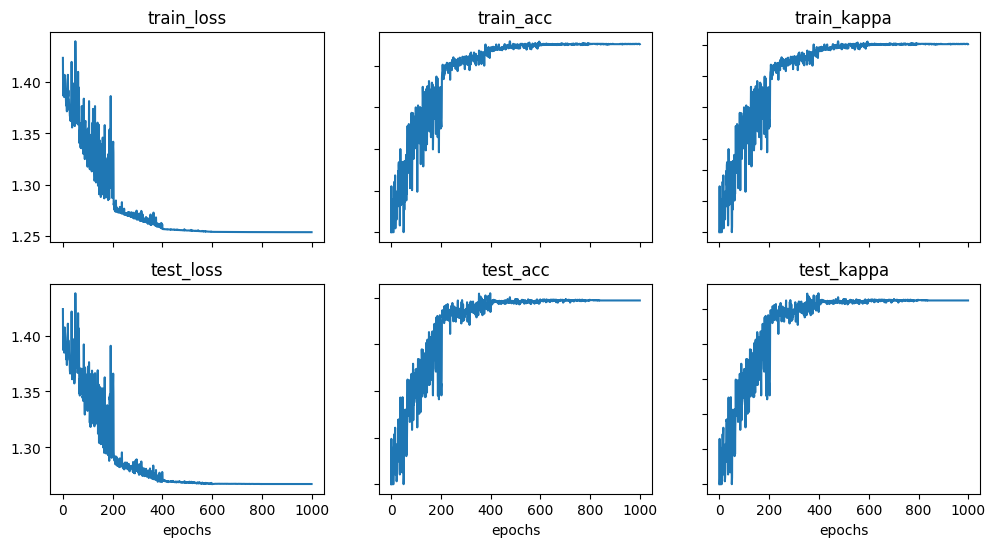

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

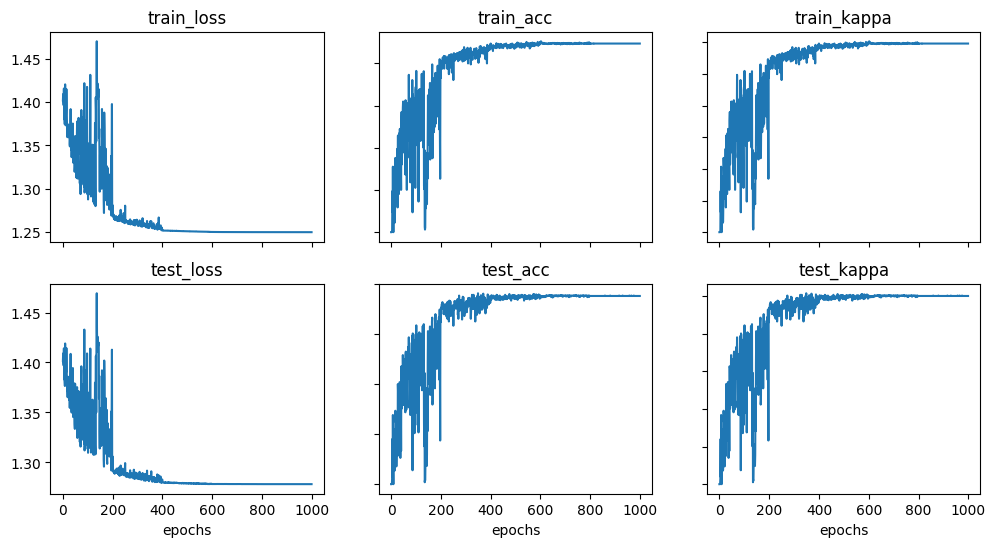

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()